# Homework 1
## Introduction
### Important dates
* Homework release: Thursday, 3rd October 2019
* **Homework due**: Wednesday, 16th October 2019 (23:59 hours, 11:59 PM)
* Peer review due: Wednesday, 23rd October 2019 (23:59 hours, 11:59 PM)
* Grading release: Wednesday, 30th October 2019

### Description

The data you'll be working with comes from multiple sources. The main data source will be [DBLP](https://dblp.uni-trier.de/), a database of publications from major computer science journals and conferences. A subset of DBLP, which you will use in this assignment, is provided to you via a [google drive folder](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view). Later on, you will enrich the DBLP data with a dataset on conference rankings and with the proceedings of the [NIPS conference](https://nips.cc/) [1] ('proceedings' is another word for the set of papers published at an academic conference). After loading and cleaning the data, you will answer various questions about its contents.

**Some rules:**
- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you have to justify your choice.
- Make sure you use the data folder provided in the repository in *read-only* mode.
- Be sure to provide explanations for your answers. A notebook that only has code cells will not suffice.
- Also, be sure to *hand in a fully-run and evaluated notebook*. We will not run your notebook for you, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

[1] Note that NIPS was renamed to NeurIPS in 2018, but for simplicity, whenever we say 'NIPS', we really mean 'NIPS and NeurIPS'.

## Task A. Getting a sense of the dataset

### A1. Loading the data
Download the DBLP dataset (available on [google drive](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view)) and load it into a Pandas dataframe. A row of your dataframe should look as follows:

| paper id | author names | publication year | paper title | 
| :----:|:-------------:| :-----:|:-----:|
| conf/nips/doe1036 | [John Doe, Jane Doe] | 2003 | Some Catchy Title: An Expanded and Boring Title | 


1. Filter the papers: keep only conference papers. For each of the remaining ones, find the acronym of the conference where it was published. Retain only those papers that have been published in the conferences listed in `data/list_of_ai_conferences.txt`. Additionally, add a column named 'conference' to your dataframe.   
_Hint: The `paper id` tells you whether a paper was published at a conference, and if so, at which one._

2. Report the overall number of papers in the filtered dataset, as well as the number of papers per conference.

In [1]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
import re
from scipy import stats
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import chi2
import warnings; warnings.simplefilter('ignore')
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from requests import get
from bs4 import BeautifulSoup

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("data/dblp.tsv",sep='\t')
df.head()

,id,authors,year,title
0,tr/meltdown/s18,"['Paul Kocher', 'Daniel Genkin', 'Daniel Gruss...",2018.0,Spectre Attacks: Exploiting Speculative Execut...
1,tr/meltdown/m18,"['Moritz Lipp', 'Michael Schwarz 0001', 'Danie...",2018.0,Meltdown
2,tr/acm/CS2013,[],2013.0,Computer Science Curricula 2013
3,tr/gte/TR-0263-08-94-165,['Frank Manola'],1994.0,An Evaluation of Object-Oriented DBMS Developm...
4,tr/gte/TR-0222-10-92-165,"['Michael L. Brodie', 'Michael Stonebraker']",1993.0,DARWIN: On the Incremental Migration of Legacy...


In [3]:
#Filter to include only the papers that have conf in their id aka the ones which are conference papers
df = df[df.id.str.startswith('conf')] 

#Open the text of ai conferences and create a list of ai conferences
conf_txt = open('data/list_of_ai_conferences.txt', 'r')
conf_list = [line.strip('\n') for line in conf_txt.readlines()]

#Create a series with the ai conferences and add it as an extra column
df['conference'] = [name.split('/')[1] for name in df.id]

#Filter out the papers which were not part of one of the given ai conferences
df = df[df['conference'].isin(conf_list)]

#Overall number of papers in the filtered dataset and the number of papers per conference
print('The dataframe has ' + str(df.shape[0]) + ' entries.')
grouped_by_conf = df.groupby('conference').agg({'id': 'count'})
grouped_by_conf.rename(columns={"conference": "Conference", "id": "Number of Papers"})

The dataframe has 102003 entries.


,Number of Papers
conference,
aaai,10796
aamas,367
accv,2390
acl,6330
cvpr,12853
emnlp,3299
fgr,1383
icann,3134
iccbr,863


* The above result shows us the overall number of papers in the filtered dataset, as well as the number of papers per conference.

In [4]:
#reset the index for practical reasons
df = df.reset_index(drop=True)

### A2. An author-centric look
The dataframe you created above was a paper-centric one. Now, we want you to create a new dataframe centered around authors. Do this by expanding the author names in the lists in the 2nd column into separate rows. That is, if a paper has 3 authors, turn that row into 3 rows, each of which only contains one of the author names (along with the rest of the paper information, i.e., title, conference and year). Keep both dataframes, we are going to need both of them.    
**Report the number of unique authors.**

In [5]:
#Remove the special characters from the Authors names
df.authors = df.authors.str.replace("[", "")
df.authors = df.authors.str.replace("]", "")
df.authors = df.authors.str.replace("\"", "")
df.head()

,id,authors,year,title,conference
0,conf/iccv/KunoOO90,"'Yoshinori Kuno', 'Yasukazu Okamoto', 'Satoshi...",1990.0,Object recognition using a feature search stra...,iccv
1,conf/iccv/VedulaBRCK99,"'Sundar Vedula', 'Simon Baker', 'Peter Rander'...",1999.0,Three-Dimensional Scene Flow.,iccv
2,conf/iccv/MeminP99,"'Étienne Mémin', 'Patrick Pérez'",1999.0,Fluid Motion Recovery by Coupling Dense and Pa...,iccv
3,conf/iccv/DickinsonPR90,"'Sven J. Dickinson', 'Alex Pentland', 'Azriel ...",1990.0,Qualitative 3-D shape reconstruction using dis...,iccv
4,conf/iccv/SinghYL17,"'Avi Singh', 'Larry Yang', 'Sergey Levine'",2017.0,GPLAC: Generalizing Vision-Based Robotic Skill...,iccv


In [6]:
#Create a copy of the data, to keep both versions
#df_authors is the author-centric dataframe
df_authors = df.copy()

In [7]:
#Expand the author names to new columns and stack them, include id in dataframe for later merge
authors_expanded = pd.DataFrame(df_authors.authors.str.split(',').tolist(), index = df_authors.id).stack(dropna=True)
authors_expanded = authors_expanded.reset_index([0, 'id'])
authors_expanded.columns = ['id', 'author']

#Drop the old 'authors' column
df_authors.drop('authors', axis=1, inplace=True)

#Inner join of the authors names and the papers details for the merge
df_authors = pd.merge(authors_expanded, df_authors, on='id')

#Remove trailing and leading whitespaces from the authors' names
df_authors['author'] = df_authors['author'].str.strip()
df_authors['author'] = df_authors.author.str[1:-1]

#Display the author-centric DataFrame 
df_authors.head()

,id,author,year,title,conference
0,conf/iccv/KunoOO90,Yoshinori Kuno,1990.0,Object recognition using a feature search stra...,iccv
1,conf/iccv/KunoOO90,Yasukazu Okamoto,1990.0,Object recognition using a feature search stra...,iccv
2,conf/iccv/KunoOO90,Satoshi Okada,1990.0,Object recognition using a feature search stra...,iccv
3,conf/iccv/VedulaBRCK99,Sundar Vedula,1999.0,Three-Dimensional Scene Flow.,iccv
4,conf/iccv/VedulaBRCK99,Simon Baker,1999.0,Three-Dimensional Scene Flow.,iccv


In [8]:
#Report the number of unique authors
unique_authors=df_authors.author.unique()
print('There are {0} unique authors.'.format(len(unique_authors)))

There are 105818 unique authors.


### A3. Is your data analysis-friendly?

Using an appropriate view of your data (paper-centric or author-centric), solve the following tasks:

1. Plot the number of papers per author and analyze it. Do you observe any outliers? Can you identify the source of the problem? Please elaborate!   
_Hint: To find out where the problem comes from, try performing an analysis at the conference or year level._   
Make sure you remove this inconsistency from your dataframe before moving to the next step, and also create a new plot of the number of papers per author after fixing the problem.   

2. Plot the number of papers per year. Do you observe any inconsistency in the output? Real-world data is usually messy, with typos, erroneous entries, and sometimes issues that make even loading the data problematic. Fix any errors that you encounter along the way, find ways to clean the attribute `year`, and redo the plot of the number of papers per year.   

3. Machine learning (ML) has been one of the hottest topics within the broader area of AI recently, so let’s see if this is reflected in the number of ML publications. In particular, let’s focus on the two major ML conferences, NIPS and ICML: make a new dataframe with only NIPS and ICML papers (let’s call these the “ML papers”), plot the number of ML papers over time, and analyze and discuss the plot. Do you observe anything odd in this plot? What causes these problems?   
_Hint: Try to perform an analysis at the conference or year level._   

4. By now, you may have noticed that some conferences are not fully represented in the DBLP dataset. Complete the paper-centric dataframe by scraping the full NIPS data from the online proceedings at https://papers.nips.cc/ (maintain the same schema used in your previous dataframes, but fill in missing values). After this step, remove any remaining papers that have missing values. Redo the plots of steps A3.2 and A3.3 after fixing the issue.   

_Note: In order to avoid re-running the cleaning part of the notebook every time, you could save the results at this point as a pickle file! Also, propagating your cleaning to both dataframes might prove useful later on._

***A3.1*** 

* We choose to use the author-centric dataframe since we need to group by authors.

In [9]:
#Create dataframe for the number of papers published by author using groupby and count
count_publications = df_authors.groupby(['author']).count().reset_index()[['author','id']].rename(columns = {"id": "number_publications"})

#Sort resulting dataframe to examine extreme values
count_publications = count_publications.sort_values(by = 'number_publications', ascending=False)
count_publications.reset_index(inplace=True, drop=True)

#Display the head to show the extreme values
count_publications.head()

,author,number_publications
0,,950
1,Sheila A. McIlraith,918
2,Satinder P. Singh (ed.),663
3,Luc Van Gool,220
4,Toshio Fukuda,196


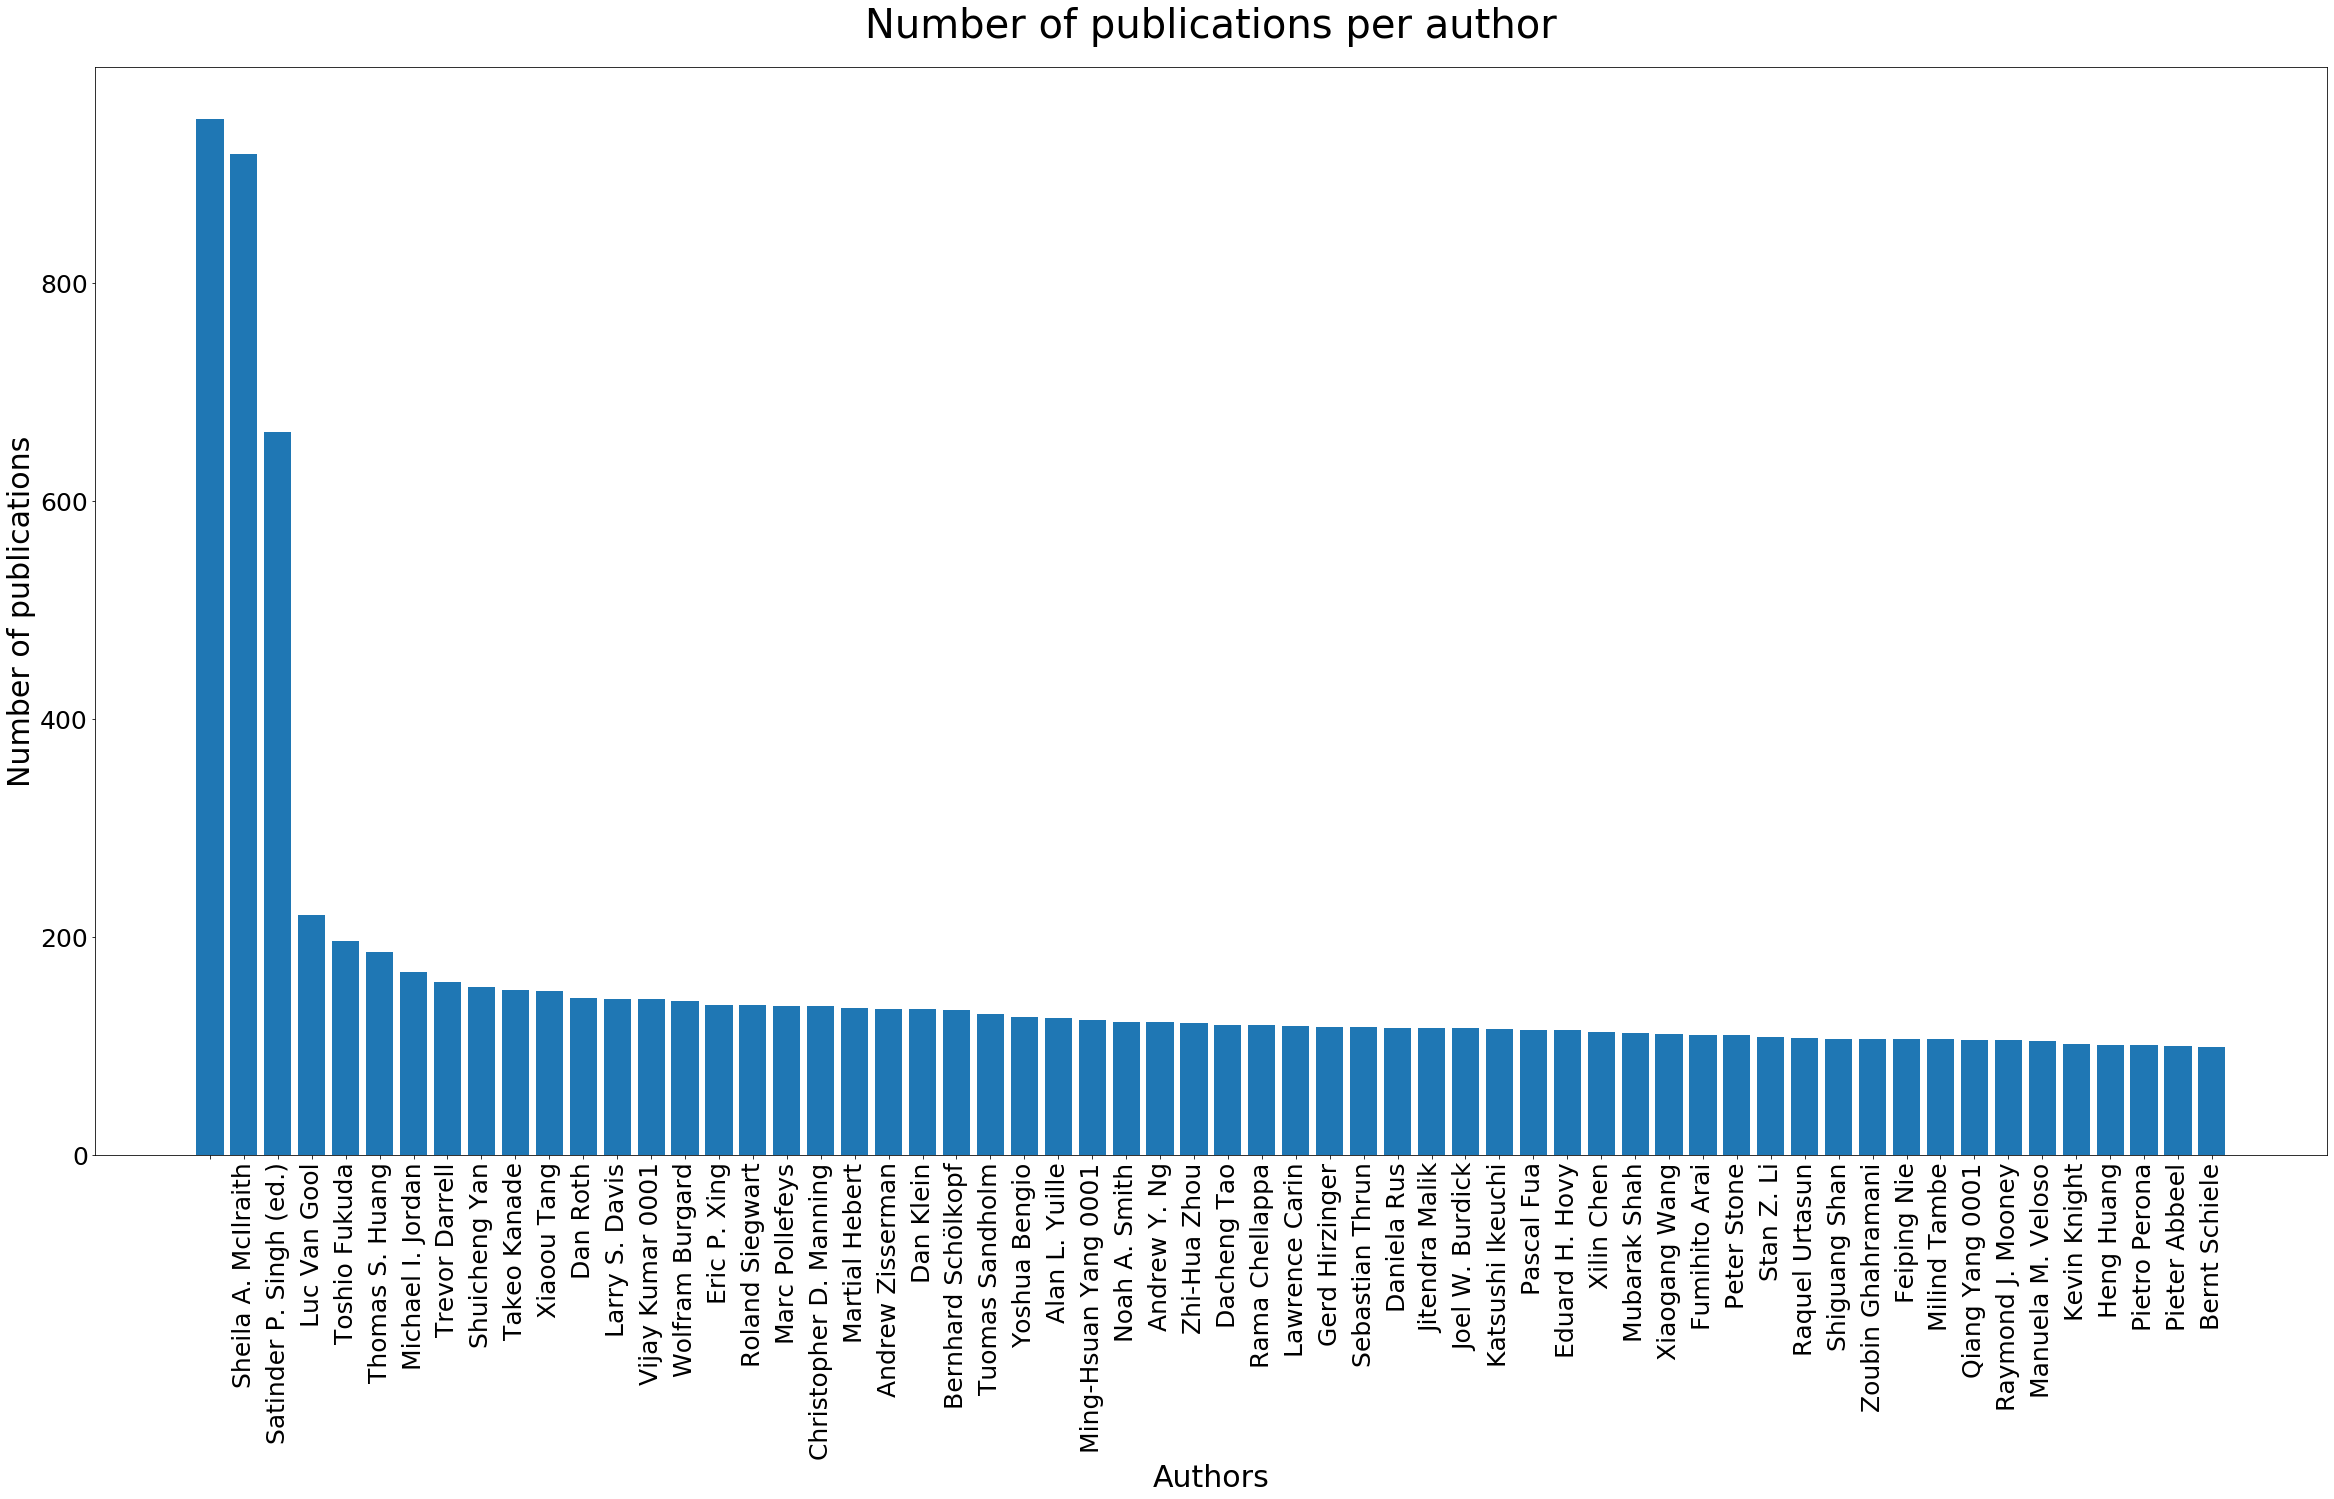

In [10]:
#Plot the first 60 values to examine anomalies 
#The reason why we plot a sample from our dataframe: 
#the size of dataframe is too big to make a full plot which includes every author
plt.figure(figsize=(40,20))
plt.bar(count_publications.author[:60],count_publications.number_publications[:60])
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Authors',fontsize=30)
plt.ylabel('Number of publications',fontsize=30)
plt.title('Number of publications per author',fontsize=40,pad=30)
plt.show()

* We see that there is an "author" with an empty name that we should remove.
* We also notice that the first two authors are outliers and we're now going to examine why.

In [11]:
#Finding the number of unique authors
unique_authors = df_authors.author.unique()
print('There are {0} unique authors.'.format(len(unique_authors)))

#Remove the empty author and compute unique authors again
df_authors = df_authors[[ x != "" for x in df_authors.author]]
unique_authors = df_authors.author.unique()
print('There are {0} unique authors after removing empty author.'.format(len(unique_authors)))

There are 105818 unique authors.
There are 105817 unique authors after removing empty author.


In [12]:
#We propagate the changes to the df dataframe and drop the author-less papers
#We remove papers without any author
df = df[[len(x)> 0 for x in df.authors]]

* Which outliers did we observe?
  * We see from the plot that there are 2 potential outliers which are Sheila A. McIlraith and Satinder P. Singh (ed.).

 * We will now examine the first one which is the author named  `Sheila A. McIlraith`.

 * **We first do an analysis at year level.**

In [13]:
#Compile the typical year format as a regular expression
year_format = re.compile('\\d{4}.\\d{1}')

Number of year formats for Sheila A. McIlraith :  9


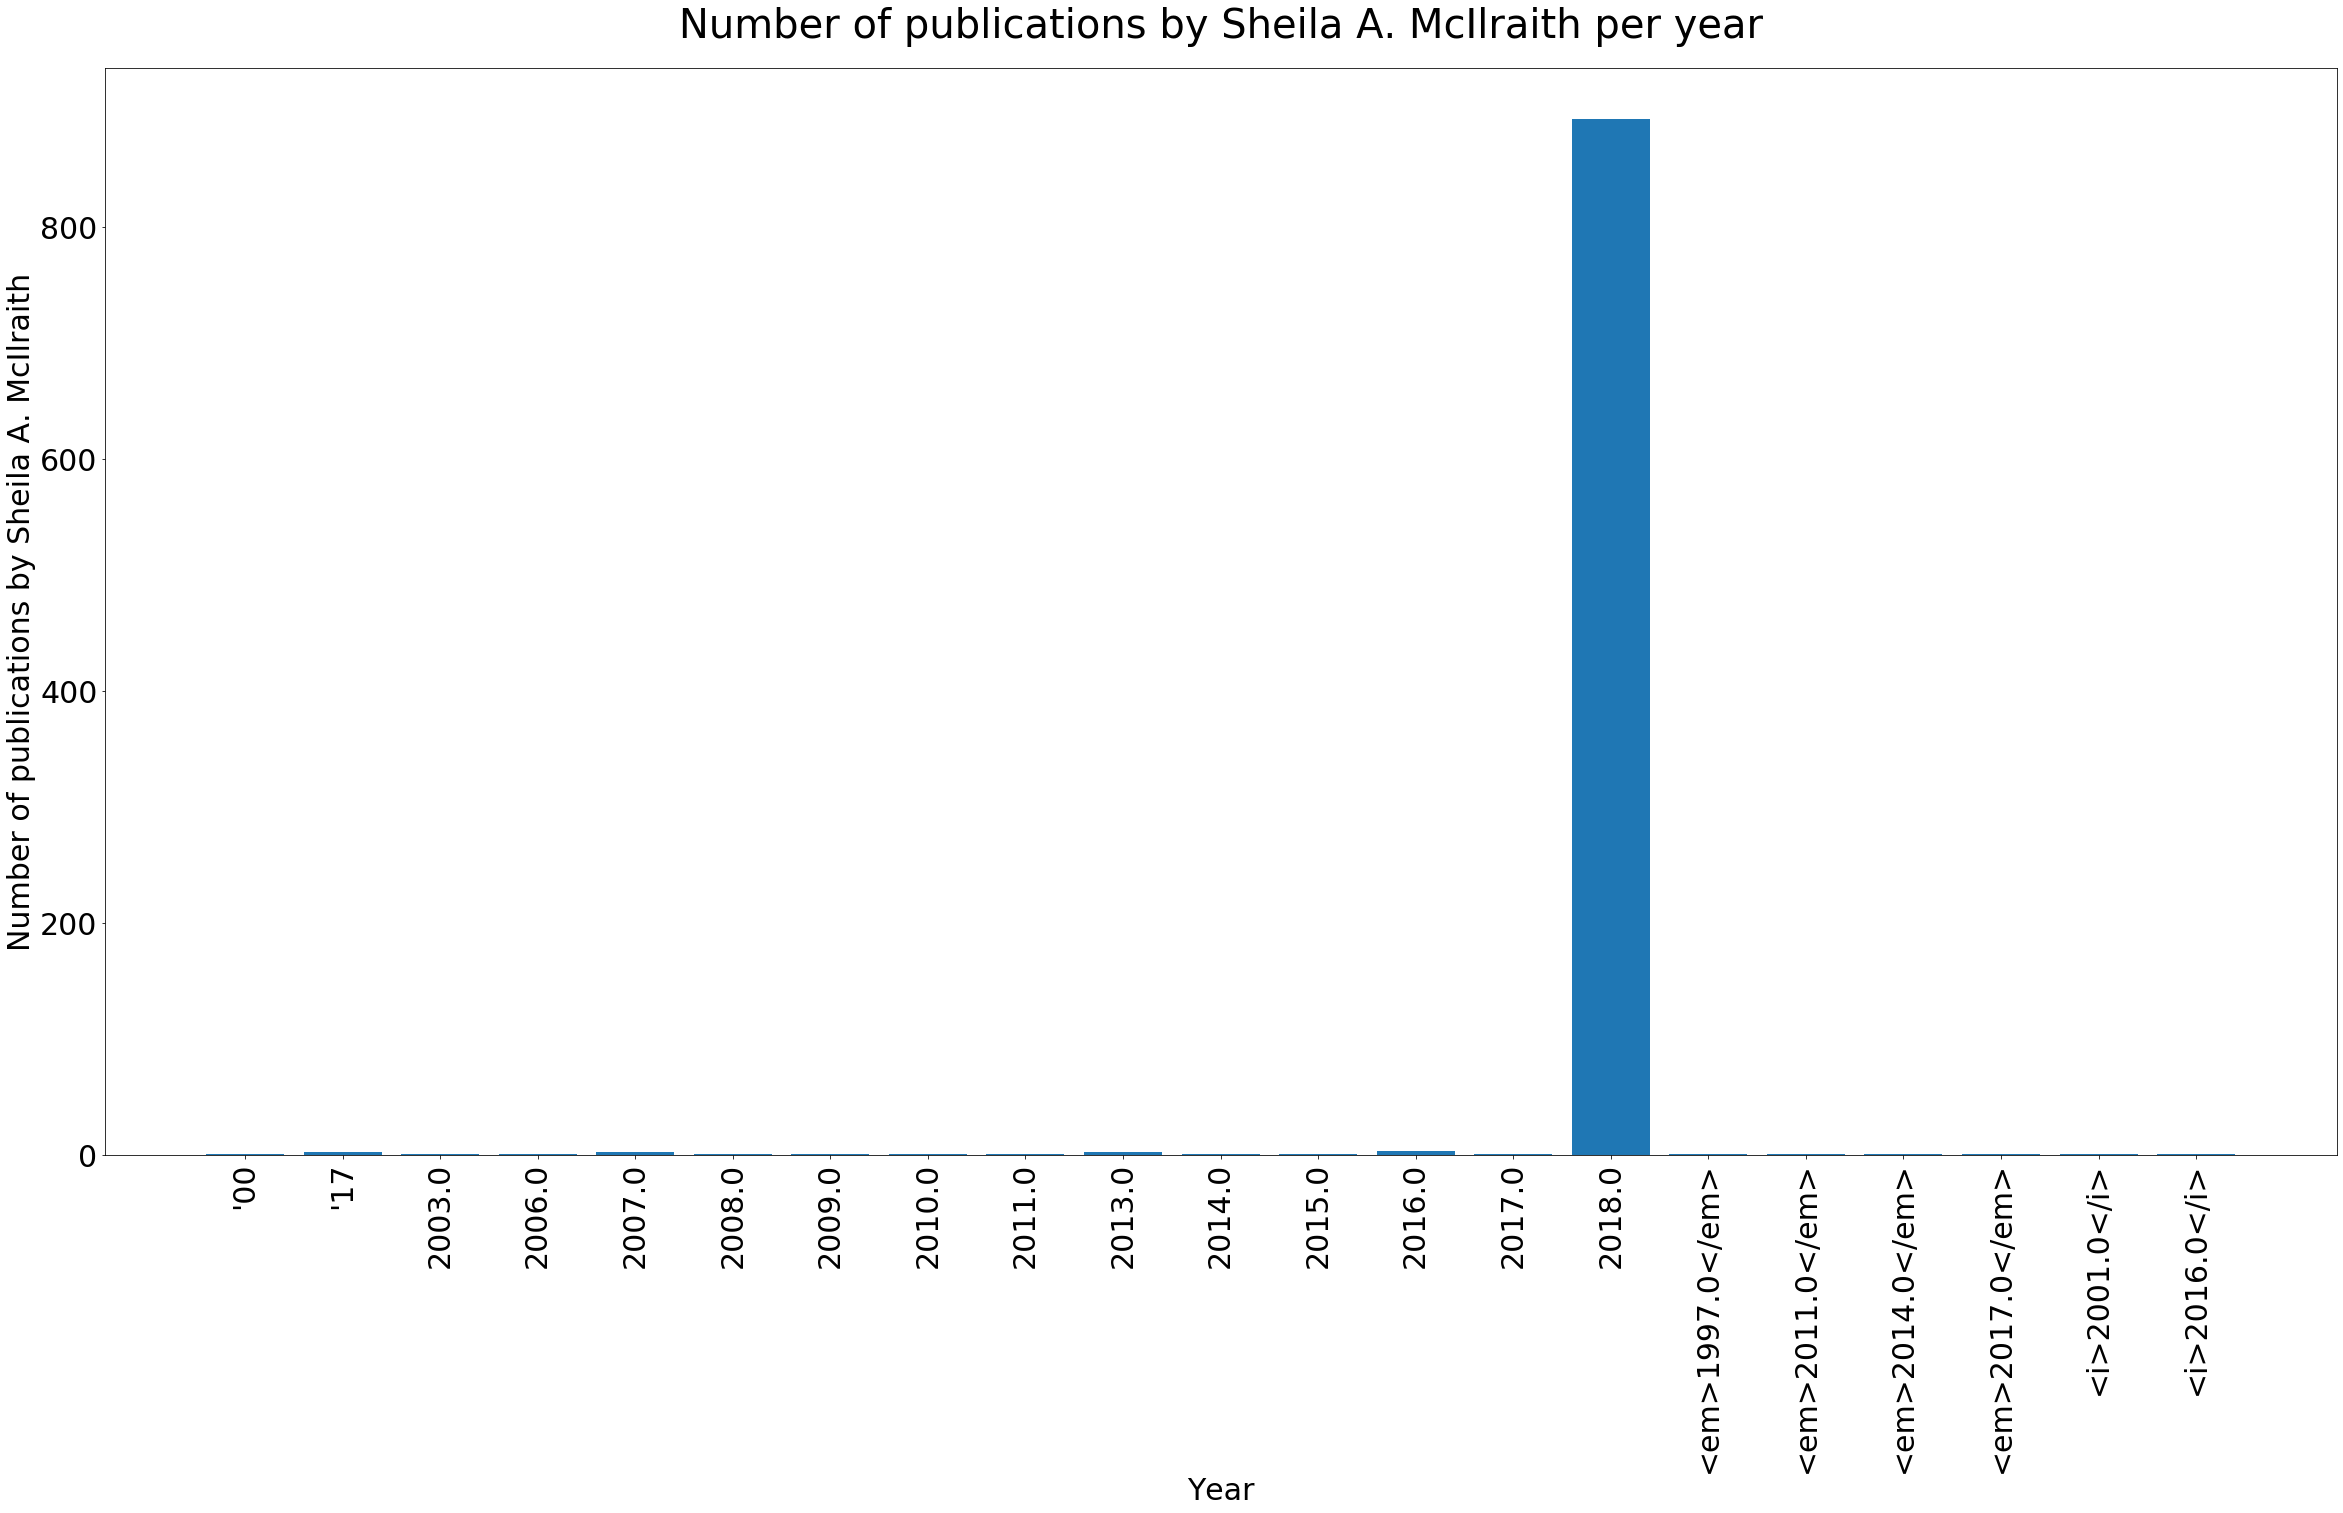

,id,author,year,title,conference
102145,conf/aaai/MuiseBM14,Sheila A. McIlraith,<em>2014.0</em>,Computing Contingent Plans via Fully Observabl...,aaai
106274,conf/aaai/SohrabiBM11,Sheila A. McIlraith,<em>2011.0</em>,Preferred Explanations: Theory and Generation ...,aaai
110760,conf/aaai/McIlraithS00,Sheila A. McIlraith,'00,What Sensing Tells Us: Towards a Formal Theory...,aaai
111100,conf/aaai/McIlraith97,Sheila A. McIlraith,<em>1997.0</em>,Representing Actions and State Constraints in ...,aaai
128213,conf/aaai/MombourquetteMM17,Sheila A. McIlraith,'17,Logical Filtering and Smoothing: State Estimat...,aaai


In [14]:
#Create dataframe for Sheila publications
SAM = df_authors[[x=='Sheila A. McIlraith' for x in df_authors.author]]

#Analyze the year format to see if it is a standard number or some other arbitrary format
s = SAM[[year_format.match(y) is None for y in SAM.year ]]
print("Number of year formats for Sheila A. McIlraith : ", len(s))

#Examine the number of publications Sheila made on the year level
SAM_per_year = SAM.groupby(['year']).agg({'id': ['count']})
plt.figure(figsize=(40,20))
plt.bar(SAM_per_year.index,SAM_per_year['id']['count'])
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications by Sheila A. McIlraith',fontsize=30)
plt.title('Number of publications by Sheila A. McIlraith per year',fontsize=40,pad=30)
plt.show()

#Display the head to show the rows where the years do not fit the usual format
s.head()

* We can see that some of the dates in our data don't correspond to years in the form of integers or floating points. The years seem to have been input in different formats which is not analysis friendly. We should clean the data later on.
* The plot shows that Sheila published more than 850 papers in 2018 which seems very unlikely considering the rest of the bars in the bar chart. Let's examine this further on the conference level.

* **Now we analyze the author at conference level.**

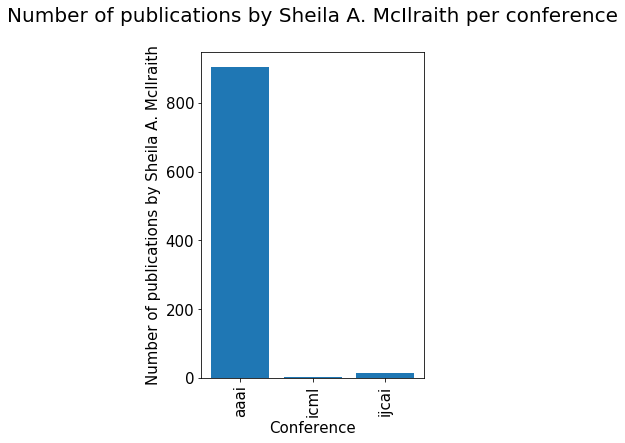

There are 890 publications made by Sheila A. McIlraith in conference aaai in 2018.


,id,author,year,title,conference
101358,conf/aaai/Lorini18,Sheila A. McIlraith,2018.0,In Praise of Belief Bases: Doing Epistemic Log...,aaai
101446,conf/aaai/CiosekW18,Sheila A. McIlraith,2018.0,Expected Policy Gradients.,aaai
101471,conf/aaai/CaoWGL18,Sheila A. McIlraith,2018.0,Asymmetric Joint Learning for Heterogeneous Fa...,aaai
101529,conf/aaai/Zhang0LZC18,Sheila A. McIlraith,2018.0,Joint Training for Neural Machine Translation ...,aaai
101570,conf/aaai/Yao0KTJLGYL18,Sheila A. McIlraith,2018.0,Deep Multi-View Spatial-Temporal Network for T...,aaai
...,...,...,...,...,...
134139,conf/aaai/ChenWC018,Sheila A. McIlraith,2018.0,Selecting Proper Multi-Class SVM Training Meth...,aaai
134161,conf/aaai/TanseyPS18,Sheila A. McIlraith,2018.0,Leaf-Smoothed Hierarchical Softmax for Ordinal...,aaai
134216,conf/aaai/AlTairMS018,Sheila A. McIlraith,2018.0,POMDP: State-Based Decision Making for Persona...,aaai
134224,conf/aaai/TompkinsR18,Sheila A. McIlraith,2018.0,Fourier Feature Approximations for Periodic Ke...,aaai


In [15]:
#Examine the number of publications Sheila made on the conference level to detect anomalies
SAM_per_year = SAM.groupby(['conference']).agg({'id': ['count']})
plt.figure(figsize=(4,6))
plt.bar(SAM_per_year.index,SAM_per_year['id']['count'])
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel('Conference',fontsize=15)
plt.ylabel('Number of publications by Sheila A. McIlraith',fontsize=15)
plt.title('Number of publications by Sheila A. McIlraith per conference',fontsize=20,pad=30)
plt.show()

#Create dataframe for publications by Sheila for the AAAI conference as there seems to be some form of anomaly
s2 = SAM[[ x=='aaai' for x in SAM.conference]]

#Printing the rows where conference is aaai and year is 2018
print('There are {0} publications made by Sheila A. McIlraith in conference aaai in 2018.'.format(len(s2[s2['year'] == '2018.0'])))

s2

* It looks like Sheila A. McIlraith did most of her publications (890 publications) at the same conference (AAAI) in the same year (2018) which seems very unlikely. If we check on DBLP website it looks like she only did 1 publication at this conference in 2018.

* **It seems that Sheila is indeed an outlier in our dataset and we are going to drop the rows corresponding to her publications in 2018.**

In [16]:
#Drop the publications that presumably Sheila did in 2018
df_authors = df_authors[(df_authors.author != 'Sheila A. McIlraith') | (df_authors.year != '2018.0')]

- We now examine the author named `Satinder P. Singh (ed.)`

**Before going any further, the name suggests that it is an outlier. In fact '(ed.)' shows that Satinder does not have author credit in the papers with his name, but he has editor credit. This shows us that the dataset does not distinguish authors from editors and that this should be dealt with (the editors removed as they are not authors).** 

* We should drop the rows whose have editors information in its author name.

In [17]:
#Find editor data
df_editors = df_authors[df_authors.author.str.endswith("(ed.)", "ed.")]
print("All editors in our dataset : ", df_editors.author.unique())

All editors in our dataset :  ['Satinder P. Singh (ed.)']


* We see that the editors in our dataset only consist of Satinder P. Singh (ed.), and we can drop those rows.

In [18]:
#Dropping data that belongs to editors
df_authors = df_authors[df_authors['author'] != 'Satinder P. Singh (ed.)']

* Now, we proceed to draw the bar chart without the outliers.

In [19]:
#Same procedure as before to count the number of publications by author
count_publications = df_authors.groupby(['author']).count().reset_index()[['author','id']].rename(columns={"id": "number_publications"})
count_publications = count_publications.sort_values(by='number_publications', ascending=False)
count_publications.reset_index(inplace=True, drop=True)
count_publications.head()

,author,number_publications
0,Luc Van Gool,220
1,Toshio Fukuda,196
2,Thomas S. Huang,186
3,Michael I. Jordan,168
4,Trevor Darrell,158


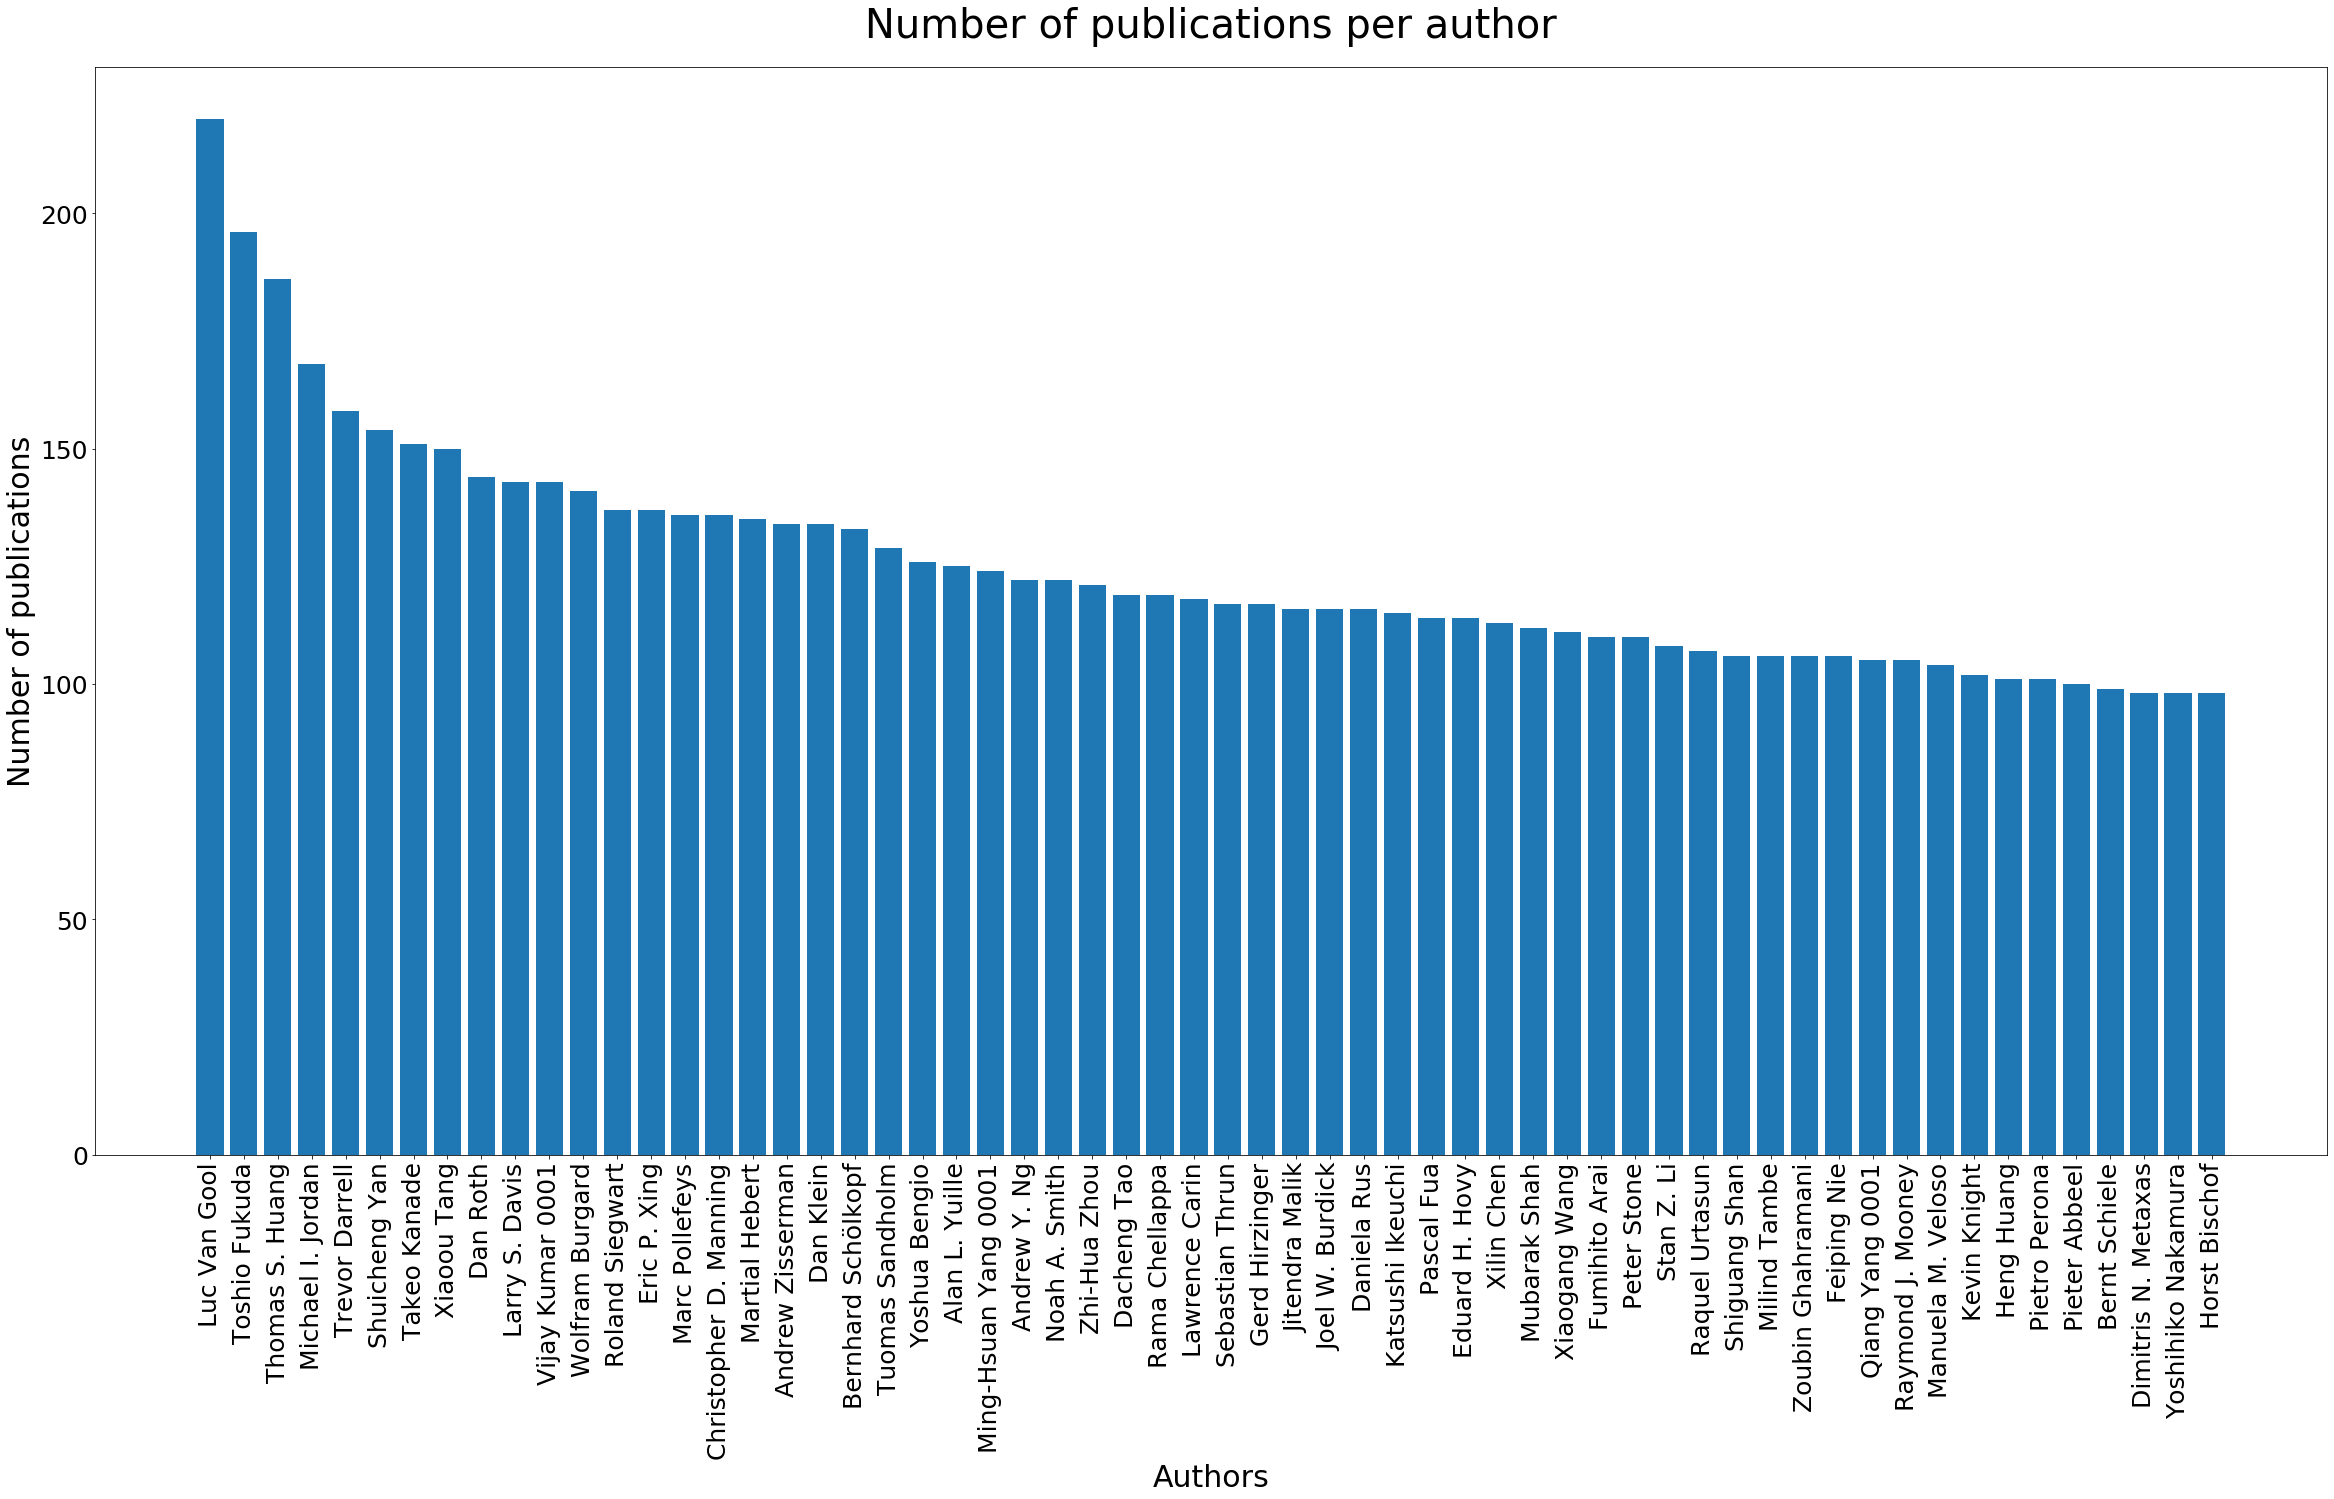

In [20]:
plt.figure(figsize=(40,20))
plt.bar(count_publications.author[:60],count_publications.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Authors',fontsize=30)
plt.ylabel('Number of publications',fontsize=30)
plt.title('Number of publications per author',fontsize=40,pad=30)
plt.show()

**We can clearly see that the data is much more realistic now.**

***A3.2*** 

* We decide to use the paper-centric dataframe as the author-centric one contains duplicates of papers for each author who contributed to writing it.

In [21]:
#Group by the year and get the number of publications by year
count_per_year = df.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
count_per_year = count_per_year.sort_values(by='number_publications', ascending=False)
count_per_year.reset_index(inplace=True, drop=True)
count_per_year

,year,number_publications
0,2018.0,6224
1,2017.0,5058
2,2015.0,4218
3,2016.0,4156
4,2013.0,3418
...,...,...
192,1990,1
193,2014,1
194,2006,1
195,2009,1


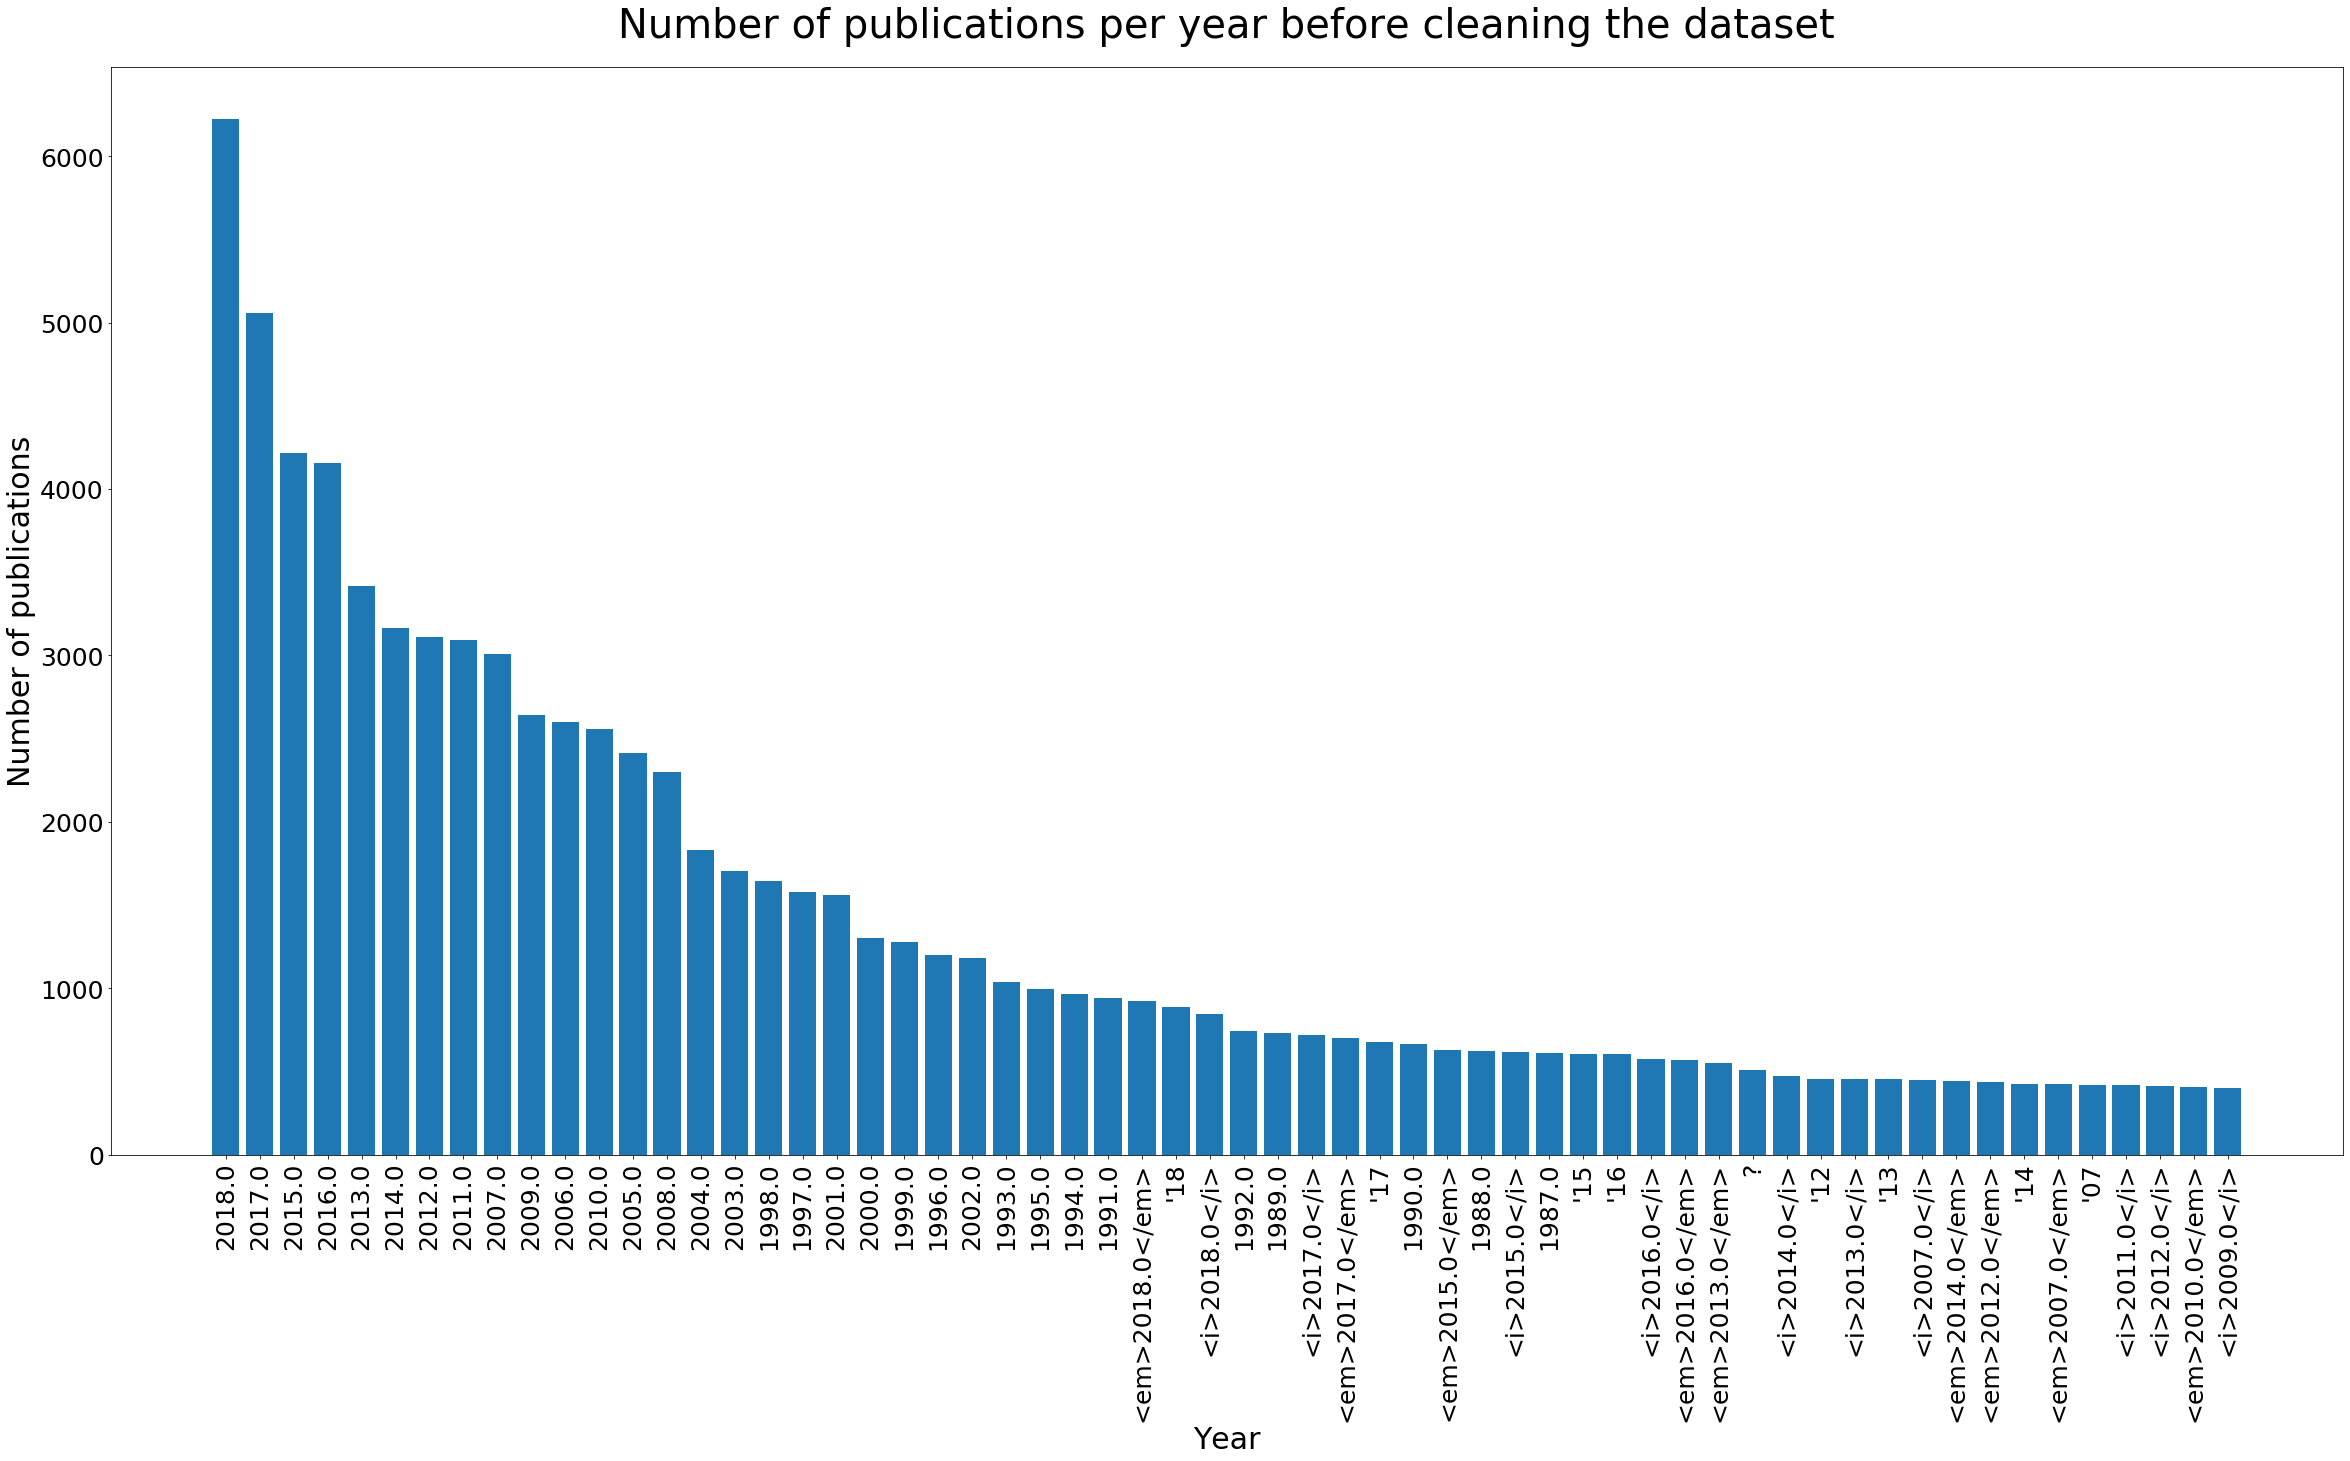

In [22]:
#Plotting the number of publications per year
plt.figure(figsize=(40,20))
plt.bar(count_per_year.year[:60],count_per_year.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications',fontsize=30)
plt.title('Number of publications per year before cleaning the dataset',fontsize=40,pad=30)
plt.show()

* We notice that the dates have been provided in several formats which is not analysis friendly for further. We saw:
  * ' + last two digits of date
  * escape character + date + another escape character
  * dates as integers (without a trailing zero `.0`)
  * dates as floats (with trailing zero `.0`)
  * NaN values aka Not a Number
* We hence need to clean the data by
  * Using regex
    * We replace the non-digit characters by empty characters
    * We get rid of the `.0` and replace it with empty characters
  * Using lambda expressions
    * We add 2000 or 1900 to the two digit numbers that remain in the dataframe depending on which is the more realistic choice (i.e. if it's less than 19, it's probably in the 2000's and otherwise it's in the 1900's)
    * We cast all years to integers

In [23]:
#Replace all '.0' first by empty characters so it does not interfere with the removal of non-digit characters later on
df['year'] = df.year.str.replace(r"\.0",'')
#Remove all non-digit characters
df['year'] = df.year.str.replace("[\D]",'')

#Check empty years
empty_years = df[df['year'] == '']
print('The number of rows with empty year entries is ' + str(len(empty_years)) + '.')

The number of rows with empty year entries is 630.


* We can see that there are a lot of missing dates. We can try to get them from another entry in the dataframe perhaps.

In [24]:
empty_years.head()

,id,authors,year,title,conference
62045,conf/nips/WangSJ11,"'Zuoguan Wang', 'Gerwin Schalk', 'Qiang Ji'",,Anatomically Constrained Decoding of Finger Fl...,nips
62073,conf/nips/BachM10,"'Stephen H. Bach', 'Marcus A. Maloof'",,A Bayesian Approach to Concept Drift.,nips
62077,conf/nips/RamkumarPHLL11,"'Pavan Ramkumar', 'Sebastian Pannasch', 'Bruce...",,How Does the Brain Represent Visual Scenes? A ...,nips
62088,conf/nips/KolarBRS11,"'Mladen Kolar', 'Sivaraman Balakrishnan', 'Ale...",,Minimax Localization of Structural Information...,nips
62105,conf/nips/LempitskyZ10,"'Victor S. Lempitsky', 'Andrew Zisserman'",,Learning To Count Objects in Images.,nips


* **We can see that the id contains the date as the last two digits: for example, the id 'conf/nips/WangSJ11' indicates that the paper is from 2011. Let's try to extract them with regular expressions and see if we manage to get all the dates.**

In [25]:
missing_dates = [str(re.search('[0-9]{2}',x)[0]) for x in empty_years['id']]
print('Number of missing dates recovered: ' + str(len(missing_dates)))

Number of missing dates recovered: 630


In [26]:
#Fill year column with the years that we gathered from their ids
empty_years.loc[:,'year'] = missing_dates

empty_years = empty_years.drop(['authors','title','conference'],axis=1)
empty_years.head()

,id,year
62045,conf/nips/WangSJ11,11
62073,conf/nips/BachM10,10
62077,conf/nips/RamkumarPHLL11,11
62088,conf/nips/KolarBRS11,11
62105,conf/nips/LempitskyZ10,10


In [27]:
print(len(empty_years))

630


* Yay! We managed to recover all the missing dates (as the sizes are the same) :) Now we proceed to add them to the 'year' entry in dataframe using a join.

In [28]:
#Join on id and fill year column
df = pd.merge(df, empty_years, on='id', how='left').fillna('')
df['year'] = df['year_x'] + df['year_y']

#Cast all years to numbers (as they are strings at the moment)
df['year'] = pd.to_numeric(df['year'])

#Replacing two-digit years by the appropriate format as explained above
df['year'] = df['year'].apply(lambda x: x + 2000 if x < 20 else x)
df['year'] = df['year'].apply(lambda x: x + 1900 if x < 100 else x)

#Remove all NaN entries
df = df.dropna(subset=['year'])

#Cast years to integers
df.year = df['year'].astype(np.int64)

df = df.drop(['year_y','year_x'],axis=1)

In [29]:
#Check if there is still missing dates in df
len(df[df['year'] == ''])

0

* We managed to fill in the blank dates!

In [30]:
#We apply the same changes we have done to the dataframe df to df_authors
df_authors['year'] = df_authors.year.str.replace(r"\.0",'')
df_authors['year'] = df_authors.year.str.replace("[\D]",'')
df_authors = pd.merge(df_authors, empty_years, on='id', how='left').fillna('')
df_authors['year'] = df_authors['year_x'] + df_authors['year_y']
df_authors = df_authors.drop(['year_y','year_x'],axis=1)
df_authors['year'] = pd.to_numeric(df_authors['year'])
df_authors['year'] = df_authors['year'].apply(lambda x: x + 2000 if x < 20 else x)
df_authors['year'] = df_authors['year'].apply(lambda x: x + 1900 if x < 100 else x)
df_authors = df_authors.dropna(subset=['year'])
df_authors.year = df_authors['year'].astype(np.int64)

In [31]:
#We filter out the publications dropped in the previous operations from the df dataframes
df = df[df.id.isin(df_authors.id)]

In [32]:
#Checking the papers per year after the cleaning
count_per_year = df.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
count_per_year = count_per_year.sort_values(by='number_publications', ascending=False)
count_per_year.reset_index(inplace=True, drop=True)

In [33]:
print("Number of unique authors at this point : ", len(df_authors.id.unique()))

Number of unique authors at this point :  101049


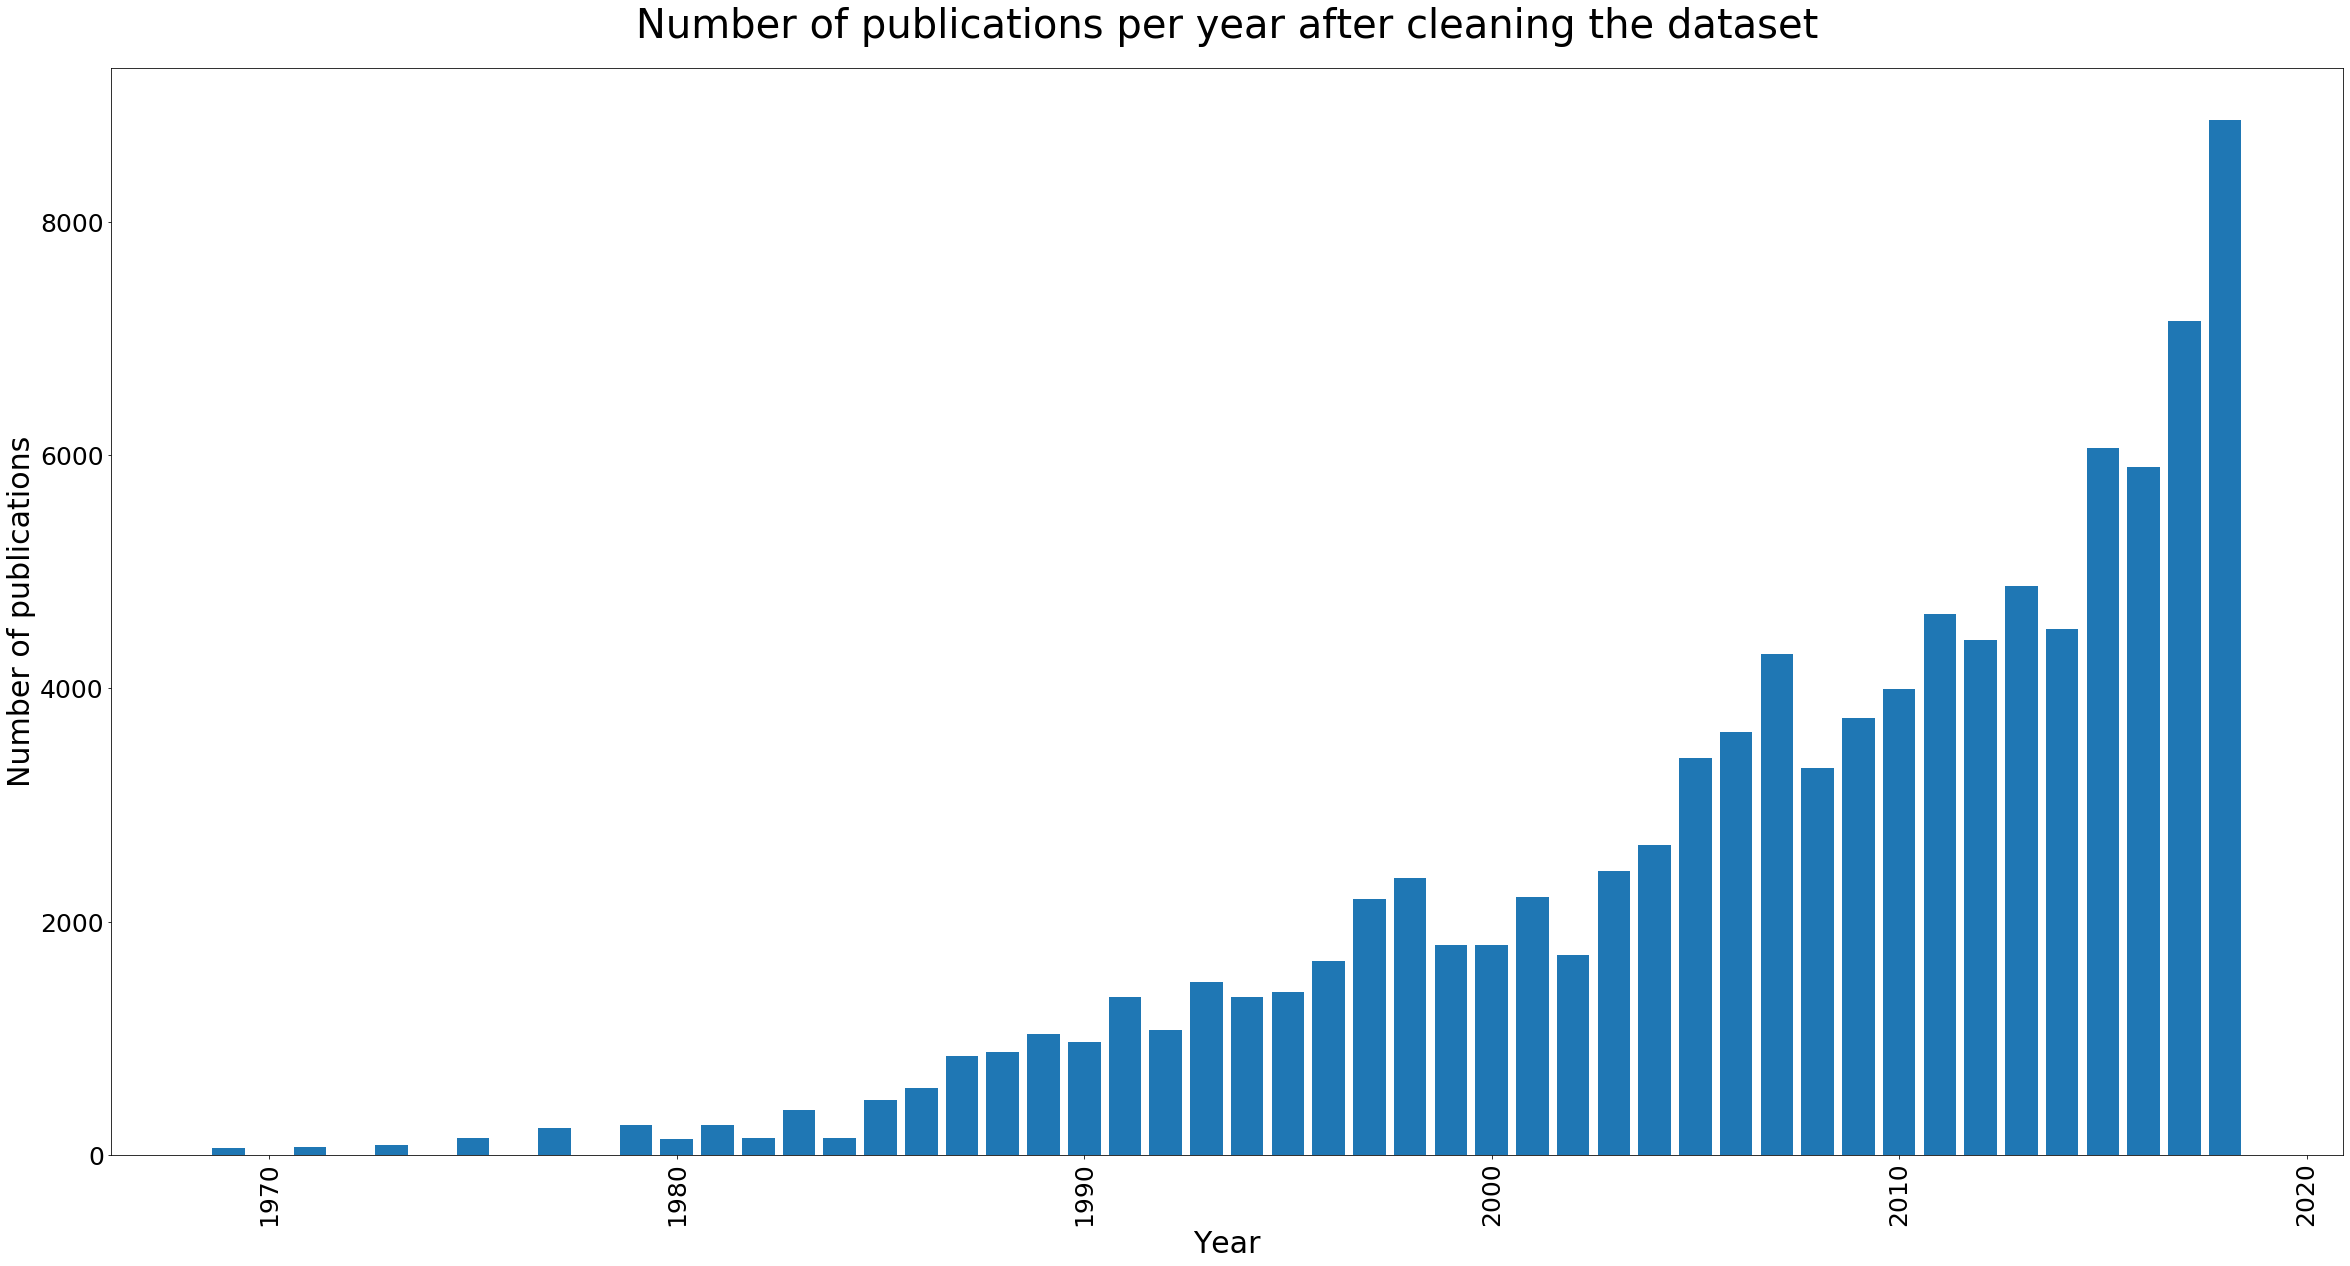

In [34]:
plt.figure(figsize=(40,20))
plt.bar(count_per_year.year[:60],count_per_year.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications',fontsize=30)
plt.title('Number of publications per year after cleaning the dataset',fontsize=40,pad=30)
plt.show()

* We can see that the dates now have only one format. This has narrowed down the list of dates and has given a more realistic bar chart.

***A3.3*** 

* Again, we choose to use the paper-centric dataframe as it does not contain duplicates of publications.

In [35]:
#Make a list of the conferences in which we are interested
mlconf = ['icml', 'nips']
#Filter out all conferences other than NIPS and ICML
df_ml = df[df['conference'].str.lower().isin(mlconf)]
df_ml.reset_index(inplace=True, drop=True)
df_ml.head()

,id,authors,title,conference,year
0,conf/nips/FelzenszwalbO14,"'Pedro F. Felzenszwalb', 'John G. Oberlin'",Multiscale Fields of Patterns.,nips,2014
1,conf/nips/Davis88,'Lawrence Davis',Mapping Classifier Systems Into Neural Networks.,nips,1988
2,conf/nips/Yuille05,'Alan L. Yuille',Augmented Rescorla-Wagner and Maximum Likeliho...,nips,2005
3,conf/nips/MelRA96,"'Bartlett W. Mel', 'Daniel L. Ruderman', 'Kevi...",Complex-Cell Responses Derived from Center-Sur...,nips,1996
4,conf/nips/0001OZ12,"'Ping Li 0001', 'Art B. Owen', 'Cun-Hui Zhang'",One Permutation Hashing.,nips,2012


In [36]:
#Get the number of publications per year for the conferences
count_per_year = df_ml.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
count_per_year = count_per_year.sort_values(by='number_publications', ascending=False)
count_per_year.reset_index(inplace=True, drop=True)
count_per_year.head()

,year,number_publications
0,2018,1630
1,2017,1111
2,2016,925
3,2015,746
4,2014,742


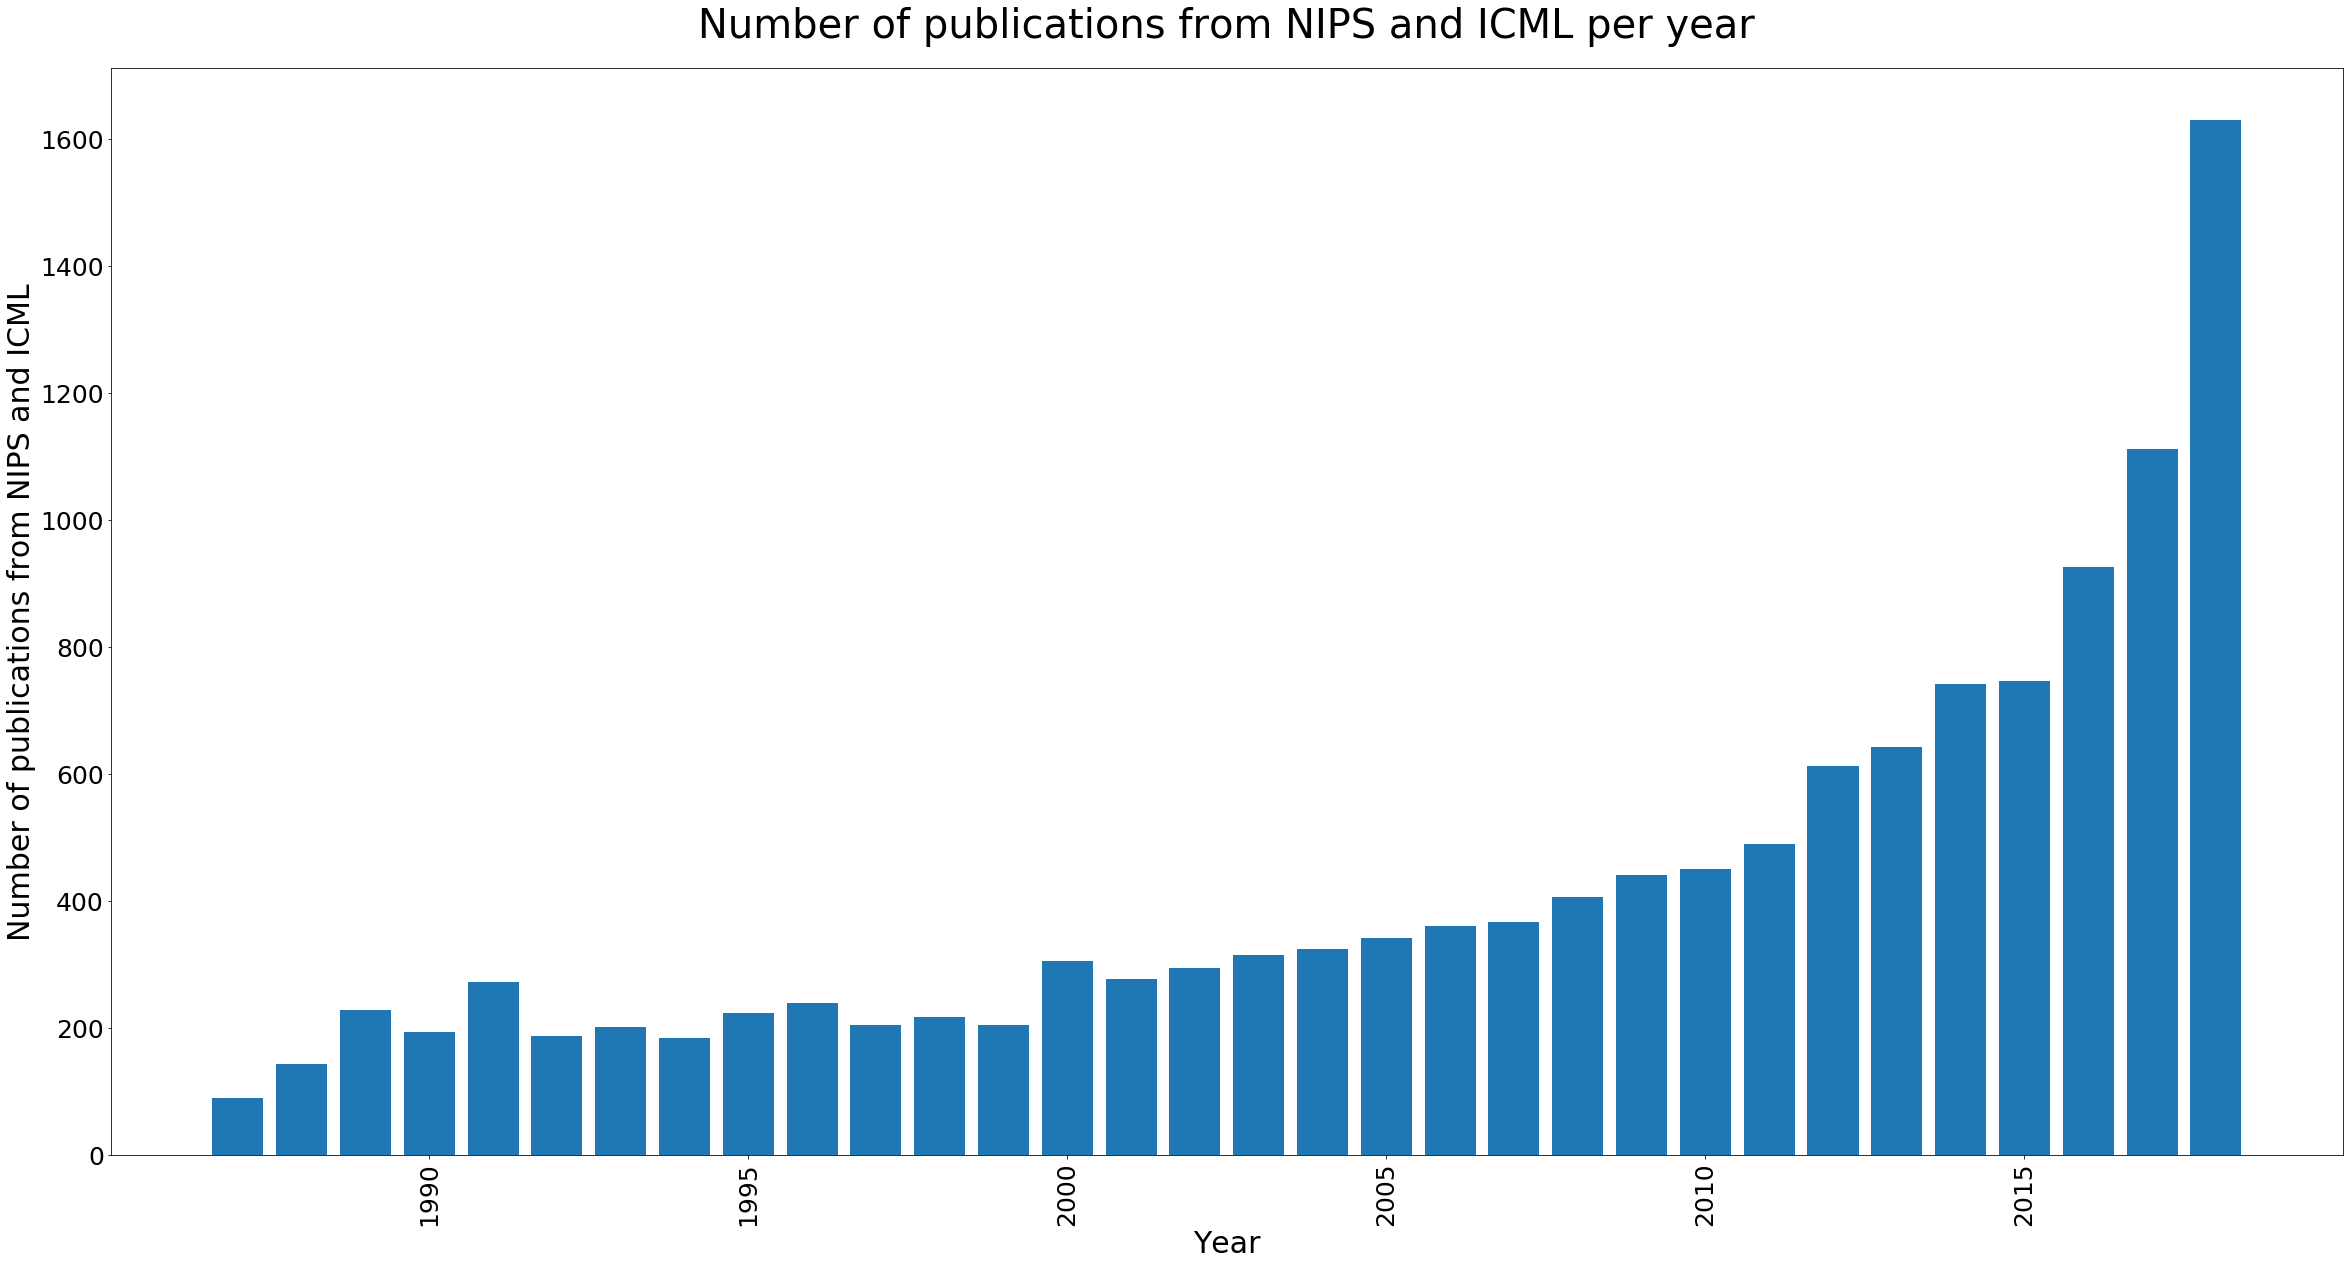

In [37]:
#Plot the number of publications per year for the conferences
plt.figure(figsize=(40,20))
plt.bar(count_per_year.year[:60],count_per_year.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications from NIPS and ICML',fontsize=30)
plt.title('Number of publications from NIPS and ICML per year',fontsize=40,pad=30)
plt.show()

From the above bar chart, we can clearly see that there is an explosion in the number of ML papers over the years. Especially, in recent years these numbers have rocketed to around 1600 publications. 
* This might be true as the interest for ML has increased in recent years.
* But it might also be an outlier. 

In [38]:
#Get the number of publications for each conference
count_per_conf = df_ml.groupby(['conference']).count().reset_index()[['conference','id']].rename(columns={"id": "number_publications"})
count_per_conf = count_per_conf.sort_values(by='number_publications', ascending=False)
count_per_conf.reset_index(inplace=True, drop=True)
count_per_conf

,conference,number_publications
0,nips,8395
1,icml,4977


In [39]:
#Get the number of publications per conference per year
count_per_conf_per_year = df_ml.groupby(['conference','year']).count().reset_index()[['conference','year','id']].rename(columns={"id": "number_publications"})
count_per_conf_per_year = count_per_conf_per_year.sort_values(by='number_publications', ascending=False)
count_per_conf_per_year.reset_index(inplace=True, drop=True)
count_per_conf_per_year.head()

,conference,year,number_publications
0,nips,2018,1009
1,nips,2017,677
2,icml,2018,621
3,nips,2016,594
4,nips,2015,440


In [40]:
#Preparing pivot data for plotting
pivot_df = count_per_conf_per_year.pivot(index='year', columns='conference', values='number_publications')

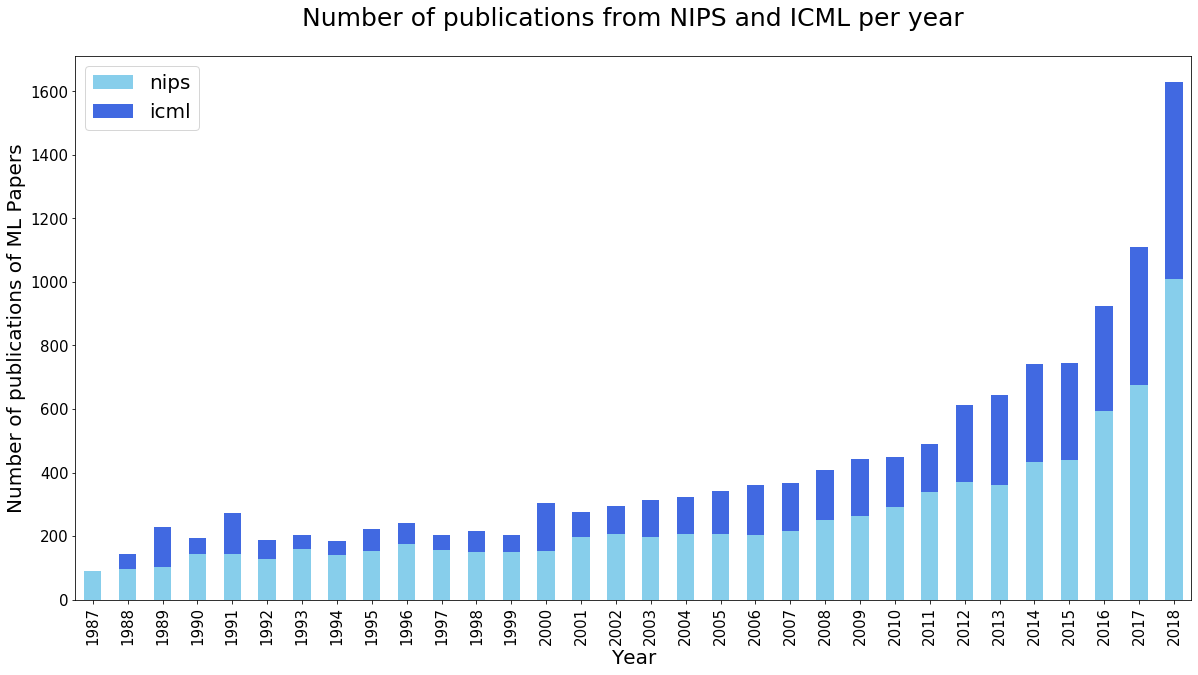

In [41]:
colors = ['skyblue', 'royalblue']
pivot_df.loc[:,['nips','icml']].plot.bar(stacked=True, color=colors, figsize=(20,10))
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Number of publications of ML Papers', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.title('Number of publications from NIPS and ICML per year',fontsize=25,pad=30)
plt.show()

- **Here, we clearly see that there is an increase in the number of both NIPS and ICML publications. However, it might also be considered that the given data does not represent the papers per conference level well due to a lack of publications or a lack of data on the publications made throughout the years.** 
- **We also see that there are no publications from the ICML conference paper in 1987. This again might be due to missing data or to the fact that there were no publications that year. A quick search on the source website dblp reveals that there were no records for ICML papers even though it is written that the conference was held in USA. ( 4th ML 1987: Irvine, CA, USA )**

***A3.4***

We now do web scraping for gather all the NIPS conference papers from the given link.

In [42]:
#Find the pages that we are going to access for scraping missing data
pages = []
for i,j in zip(range(1,32),range(1988,2019)):
    url = 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-' + str(i) + '-' + str(j)
    pages.append(url)

#One of the external links is different from all of others so we define it separately
url_last = 'https://papers.nips.cc//book/neural-information-processing-systems-1987'
pages.append(url_last)
pages

['https://papers.nips.cc//book/advances-in-neural-information-processing-systems-1-1988',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-2-1989',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-3-1990',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-4-1991',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-5-1992',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-6-1993',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-7-1994',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-8-1995',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-9-1996',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-10-1997',
 'https://papers.nips.cc//book/advances-in-neural-information-processing-systems-11-1998',
 'https:

In [43]:
#Preparing helper functions for web scraping

# To get all external links' pages
def all_links(pages):
    search_page = []
    paper_date = []
    paper_date_key = []
    for i in range(len(pages)):
        search_page.append(pages[i])
        #For nips cc book webage
        #Last 4 digits hold the papers' data information
        paper_date.append(pages[i][-4:])
        
        #For dblp data source
        # Between 9th and 5th digits from last hold the date information
        paper_date_key.append(pages[i][-9:-5])
    return search_page,paper_date, paper_date_key

# Make the request for obtaining the missing data
def get_missing_nips(search_page):
    page = requests.get(search_page)
    soup = BeautifulSoup(page.text, 'html.parser')
    # Pull all text from the main wrapper clearfix class
    nips_list = soup.find(class_='main wrapper clearfix')
    # Pull text from all instances of <ul> tag within main wrapper clearfix
    nips_list_items = nips_list.find_all('ul')
    return nips_list_items


In [44]:
#Saving the links' pages and dates
s_page,p_date,_ = all_links(pages)

result = []
for i in range(len(s_page)):
    result.append(get_missing_nips(s_page[i]))

In [45]:
#Example of what html page looks like when we click into `inspect` on the webpage
result[0]

[<ul>
 <li><a href="/paper/106-constraints-on-adaptive-networks-for-modeling-human-generalization">Constraints on Adaptive Networks for Modeling Human Generalization</a> <a class="author" href="/author/mark-a-gluck-144">Mark A. Gluck</a>, <a class="author" href="/author/m-pavel-164">M. Pavel</a>, <a class="author" href="/author/van-henkle-165">Van Henkle</a></li>
 <li><a href="/paper/139-an-optimality-principle-for-unsupervised-learning">An Optimality Principle for Unsupervised Learning</a> <a class="author" href="/author/terence-d-sanger-231">Terence D. Sanger</a></li>
 <li><a href="/paper/140-associative-learning-via-inhibitory-search">Associative Learning via Inhibitory Search</a> <a class="author" href="/author/david-h-ackley-232">David H. Ackley</a></li>
 <li><a href="/paper/175-fast-learning-in-multi-resolution-hierarchies">Fast Learning in Multi-Resolution Hierarchies</a> <a class="author" href="/author/john-moody-792">John Moody</a></li>
 <li><a href="/paper/134-efficient-paral

In [46]:
#We are looking for li tags since they represent conference papers
lis = [] 
list_of_all = []

for r in result:
    #r represents each web page that we are scraping
    for ul in r: 
        #ul tag represents where the papers and authors are located in a web page
        lis = []
        for li in ul.findAll('li'):
            lis.append(li)  
        list_of_all.append(lis)

#Scraping author names
child_list = []
final_author_list = []
list_of_all_author = []
#Scraping paper titles 
paper_title = []
final_paper_list = []

for y in list_of_all:
    final_author_list = []
    paper_title = []

    for li in y:
        #li tag represents each papers in html so we can extract the title with contents attribute
        titles = li.contents[0].text
        
        # We need to find all authors for a certain paper that's we can do with recursively looking for all children
        children = li.findChildren('a', {'class':'author'}, recursive=True)
        child_list = []
        for i in range(len(children)):
            child_name = children[i].get_text()
            child_list.append(child_name)
        final_author_list.append(child_list)
        paper_title.append(titles)
    list_of_all_author.append(final_author_list)    
    final_paper_list.append(paper_title)

In [47]:
#Preparing list of all papers with their authors' name and dates
p_all = []
it = range(len(list_of_all))

for i,j,k in zip(it, it, it):
    p_all.append({'title': final_paper_list[i],'authors': list_of_all_author[j], 'year':int(p_date[k])})

In [48]:
#Preparing Data frame for missing nips conference papers
list_of_nips = [pd.DataFrame(p_all[i]) for i in it]
df_nips = pd.concat(list_of_nips)
#Add conference columns to missing nips data
df_nips['conference'] = 'nips'
df_nips

,title,authors,year,conference
0,Constraints on Adaptive Networks for Modeling ...,"[Mark A. Gluck, M. Pavel, Van Henkle]",1988,nips
1,An Optimality Principle for Unsupervised Learning,[Terence D. Sanger],1988,nips
2,Associative Learning via Inhibitory Search,[David H. Ackley],1988,nips
3,Fast Learning in Multi-Resolution Hierarchies,[John Moody],1988,nips
4,Efficient Parallel Learning Algorithms for Neu...,"[Alan H. Kramer, Alberto Sangiovanni-Vincentelli]",1988,nips
...,...,...,...,...
85,Synchronization in Neural Nets,"[Jacques J. Vidal, John Haggerty]",1987,nips
86,Invariant Object Recognition Using a Distribut...,"[Harry Wechsler, George Lee Zimmerman]",1987,nips
87,Learning in Networks of Nondeterministic Adapt...,[Richard C. Windecker],1987,nips
88,Strategies for Teaching Layered Networks Class...,"[Ben S. Wittner, John S. Denker]",1987,nips


- **We realize that via the given url `https://papers.nips.cc/`, we can't find the unique dblp key id for each of the papers. We could create them ourselves by following the same format as in the given dataset, but instead, below, we did web scraping on our main data source which is: `https://dblp.uni-trier.de` since from there we can take the unique keys for each paper. Then, we can join this dblp key with our dataframe above `df_nips`.**

We now follow the same steps as above but web scraping for `https://dblp.uni-trier.de`:

In [49]:
#Find the pages that we are going to access for scraping missing data
pages_id = []
for i in range(1987,2019):
    url = 'https://dblp.uni-trier.de/db/conf/nips/nips' + str(i) + '.html'
    pages_id.append(url)

pages_id

['https://dblp.uni-trier.de/db/conf/nips/nips1987.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1988.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1989.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1990.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1991.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1992.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1993.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1994.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1995.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1996.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1997.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1998.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips1999.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips2000.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips2001.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips2002.html',
 'https://dblp.uni-trier.de/db/conf/nips/nips2003.html',
 'https://dblp.uni-trier.de/db/

In [50]:
# Make the request for obtaining the missing data
def get_missing_nips_dblp(search_page):
    page = requests.get(search_page)
    soup = BeautifulSoup(page.text, 'html.parser')
    #For dblp data source
    # Pull all instances of <ul> tag within publ-list class
    key_list = soup.find_all('ul', {'class': 'publ-list'})
    return key_list


In [51]:
#Saving the links' pages and dates
s_page_key,_, p_date_key = all_links(pages_id)

result_key = []
for i in range(len(s_page_key)):
    result_key.append(get_missing_nips_dblp(s_page_key[i]))

In [52]:
#Example of what the html page looks like when we click into `inspect` on the webpage
result_key[0]

[<ul class="publ-list"><li class="entry editor" id="conf/nips/1987" itemscope="" itemtype="http://schema.org/Book"><link href="https://dblp.uni-trier.de/rdf/schema-2017-04-18#Publication" itemprop="additionalType"/><div class="box"><img alt="" src="https://dblp.uni-trier.de/img/n.png" title="Editorship"/></div><nav class="publ"><ul><li class="drop-down"><div class="head"><a href="http://papers.nips.cc/book/neural-information-processing-systems-1987"><img alt="" class="icon" itemprop="image" src="https://dblp.uni-trier.de/img/paper.dark.hollow.16x16.png"/></a></div><div class="body"><p><b>view</b></p><ul><li class="ee"><a href="http://papers.nips.cc/book/neural-information-processing-systems-1987" itemprop="url"><img alt="" class="icon" src="https://dblp.uni-trier.de/img/paper.dark.16x16.png"/>electronic edition @ nips.cc</a></li></ul><span class="Z3988" title="ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fdblp.org%3Aconf/nips/1987&amp;rft.au=Dana+Z.+Anderson&amp;rft.btitle=Neural+Informa

In [53]:
#We are looking for li tags since they represent conference papers
lis_ = [] 
list_of_all_ = []
#Gathering dblp_key of NIPS papers
key_dblp = []
#Gathering titles of NIPS papers
titles_ = []
final_titles_ = []
#Gathering authors of NIPS papers
authors_ = []
final_authors_ = []

for r in result_key:
    for ul in r:
        lis_ = []
        #li tags with class 'entry inproceedings' hold the papers information
        for li in ul.find_all('li', {'class':'entry inproceedings'}):
            lis_.append(li)
        list_of_all_.append(lis_) 
        
for i in range(len(list_of_all_)):
    for li in list_of_all_[i]:
        # id attribute in li tags hold the dblp_key information
        id_key = li['id']
        # span with attrs= {'class':"title" ,'itemprop' :"name"} hold the NIPS papers' title information
        spans = li.findAll('span', attrs= {'class':"title" ,'itemprop' :"name"} )
        titles_ = []
        for span in spans:
            span_t = span.text
            titles_.append(span_t)
        # span with attrs= {'itemprop':"author" , 'itemprop' :"name"} hold the NIPS papers' title information
        spans_ = li.findAll('span', attrs= {'itemprop':"author" , 'itemprop' :"name"} )
        authors_ = []
        for span in spans_:
            span_t = span.text
            authors_.append(span_t)
        final_authors_.append(authors_[:-1])
        final_titles_.append(titles_)
        key_dblp.append(id_key)

In [54]:
#Preparing a list of all papers with their titles and authors' name 
flat_titles = [item for sublist in final_titles_ for item in sublist]
flat_ids = [item for item in key_dblp]
flat_authors = [item for item in final_authors_]

p_all_dblp = []
it_ = range(len(key_dblp))

for i,j,t in zip(it_, it_, it_):
    p_all_dblp.append({'id': flat_ids[i],
                       'authors': flat_authors[j],
                       'title':flat_titles[t]})

In [55]:
#Preparing Data frame for missing NIPS conference papers
list_of_nips_dblp = [pd.DataFrame(p_all_dblp[i]) for i in it_]
df_nips_dblp = pd.concat(list_of_nips_dblp)
df_nips_dblp = df_nips_dblp.reset_index(drop=True)
df_nips_dblp.head()

,id,authors,title
0,conf/nips/Abu-Mostafa87,Yaser S. Abu-Mostafa,Connectivity Versus Entropy.
1,conf/nips/AlspectorAHS87,Joshua Alspector,Stochastic Learning Networks and their Electro...
2,conf/nips/AlspectorAHS87,Robert B. Allen,Stochastic Learning Networks and their Electro...
3,conf/nips/AlspectorAHS87,Victor Hu,Stochastic Learning Networks and their Electro...
4,conf/nips/AlspectorAHS87,Srinagesh Satyanarayana,Stochastic Learning Networks and their Electro...


We need to add a `date` column to the dataframe and we will do that by looking at the pattern in the id values in the dataframe. We will apply the same logic as the one from part A.3.2. 
- Using lambda expressions
    - We add 2000 or 1900 to the two digit numbers that remain in the dataframe depending on which is the more realistic choice.
- However, we observed that in `id` column, there are some different patterns in the last two digits such as `['0a','1a','2a','3a','4a','5a','6a','7a','8a','9a']`. For those rows, we will take the last 3 digits and we will discard the last character 'a' to be able to apply the same logic as above.

In [56]:
print(set([df_nips_dblp['id'][i][-2:] for i in range(len(df_nips_dblp.id.unique()))]))

{'87', '07', '01', '95', '90', '7a', '94', '97', '0a', '3a', '08', '93', '98', '1a', '03', '2a', '05', '5a', '9a', '99', '92', '00', '02', '04', '4a', '91', '6a', '88', '8a', '06', '89'}


In [57]:
#Prepare dataframe for missing nips data of 2010 and 2011 from the DBLP source data
pattern = ['0a','1a','2a','3a','4a','5a','6a','7a','8a','9a']

df_nips_dblp['year_cat'] = [df_nips_dblp.id[i][-2:] if df_nips_dblp['id'][i][-2:] not in pattern\
                            else df_nips_dblp.id[i][-3:-1] for i in range(len(df_nips_dblp))]
df_nips_dblp['year'] = df_nips_dblp['year_cat'].apply(lambda x: int(x) + 2000 if int(x) < 20 else int(x) + 1900)
df_nips_dblp = df_nips_dblp.drop( 'year_cat', axis=1)

#Drop extra terms and duplicates
df_nips_dblp = df_nips_dblp.drop(['authors'], axis=1)
df_nips_dblp = df_nips_dblp.drop_duplicates()
df_nips_dblp = df_nips_dblp.reset_index(drop=True)
df_nips_dblp.head()

,id,title,year
0,conf/nips/Abu-Mostafa87,Connectivity Versus Entropy.,1987
1,conf/nips/AlspectorAHS87,Stochastic Learning Networks and their Electro...,1987
2,conf/nips/Atiya87,Learning on a General Network.,1987
3,conf/nips/AtlasHM87,An Artificial Neural Network for Spatio-Tempor...,1987
4,conf/nips/BaldiV87,On Properties of Networks of Neuron-Like Eleme...,1987


In [58]:
# Remove the '.' at the end of the title information so as to make a join on them to gather the dblp_key later
df_nips_dblp['title_cat'] = [df_nips_dblp.title[i][:-1] if df_nips_dblp['title'][i][-1:] == '.'\
                             else df_nips_dblp.title[i] for i in range(len(df_nips_dblp))]

In [59]:
df_nips_dblp = df_nips_dblp.drop(('title'), axis = 1)
df_nips_dblp = df_nips_dblp.reset_index()
df_nips_dblp = df_nips_dblp.rename(columns={'title_cat': 'title'})

In [60]:
#Completing missing data frames with their unique dblp_key 
df_left =  pd.merge(df_nips, df_nips_dblp, on='title', how='left')
df_left = df_left[['title', 'authors', 'year_x','conference','id']]
df_left = df_left.rename(columns={'year_x': 'year'})
df_left.head()

,title,authors,year,conference,id
0,Constraints on Adaptive Networks for Modeling ...,"[Mark A. Gluck, M. Pavel, Van Henkle]",1988,nips,conf/nips/GluckPH88
1,An Optimality Principle for Unsupervised Learning,[Terence D. Sanger],1988,nips,conf/nips/Sanger88
2,Associative Learning via Inhibitory Search,[David H. Ackley],1988,nips,conf/nips/Ackley88
3,Fast Learning in Multi-Resolution Hierarchies,[John Moody],1988,nips,conf/nips/Moody88
4,Efficient Parallel Learning Algorithms for Neu...,"[Alan H. Kramer, Alberto Sangiovanni-Vincentelli]",1988,nips,conf/nips/KramerS88


In [61]:
#Converting authors to string and removing some special characters
a = [str(x) for x in df_left['authors']]

df_left['authors_str'] = a

df_left['authors_str'] = df_left['authors_str'].str.replace("[", "")
df_left['authors_str'] = df_left['authors_str'].str.replace("]", "")
df_left['authors_str'] = df_left['authors_str'].str.replace("\"", "")

df_left = df_left.drop(('authors'), axis = 1)
df_left = df_left.rename(columns={'authors_str': 'authors'})
df_left.head()

,title,year,conference,id,authors
0,Constraints on Adaptive Networks for Modeling ...,1988,nips,conf/nips/GluckPH88,"'Mark A. Gluck', 'M. Pavel', 'Van Henkle'"
1,An Optimality Principle for Unsupervised Learning,1988,nips,conf/nips/Sanger88,'Terence D. Sanger'
2,Associative Learning via Inhibitory Search,1988,nips,conf/nips/Ackley88,'David H. Ackley'
3,Fast Learning in Multi-Resolution Hierarchies,1988,nips,conf/nips/Moody88,'John Moody'
4,Efficient Parallel Learning Algorithms for Neu...,1988,nips,conf/nips/KramerS88,"'Alan H. Kramer', 'Alberto Sangiovanni-Vincent..."


In [62]:
#Complete the paper-centric dataframe by scraping the full NIPS data
df_completed = pd.concat([df,df_left])
df_completed

,authors,conference,id,title,year
0,"'Yoshinori Kuno', 'Yasukazu Okamoto', 'Satoshi...",iccv,conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990
1,"'Sundar Vedula', 'Simon Baker', 'Peter Rander'...",iccv,conf/iccv/VedulaBRCK99,Three-Dimensional Scene Flow.,1999
2,"'Étienne Mémin', 'Patrick Pérez'",iccv,conf/iccv/MeminP99,Fluid Motion Recovery by Coupling Dense and Pa...,1999
3,"'Sven J. Dickinson', 'Alex Pentland', 'Azriel ...",iccv,conf/iccv/DickinsonPR90,Qualitative 3-D shape reconstruction using dis...,1990
4,"'Avi Singh', 'Larry Yang', 'Sergey Levine'",iccv,conf/iccv/SinghYL17,GPLAC: Generalizing Vision-Based Robotic Skill...,2017
...,...,...,...,...,...
8245,"'Jacques J. Vidal', 'John Haggerty'",nips,conf/nips/VidalH87,Synchronization in Neural Nets,1987
8246,"'Harry Wechsler', 'George Lee Zimmerman'",nips,conf/nips/WechslerZ87,Invariant Object Recognition Using a Distribut...,1987
8247,'Richard C. Windecker',nips,conf/nips/Windecker87,Learning in Networks of Nondeterministic Adapt...,1987
8248,"'Ben S. Wittner', 'John S. Denker'",nips,conf/nips/WittnerD87,Strategies for Teaching Layered Networks Class...,1987


We need to eliminate the rows that are already exist in our dataframe in order to get rid of the duplicate values.

In [63]:
df_completed = df_completed.drop_duplicates()
df_completed.head()

,authors,conference,id,title,year
0,"'Yoshinori Kuno', 'Yasukazu Okamoto', 'Satoshi...",iccv,conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990
1,"'Sundar Vedula', 'Simon Baker', 'Peter Rander'...",iccv,conf/iccv/VedulaBRCK99,Three-Dimensional Scene Flow.,1999
2,"'Étienne Mémin', 'Patrick Pérez'",iccv,conf/iccv/MeminP99,Fluid Motion Recovery by Coupling Dense and Pa...,1999
3,"'Sven J. Dickinson', 'Alex Pentland', 'Azriel ...",iccv,conf/iccv/DickinsonPR90,Qualitative 3-D shape reconstruction using dis...,1990
4,"'Avi Singh', 'Larry Yang', 'Sergey Levine'",iccv,conf/iccv/SinghYL17,GPLAC: Generalizing Vision-Based Robotic Skill...,2017


- **Redo the plots of steps A3.2 after fixing the missing data issue:**

In [64]:
#Group by the year and get the number of publications by year
count_per_year = df_completed.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
count_per_year = count_per_year.sort_values(by='number_publications', ascending=False)
count_per_year.reset_index(inplace=True, drop=True)
count_per_year

,year,number_publications
0,2018,9865
1,2017,7811
2,2015,6461
3,2016,6452
4,2013,5231
5,2011,4940
6,2014,4905
7,2012,4770
8,2007,4510
9,2010,4283


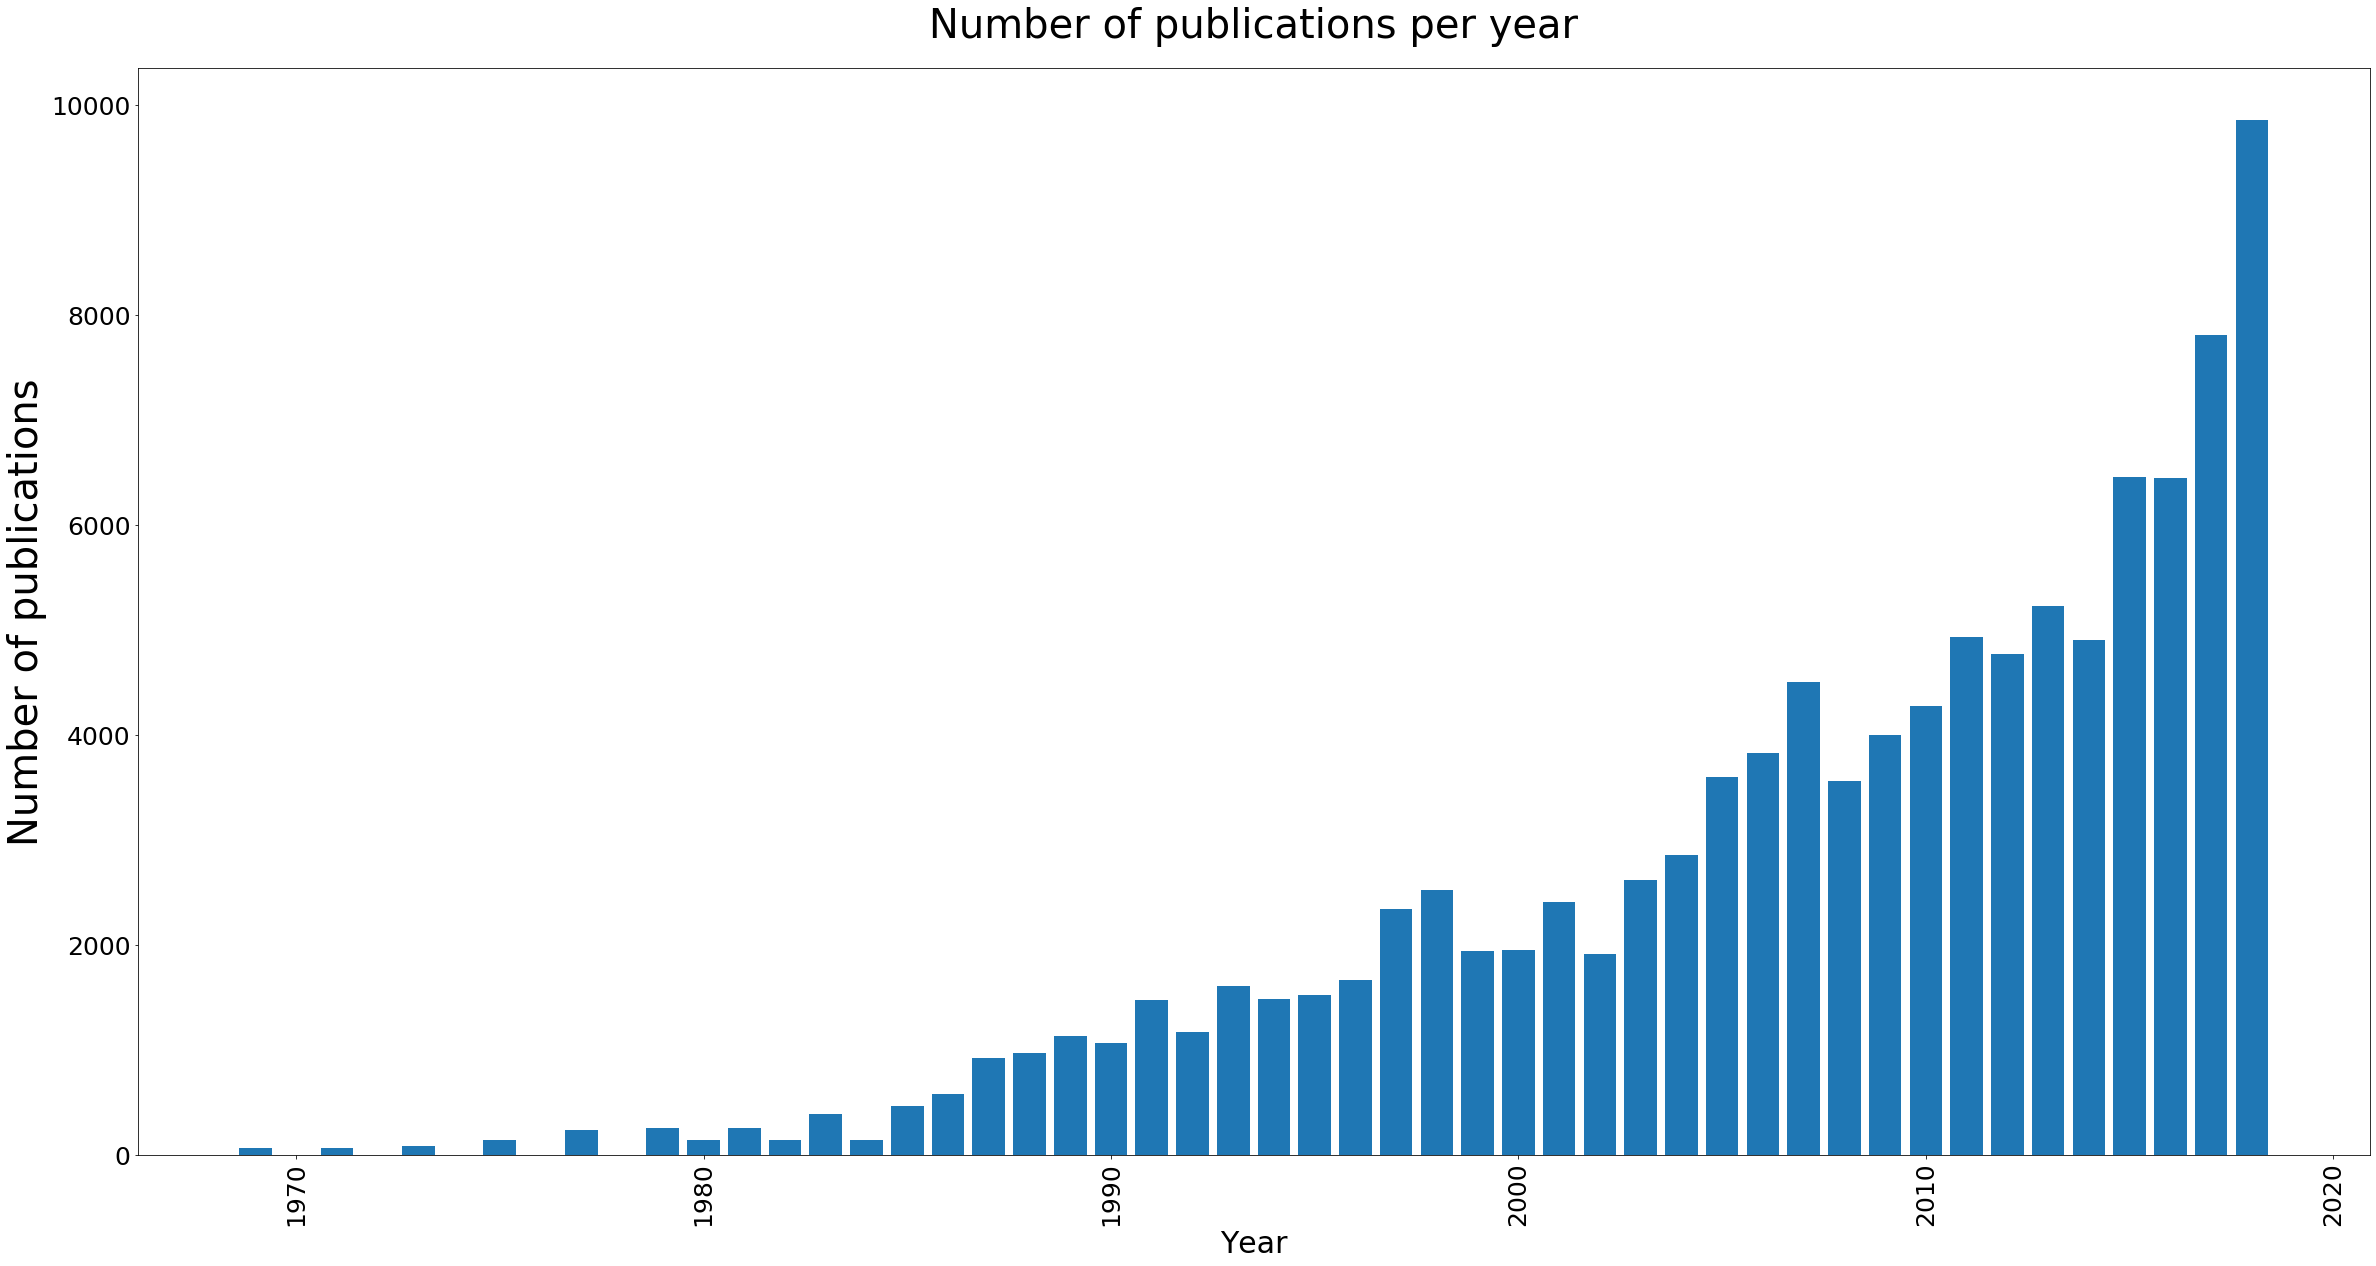

In [65]:
plt.figure(figsize=(40,20))
plt.bar(count_per_year.year[:60],count_per_year.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications',fontsize=40)
plt.title('Number of publications per year',fontsize=40,pad=30)
plt.show()

After adding other missing data into our data frame we now have more data compared to the number of publications we had in A3.2.

- **Redo the plots of steps A3.3 after fixing the missing data issue:**

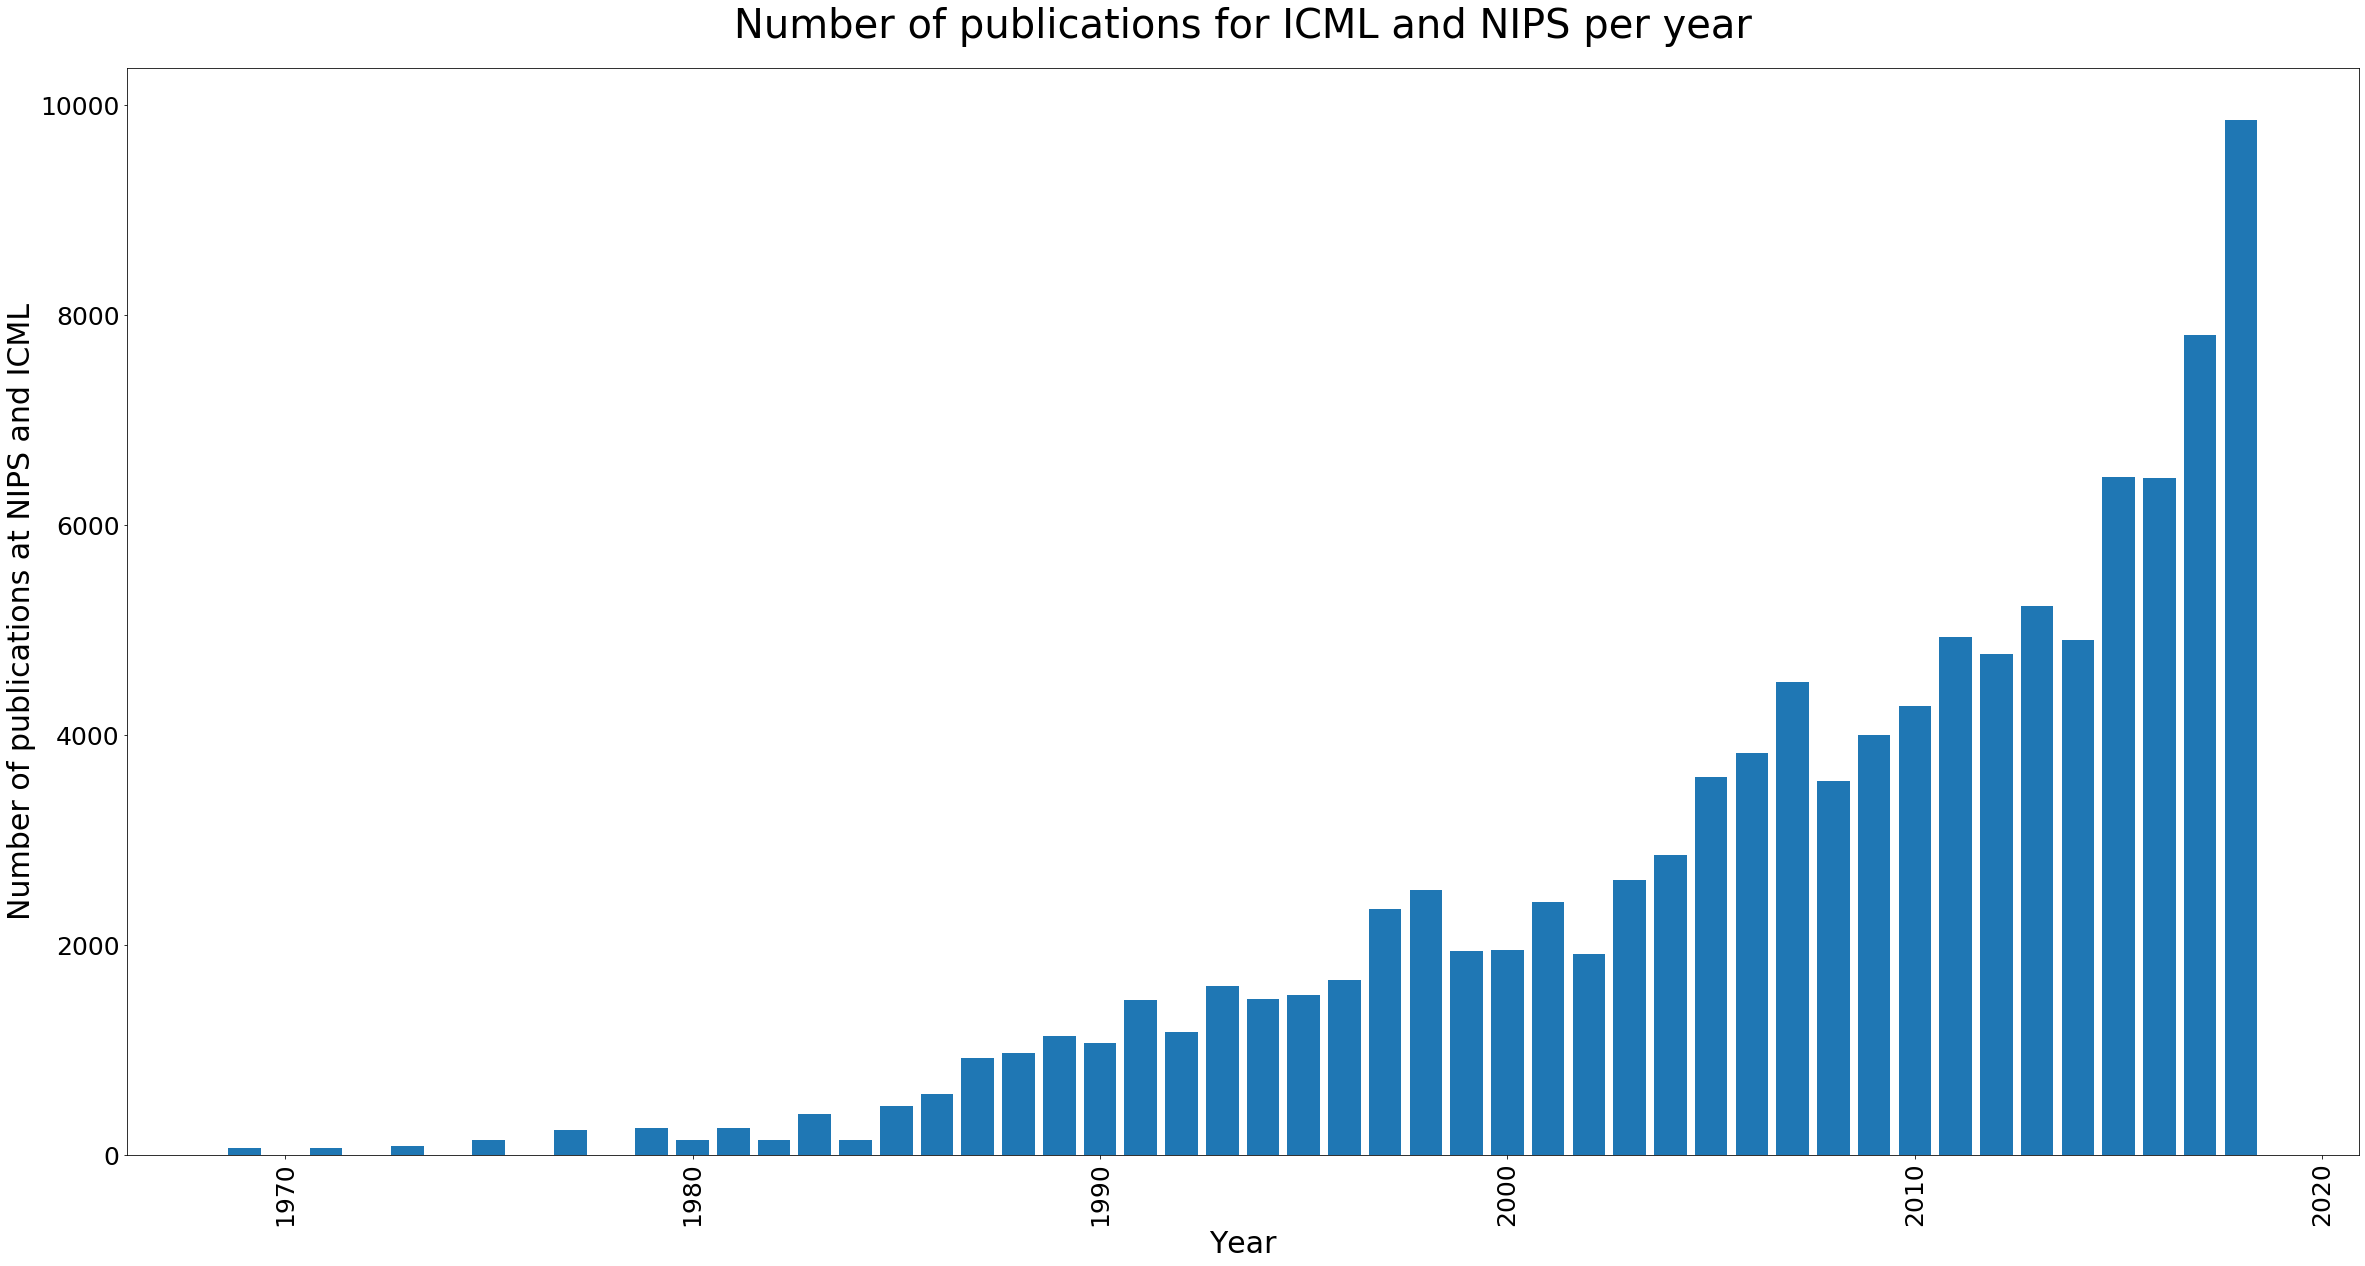

In [66]:
#List of interested ML papers
mlconf_ = ['icml', 'nips']
df_ml_ = df_completed[df_completed['conference'].str.lower().isin(mlconf_)]
df_ml_.reset_index(inplace=True, drop=True)

plt.figure(figsize=(40,20))
plt.bar(count_per_year.year[:60],count_per_year.number_publications[:60])
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of publications at NIPS and ICML',fontsize=30)
plt.title('Number of publications for ICML and NIPS per year',fontsize=40,pad=30)
plt.show()

In [67]:
count_per_conf = df_ml_.groupby(['conference']).count().reset_index()[['conference','id']].rename(columns={"id": "number_publications"})
count_per_conf = count_per_conf.sort_values(by='number_publications', ascending=False)
count_per_conf.reset_index(inplace=True, drop=True)
count_per_conf

,conference,number_publications
0,nips,16147
1,icml,4977


Here, we see that the number of NIPS papers has increased to a number of 16147.

In [68]:
count_per_conf_per_year = df_ml_.groupby(['conference','year']).count().reset_index()[['conference','year','id']].rename(columns={"id": "number_publications"})
count_per_conf_per_year = count_per_conf_per_year.sort_values(by='number_publications', ascending=False)
count_per_conf_per_year.reset_index(inplace=True, drop=True)
count_per_conf_per_year

,conference,year,number_publications
0,nips,2018,1997
1,nips,2017,1334
2,nips,2016,1148
3,nips,2015,835
4,nips,2014,830
...,...,...,...
58,icml,1990,50
59,icml,1988,49
60,icml,1997,48
61,icml,1994,45


In [69]:
#Preparing pivot data for plotting
pivot_df = count_per_conf_per_year.pivot(index='year', columns='conference', values='number_publications')

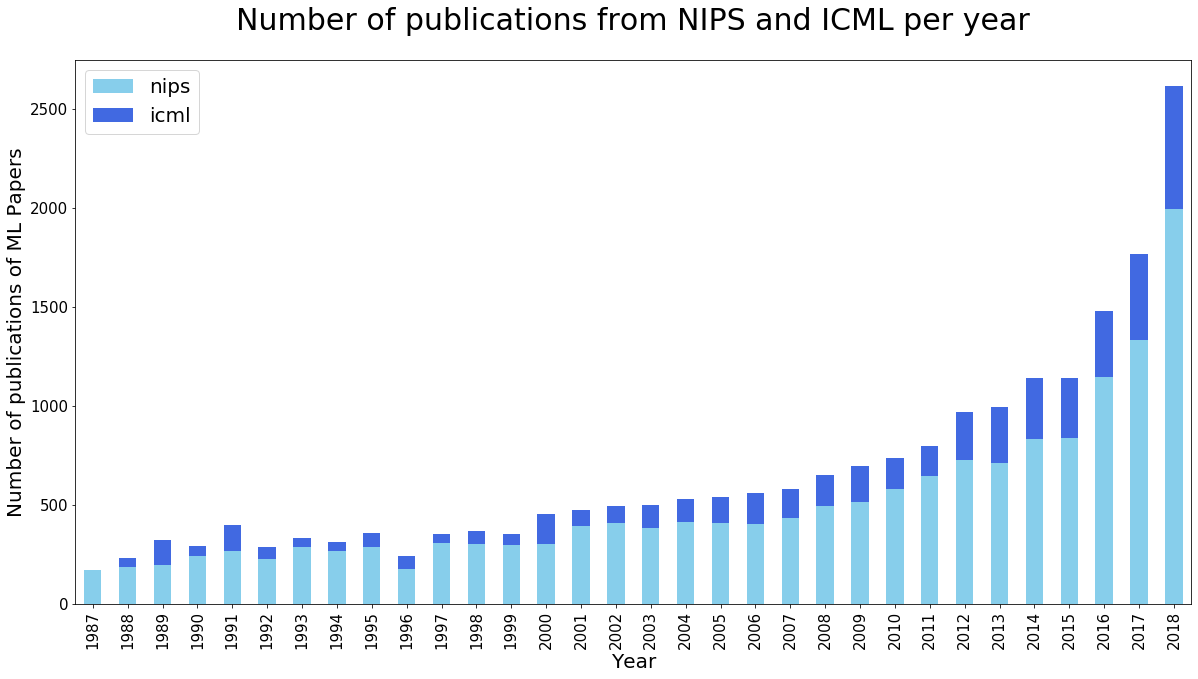

In [70]:
colors = ['skyblue', 'royalblue']
pivot_df.loc[:,['nips','icml']].plot.bar(stacked=True, color=colors, figsize=(20,10))
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Number of publications of ML Papers', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 20)
plt.title('Number of publications from NIPS and ICML per year',fontsize=30,pad=30)
plt.show()

- Here, we now see the missing NIPS data is completed and follows the same increasing trend throughout years.
- Below, we show the difference in the number of NIPS conference papers after doing webscraping. It is clear that the number of NIPS papers has increased by 7752 in the dataframe.

In [71]:
nips_before_webscraping = df_ml[df_ml['conference'].str.lower()=='nips']
count_nips_before_webscraping = nips_before_webscraping.drop(['authors','conference','title'],axis=1).groupby(['year']).count().rename(columns={"id": "number_publications_before"})
count_nips_before_webscraping = count_nips_before_webscraping.sort_values(by='number_publications_before', ascending=False) 

In [72]:
nips_after_webscraping = df_completed[df_completed['conference'].str.lower()=='nips']
count_nips_after_webscraping = nips_after_webscraping.drop(['authors','conference','title'],axis=1).groupby(['year']).count().rename(columns={"id": "number_publications_after"})
count_nips_after_webscraping = count_nips_after_webscraping.sort_values(by='number_publications_after', ascending=False) 

In [73]:
comparison_before_after_nips = pd.merge(count_nips_before_webscraping, count_nips_after_webscraping, on='year', how='left').fillna('')
comparison_before_after_nips['difference'] = comparison_before_after_nips['number_publications_after'] - comparison_before_after_nips['number_publications_before']
comparison_before_after_nips = comparison_before_after_nips.sort_values(by='year', ascending=False)
comparison_before_after_nips

,number_publications_before,number_publications_after,difference
year,,,
2018,1009,1997,988
2017,677,1334,657
2016,594,1148,554
2015,440,835,395
2014,432,830,398
2013,360,710,350
2012,370,727,357
2011,338,643,305
2010,291,578,287


In [74]:
print('The number of increase in the NIPS paper is: ', sum(comparison_before_after_nips['difference']))

The number of increase in the NIPS paper is:  7752


Before going any further for the later use of author-centric data, we will propagate what we have done by web scraping to author-centric dataframe.

In [75]:
#Expand the author names to new columns and stack them, include id in dataframe for later merge
df_left_expanded = pd.DataFrame(df_left.authors.str.split(',').tolist(), index = df_left.id).stack(dropna=True)
df_left_expanded = df_left_expanded.reset_index([0, 'id'])
df_left_expanded.columns = ['id', 'author']

#Drop the old 'authors' column
df_left.drop('authors', axis=1, inplace=True)

#Inner join of the authors names and the papers details for the merge
df_left_author = pd.merge(df_left_expanded, df_left, on='id')

#Remove trailing and leading whitespaces from the authors' names
df_left_author['author'] = df_left_author['author'].str.strip()
df_left_author['author'] = df_left_author.author.str[1:-1]

#Display the author-centric DataFrame 
df_left_author.head()

,id,author,title,year,conference
0,conf/nips/GluckPH88,Mark A. Gluck,Constraints on Adaptive Networks for Modeling ...,1988,nips
1,conf/nips/GluckPH88,M. Pavel,Constraints on Adaptive Networks for Modeling ...,1988,nips
2,conf/nips/GluckPH88,Van Henkle,Constraints on Adaptive Networks for Modeling ...,1988,nips
3,conf/nips/Sanger88,Terence D. Sanger,An Optimality Principle for Unsupervised Learning,1988,nips
4,conf/nips/Ackley88,David H. Ackley,Associative Learning via Inhibitory Search,1988,nips


In [76]:
#Complete the author-centric dataframe by scraping the full NIPS data
df_completed_author = pd.concat([df_authors,df_left_author])
#Dropping rows with any missing values from the complete dataframe
df_completed_author = df_completed_author.dropna(how='any')
df_completed_author.head()

,author,conference,id,title,year
0,Yoshinori Kuno,iccv,conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990
1,Yasukazu Okamoto,iccv,conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990
2,Satoshi Okada,iccv,conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990
3,Sundar Vedula,iccv,conf/iccv/VedulaBRCK99,Three-Dimensional Scene Flow.,1999
4,Simon Baker,iccv,conf/iccv/VedulaBRCK99,Three-Dimensional Scene Flow.,1999


In [77]:
df_completed_author = df_completed_author.drop_duplicates()

- After adding NIPS missing data to our dataset, we completed the given dataset with NIPS in the author-centric dataframe.

In [78]:
#Saving paper_centric and author_centric dataframe as pickle for further use.
df_completed.to_pickle("df_paperCentric_pickle")
df_completed_author.to_pickle("df_authorCentric_pickle")

### A4. Author activity

For each author, calculate their normalized paper count, defined as the total number of papers divided by the author’s period of activity. An author’s period of activity is defined as the number of years between the earliest and latest papers of this author. Plot the distribution of the normalized paper count. What is the appropriate scale for the axes? Does the distribution (roughly) follow a particular law, and if yes, which one?

In [79]:
df_completed_author = pd.read_pickle('df_authorCentric_pickle')
author_activity = df_completed_author.groupby(['author']).agg({'year': ['min', 'max'], 'id': ['count']})
author_activity['years'] = author_activity['year']['max'] - author_activity['year']['min'] + 1
author_activity['paper_count'] = author_activity['id']['count'] / author_activity['years']

max author activity =  10.5 min author activity =  0.05128205128205128


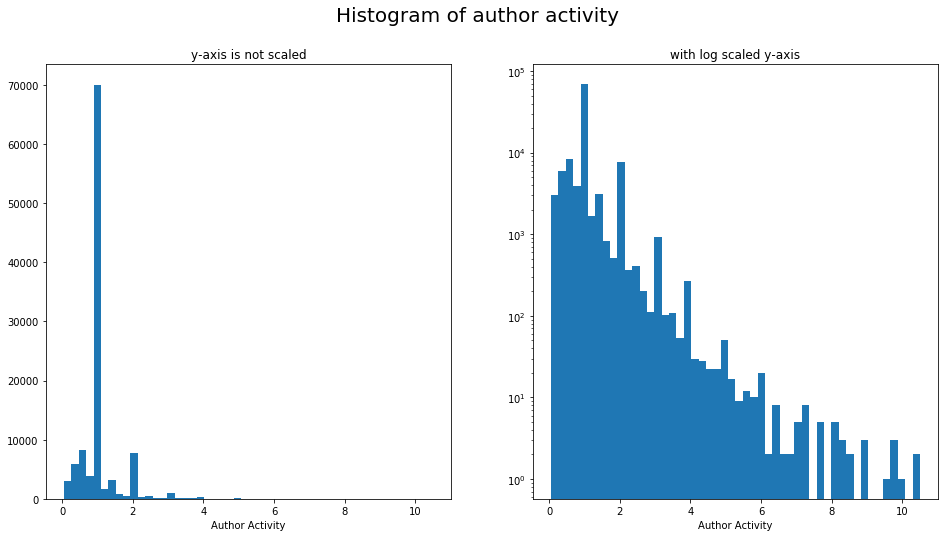

In [80]:
print("max author activity = ", author_activity['paper_count'].max(), "min author activity = ", author_activity['paper_count'].min())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(author_activity['paper_count'], bins=50)
axes[0].set_xlabel('Author Activity')
axes[0].set_title('y-axis is not scaled')

axes[1].hist(author_activity['paper_count'], bins=50)
axes[1].set_yscale('log')
axes[1].set_xlabel('Author Activity')
axes[1].set_title('with log scaled y-axis')

fig.suptitle('Histogram of author activity', size=20)
plt.show()

**The histogram is heavy tailed as we can see and we can hardly see the Author Activity count for values greater than 2 which makes the graph uninterpretable. Hence a logarithmic scale of the y-axis made sense.**


**We can see from the log scaled y axis histogram that small values of Author Activity are more common among authors, which makes sence. (It is more common that an author publishes 1 paper per year than 10 papers per year)**




* Let's now examine the statistical properties of the paper-count data

In [81]:
author_activity['paper_count'].describe()

count    107919.000000
mean          1.054853
std           0.534665
min           0.051282
25%           1.000000
50%           1.000000
75%           1.000000
max          10.500000
Name: paper_count, dtype: float64

#  

* Now we are going to examine the histogram of the log-valued data to see if we can get any insights on the distribution it follows.

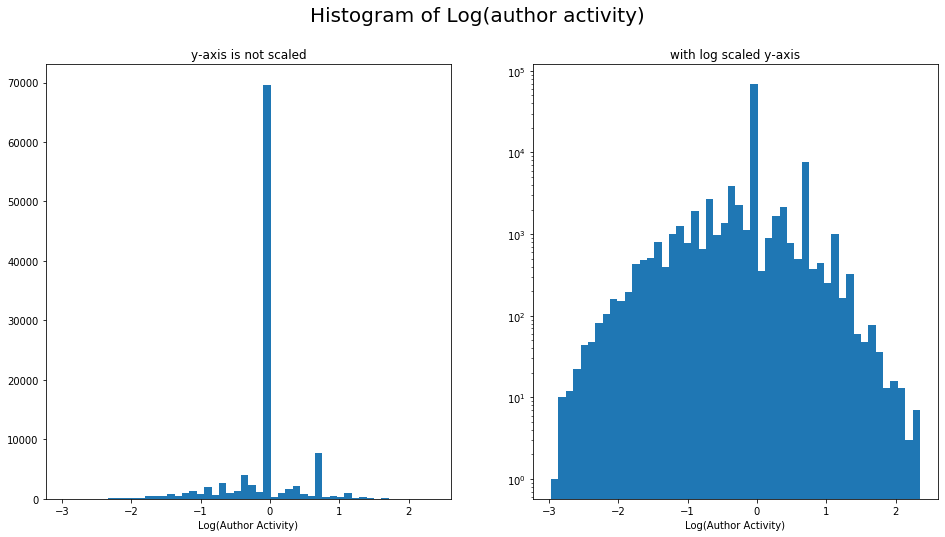

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
log_data = np.log(author_activity['paper_count'])

axes[0].hist(log_data, bins=50)
axes[0].set_xlabel('Log(Author Activity)')
axes[0].set_title('y-axis is not scaled')

axes[1].hist(log_data, bins=50)
axes[1].set_yscale('log')
axes[1].set_xlabel('Log(Author Activity)')
axes[1].set_title('with log scaled y-axis')

fig.suptitle('Histogram of Log(author activity)', size=20)
plt.show()

**We clearly see that the histogram which was right skewed becomes left skewed, this suggests that our variable follows a Gamma distribution. We are going to verify our hypothesis below.**

* Now we try to fit a gamma distribution with the right parameters.

gamma_alpha:  6.229251919491885 gamma_loc:  -0.12960034317231073 gamma_scale:  0.1901438172812058


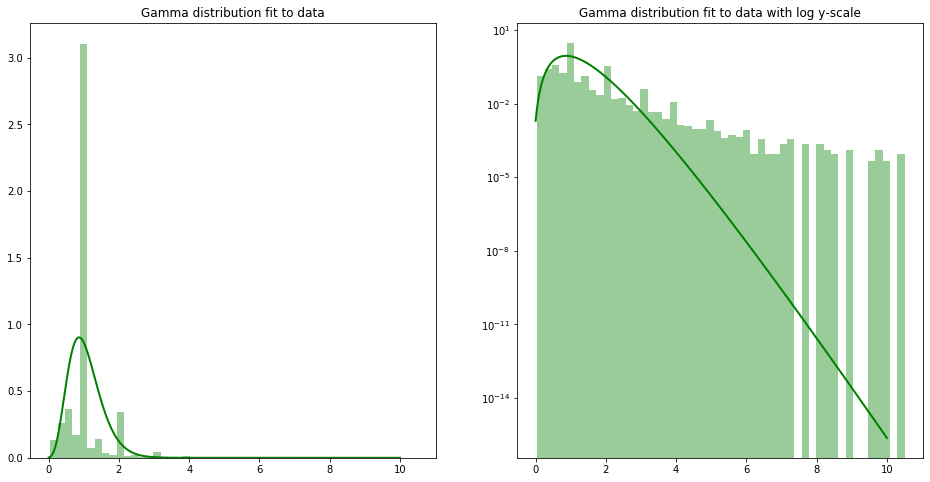

In [83]:
gamma_alpha, gamma_loc, gamma_scale = gamma.fit(author_activity['paper_count'])
print("gamma_alpha: ",gamma_alpha,"gamma_loc: ", gamma_loc,"gamma_scale: ", gamma_scale)
x = np.arange(0,10,0.001)
gamma_pdf = gamma.pdf(x ,gamma_alpha, loc = gamma_loc, scale = gamma_scale)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('Gamma distribution fit to data')
axes[0].plot(x, gamma_pdf, color='green', linewidth=2)
axes[0].hist(author_activity['paper_count'], density=1, bins=50, color='green',alpha=.4)
axes[1].set_title('Gamma distribution fit to data with log y-scale')
plt.yscale('log')
axes[1].plot(x, gamma_pdf, color='green', linewidth=2)
axes[1].hist(author_activity['paper_count'], density=1, bins=50, color='green',alpha=.4)

plt.show()

* We can see that the density of the gamma distribution roughly resembles the distribution we got for the paper count data.

shape:  0.30148666713618527 loc:  -0.47153570643417964 scale:  1.4552149009761872


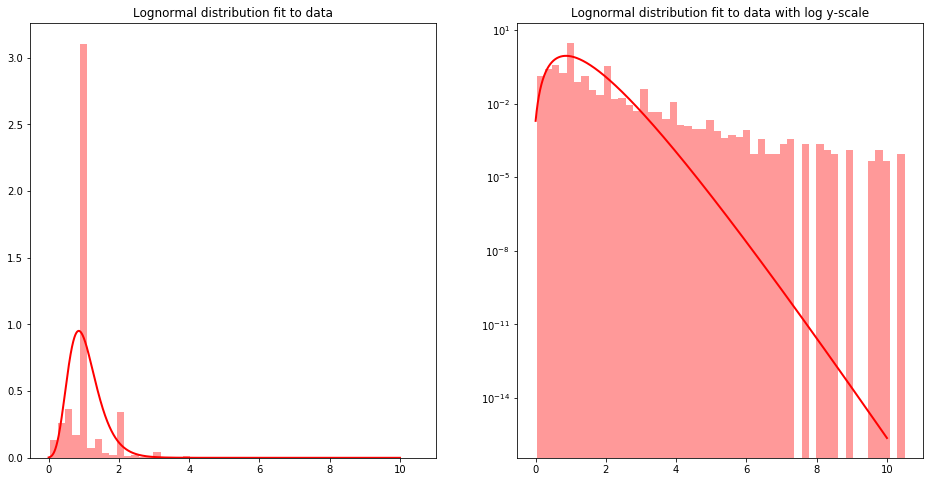

In [84]:
shape, loc, scale  = lognorm.fit(author_activity['paper_count'])
print("shape: ",shape,"loc: ", loc,"scale: ", scale)
x = np.arange(0,10,0.001)
lognorm_pdf = lognorm.pdf(x ,shape, loc, scale)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('Lognormal distribution fit to data')
axes[0].plot(x, lognorm_pdf, color='red', linewidth=2)
axes[0].hist(author_activity['paper_count'], density=1, bins=50, color='red',alpha=.4)
axes[1].set_title('Lognormal distribution fit to data with log y-scale')
plt.yscale('log')
axes[1].plot(x, gamma_pdf, color='red', linewidth=2)
axes[1].hist(author_activity['paper_count'], density=1, bins=50, color='red',alpha=.4)

plt.show()

* We can see that the density of the lognormal distribution roughly resembles the distribution we got for the paper count data.

In [85]:
chi2.fit(author_activity['paper_count'])

(12.458465160807439, -0.12959655770401685, 0.09507190649715995)

df:  12.458465160807439 loc:  -0.12959655770401685 scale:  0.09507190649715995


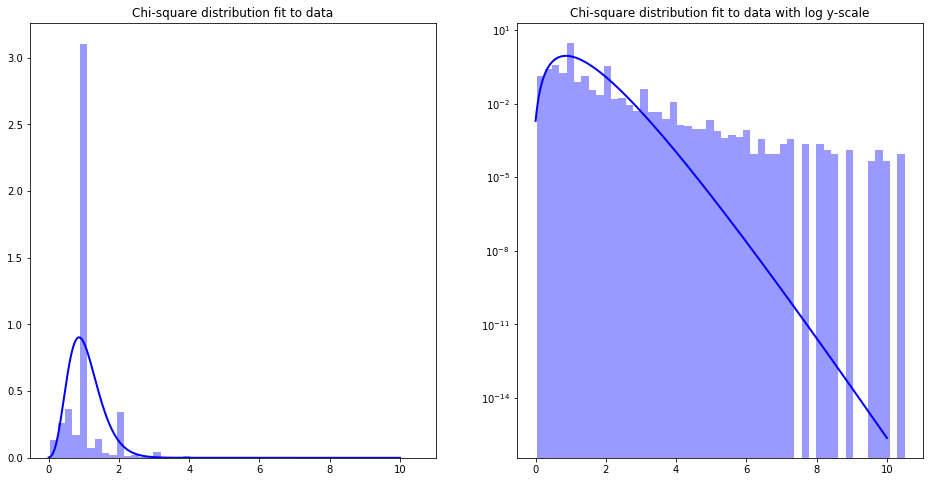

In [86]:
df, loc, scale  = chi2.fit(author_activity['paper_count'])
print("df: ",df,"loc: ", loc,"scale: ", scale)
x = np.arange(0,10,0.001)
chi2_pdf = chi2.pdf(x ,df, loc, scale)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('Chi-square distribution fit to data')
axes[0].plot(x, chi2_pdf, color='blue', linewidth=2)
axes[0].hist(author_activity['paper_count'], density=1, bins=50, color='blue',alpha=.4)
axes[1].set_title('Chi-square distribution fit to data with log y-scale')
plt.yscale('log')
axes[1].plot(x, chi2_pdf, color='blue', linewidth=2)
axes[1].hist(author_activity['paper_count'], density=1, bins=50, color='blue',alpha=.4)

plt.show()

* We can see that the density of the chi-squared distribution roughly resembles the distribution we got for the paper count data. This makes sense as the chi-squared distribution is usually used to represent the sum of averages and the normalized paper-count can be seen as the average number of papers per year for every author.

## Task B. Ranking authors

As you may know, there exist rankings for universities, which represent their relative quality and are used to compare the performance of different universities. In the same vein, there are rankings for conferences and journals, which represent the importance and impact of each conference or journal, and therefore allow for approximate comparisons. In this part, you will rank authors based on different aspects of their research output.

### B1. A Naïve Score

In the absence of citation counts, it is hard to objectively rank the authors based on the impact of their contributions to the field of AI research. A naïve way would be to rank them based on their number of published papers. Obtain such a ranking and analyze your result. Identify and explain some obvious limitations of this scheme.

In [87]:
#We group the papers by author
df_authors_grouped=df_authors.groupby('author').agg({'id': 'count'})
df_authors_grouped.rename(columns={"author": "Author", "id": "Number of Papers"}, inplace=True)
df_authors_grouped

,Number of Papers
author,
. D'Souz,1
. D'haen,1
. Dell'Orc,1
. J. O'Boyl,1
. Kevin O'Rega,2
...,...
Ümit Özgüner,5
Ürün Dogan,3
ânia C. D'Agostini Buen,1


In [88]:
#We obtain the ranking by sorting the authors, in descending order, by the number of papers they have published
ranking = df_authors_grouped.sort_values(by='Number of Papers', ascending=False)
ranking.rename(columns={"author": "Author", "Number of Papers": "rank"}, inplace=True)
ranking.reset_index(inplace=True)
ranking.head(20)

,author,rank
0,Luc Van Gool,220
1,Toshio Fukuda,196
2,Thomas S. Huang,186
3,Michael I. Jordan,168
4,Trevor Darrell,158
5,Shuicheng Yan,154
6,Takeo Kanade,151
7,Xiaoou Tang,150
8,Dan Roth,144
9,Larry S. Davis,143


In [89]:
#we compute the number of unique ranks
len(ranking['rank'].unique())

136

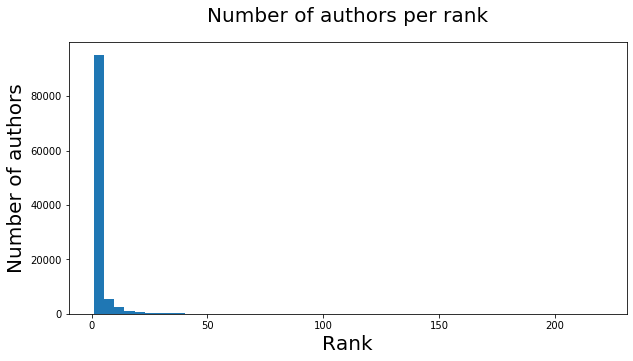

In [90]:
plt.figure(figsize=(10,5))
plt.hist(ranking['rank'], bins=50)
plt.xlabel('Rank',size=20)
plt.ylabel('Number of authors',size=20)
plt.title('Number of authors per rank', size=20,pad=20)
plt.show()

* Since there are many authors that published the same number of papers, there are too many ties in this ranking. A ranking that relies on only one feature (the number of papers) does not reflect how much impact those papers have had.
* We can see that there are only 136 ranks whereas our data involves 105816 different authors. 

### B2. H5-index

Another way to score and rank authors could be based on the quality of the conferences and journals where they publish their papers. For this task, you have to use the H5-index score from AMiner (https://aminer.org/ranks/conf) (another database of scholarly publications), which captures the quality of academic conferences: the higher the H5-index, the better the conference.
1. Load the AMiner dataset ( *'aminer_ai.tsv'* available in the folder ``data/``), which contains H5-index values for AI conferences. Load it into a new Pandas dataframe, and join it with the author-centric DBLP dataframe.
2. Calculate a *'new'* author ranking (give each author a score, by which the authors are then sorted in order to obtain the ranking), where each author's score is the sum of the H5-indices of all their papers (the H5-index of a paper being the H5-index of the conference it is published in).
3. Analyze your new, H5-index-based author ranking and explain how and why your results are different from the previous ranking. Do you see any differences in the top-20 authors based on the H5-index-based ranking and the one produced using publication counts? If yes, list the authors that are ranked in the top 20 based on publication counts but absent in the top 20 based on the H5-index-based ranking. Identify the ranks of these authors in the ranking produced by the H5-index based ranking scheme.
4. Now, take the authors in the file `data/list_of_selected_authors.txt`, and compute their rankings using the two (naïve and H5-index-based) ranking schemes. What do you observe? Explain the potential dangers of the naïve, paper-count-based score.
5. On the flip side, do you see any potential dangers of using the H5-index-based score?   
_Hint: Analyze the conferences in which the top ranked authors publish. Investigate the effect of the conferences in which these authors publish more frequently on the obtained ranking._

***B2.1***

In [91]:
#Loading the data
rank_df= pd.read_csv("data/aminer_ai.csv", sep=';')
rank_df.drop(columns=['Rank'], inplace=True)
rank_df.head()

,Conference (Full Name),Short Name,H5-Index
0,IEEE Conference on Computer Vision and Pattern...,CVPR,112
1,IEEE Transactions on Pattern Analysis and Mach...,TPAMI,101
2,Expert Systems with Applications,Expert Syst. Appl.,59
3,International Journal of Computer Vision,IJCV,58
4,IEEE International Conference on Robotics and ...,ICRA,58


In [92]:
#We only keep the highest index (the first occurrence) for conferences that may have more than one H5-Index
rank_df=rank_df.drop_duplicates(subset=['Conference (Full Name)', 'Short Name'])

In [93]:
#We notice that the conference names in the author-centric DBLP dataframe are in small case
print("conference names: ", df_authors.conference.unique())
#We convert the conferences name to lower case to be able to perform the merge
rank_df['Short Name']= rank_df['Short Name'].str.casefold()

conference names:  ['iccv' 'icra' 'iccbr' 'aamas' 'ksem' 'naacl' 'pricai' 'aaai' 'ida' 'cvpr'
 'ilp' 'fgr' 'emnlp' 'nips' 'accv' 'icann' 'icml' 'ijcai' 'iconip' 'acl']


In [94]:
#Joining the data with the author-centric DBLP dataframe and getting rid of the columns we don't need
authors_conferences = df_authors.copy()
authors_conferences = df_authors.merge(rank_df, left_on='conference', right_on='Short Name')\
                    .drop(columns=['Short Name','Conference (Full Name)'])
authors_conferences.head()

,id,author,title,conference,year,H5-Index
0,conf/iccv/KunoOO90,Yoshinori Kuno,Object recognition using a feature search stra...,iccv,1990,58
1,conf/iccv/KunoOO90,Yasukazu Okamoto,Object recognition using a feature search stra...,iccv,1990,58
2,conf/iccv/KunoOO90,Satoshi Okada,Object recognition using a feature search stra...,iccv,1990,58
3,conf/iccv/VedulaBRCK99,Sundar Vedula,Three-Dimensional Scene Flow.,iccv,1999,58
4,conf/iccv/VedulaBRCK99,Simon Baker,Three-Dimensional Scene Flow.,iccv,1999,58


***B2.2***

In [95]:
#Order the authors by the H5-Index of the conferences where they published papers
new_ranking = authors_conferences.groupby(by='author').sum().drop(columns='year').sort_values(by= 'H5-Index', ascending=False)
new_ranking.reset_index(inplace=True)
new_ranking.rename(columns={'H5-Index':'H5-rank','author':'author'},inplace=True)
new_ranking.head(20)

,author,H5-rank
0,Luc Van Gool,18695
1,Thomas S. Huang,14052
2,Xiaoou Tang,13190
3,Trevor Darrell,12763
4,Shuicheng Yan,12448
5,Toshio Fukuda,11368
6,Marc Pollefeys,11265
7,Larry S. Davis,11141
8,Martial Hebert,10629
9,Takeo Kanade,10569


***B2.3***

In [96]:
#we compute the number of unique ranks
len(new_ranking['H5-rank'].unique())

2262

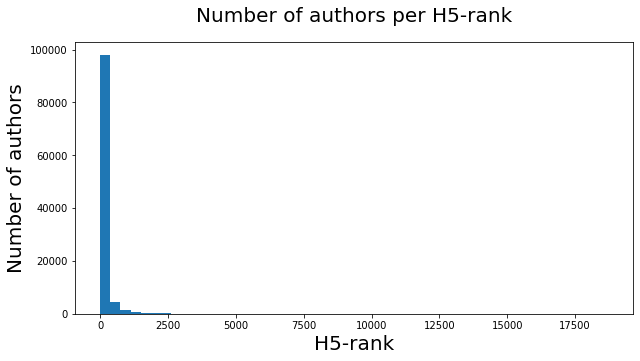

In [97]:
plt.figure(figsize=(10,5))
plt.hist(new_ranking['H5-rank'], bins=50)
plt.xlabel('H5-rank',size=20)
plt.ylabel('Number of authors',size=20)
plt.title('Number of authors per H5-rank', size=20,pad=20)
plt.show()

**We see that there are 2262 new ranks for 105816 authors, which is a better result than the previous ranking system. These results are different because we take into account the H5-index of each paper which results in a weighted sum of the publications.**

In [98]:
#Let's list the top 20 authors based on publication counts that are absent in the top 20 H5-index-based ranking
absent_from_H5 = (ranking.head(20))[~(ranking.head(20).author.isin(new_ranking.head(20).author))]
absent_from_H5

,author,rank
8,Dan Roth,144
10,Vijay Kumar 0001,143
11,Wolfram Burgard,141
12,Roland Siegwart,137
13,Eric P. Xing,137
15,Christopher D. Manning,136
18,Dan Klein,134
19,Bernhard Schölkopf,133


In [99]:
absent_from_H5.merge(new_ranking).sort_values(by='H5-rank', ascending=False)

,author,rank,H5-rank
1,Vijay Kumar 0001,143,8334
3,Roland Siegwart,137,8111
2,Wolfram Burgard,141,7879
4,Eric P. Xing,137,7812
7,Bernhard Schölkopf,133,7167
0,Dan Roth,144,5933
5,Christopher D. Manning,136,5657
6,Dan Klein,134,5314


The H5-rank of these authors is not high enough to appear in the top 20 authors for the new ranking system. 
The highest H5-rank amongst them is 8334, whereas the lowest H5-rank in the top 20 authors is 8890. 

***B2.4***

In [100]:
#Load the list of selected authors
selected_authors=pd.read_csv('data/list_of_selected_authors.txt', sep='\n', names=['author'])
#Comparing the H5-rank and the naïve rank of the selected authors
selected_authors.merge(new_ranking).merge(ranking)

,author,H5-rank,rank
0,Parag Havaldar,170,2
1,Steffen Abraham,170,2
2,Yukihiro Nakamura,170,2
3,Iljung S. Kwak,170,2
4,Charles Freundlich,170,2
5,Mengjie Zhang,140,13
6,Naokazu Yokoya,158,11
7,Sebastian Otte,148,10
8,Jianwu Dang,122,10
9,Hy Murveit,170,17


###### Let's investigate the case of the author: Parag Havaldar

In [101]:
authors_conferences[authors_conferences.author=='Parag Havaldar']

,id,author,title,conference,year,H5-Index
7134,conf/iccv/HavaldarM95,Parag Havaldar,Segmented Shape Descriptions from 3-View Stereo.,iccv,1995,58
146496,conf/cvpr/HavaldarM96,Parag Havaldar,"Inference of segmented, volumetric shape from ...",cvpr,1996,112


This author has published 2 papers, one of which has figured in the CVPR conference (with a very high H5-index). This high index conference allows the author to have a 170 H5-index rank, even though the number of papers published is relatively low. The naïve ranking system may lead us to believe that the author does not have a high enough impact.

***B2.5***

In [102]:
#First let's display the top conferences by order of their H5-index
authors_conferences[['conference','H5-Index']].drop_duplicates().sort_values(by=['H5-Index'],ascending=[False])\
                            .reset_index(drop=True).head()

,conference,H5-Index
0,cvpr,112
1,iccv,58
2,icra,58
3,icml,56
4,nips,51


In [103]:
#As suggested by the hint, we analyze the conferences in which the 3 top ranked authors published more often.
top_conf = authors_conferences[authors_conferences.author.isin(new_ranking.author[:3])]\
                .groupby(['conference']).agg({'id': 'count'}).rename(columns={'id':'count'})
top_conf = pd.merge(authors_conferences[['conference','H5-Index']], top_conf, on='conference').drop_duplicates()\
                .sort_values(by=['count'],ascending=[False]).reset_index(drop=True)
top_conf

,conference,H5-Index,count
0,cvpr,112,320
1,iccv,58,118
2,fgr,1,31
3,accv,10,23
4,aaai,44,18
5,nips,51,18
6,icra,58,11
7,ijcai,35,10
8,icml,56,5
9,naacl,10,1


* We observe that the top ranked authors have been publishing most of their papers in the conferences with high H5-index namely 'cvpr' and 'iccv'. The H5-index of an author can quickly rise to higher values in this case. 
* This implies that even if some author did publish a lot of papers but not necessarily in the high ranked conferences, they cannot compete with the other authors that are highly "H5-ranked".

### B3. And Justice For All

An ideal ranking scheme should not give undue advantage to authors who have been conducting research for a longer period of time and therefore have naturally published more papers when compared to a junior researcher. Does the ranking scheme designed by you in ``Step 2`` take this factor into account? If not, introduce variations in your ranking scheme to mitigate this effect. Do you observe anything odd with this new ranking? Clearly explain your observations.

_Hint: What you did in part A4 may be useful here._

* The H5-based ranking does not take into account that some authors have been conducting research for a longer period of time, and so it penelizes newbies.
* We could introduce a new ranking system that would compute the ranking as follows:
$$justice\_rank = H5\_rank * normalized\_paper\_count$$ 
Where the normalized paper count is the number of papers divided by the years of activity for a given author.
* This ranking system takes into account the "years of activity" of some author, the number of papers they published and the relevance of the conferences they published in.*

In [104]:
#We compute the justice ranking of each author following the formula defined above
author_activity = author_activity.reset_index()
author_activity.columns = author_activity.columns.droplevel(1)
just_ranking = pd.merge(new_ranking, author_activity[['author','paper_count']], on='author')
just_ranking['just_ranking'] = just_ranking['H5-rank'] * just_ranking['paper_count']

In [105]:
#We print 20 random authors justice ranking.
just_ranking.sample(20)

,author,H5-rank,paper_count,just_ranking
94462,Shoko Kato,8,1.000000,8.000000
25183,Tetsuro Funato,116,1.000000,116.000000
59306,Federico Piloni,58,1.000000,58.000000
3498,Michael D. Naish,696,0.857143,596.571429
16353,Giuseppe Attardi,202,0.194444,39.277778
24313,Xibin Song,122,1.000000,122.000000
64402,Gergo Orbán,51,1.000000,51.000000
52513,Arantxa Villanueva,58,1.000000,58.000000
58493,Lawrence J. Tognetti,58,1.000000,58.000000
48770,Youngwoo Sim,58,1.000000,58.000000


## Task C. Trending topics

Historically, the field of AI has witnessed research in two broad flavors: “symbolic” (logic, planning, control, etc.) vs. “connectionist” (neural networks, deep learning, Bayesian methods, etc.). Let’s see if we can see how the popularity of these two approaches to AI is reflected in the DBLP data.

To this end, construct two dataframes: ``symbolic`` and ``connectionist``. ``symbolic`` is your cleaned paper-centric dataframe from part A (after fixing everything per the task description) filtered down to those papers whose titles contain at least one of the following words (not differentiating between upper and lower case letters): “logic”, “planning”, “control”; ``connectionist`` is a dataframe constructed in a similar manner, but with the words “deep”, “learning”, “feature”, “bayesian”. Plot the number of papers per year for ``symbolic`` and ``connectionist`` separately (i.e., 2 plots).
1. Describe the trends you observe. Based on these plots alone, what might one conclude about the popularity of the two approaches to AI?
2. Moving beyond these plots, what do you, as a careful data scientist, conclude about the popularity of symbolic vs. connectionist AI? Corroborate your reasoning with further plots.

_Note: You could use the text handling utilities below to clean the text in the paper titles._

In [106]:
# Text handling utilities
from string import punctuation
stopwords_list = open('data/stopwords.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])

In [107]:
#function that turns lists into a tuple of regex expressions to look up specific words in a string
def listtoregex(l):
    middle_terms = ''
    start_terms = ''
    end_terms = ''
    for i in l:
        start_terms = start_terms + i + ' |'
        end_terms = end_terms + ' ' + i + '|'
        middle_terms = middle_terms + ' ' + i + ' |'
    return start_terms[:-1], middle_terms[:-1], end_terms[:-1]
#df_completed = pd.read_pickle('df_paperCentric_pickle')
l = df_completed.title.tolist()
l = [stopword_remover(remove_punct(lowercase_all(title))) for title in l]
df_completed['title'] = l
df_completed

,authors,conference,id,title,year
0,"'Yoshinori Kuno', 'Yasukazu Okamoto', 'Satoshi...",iccv,conf/iccv/KunoOO90,object recognition using feature search strate...,1990
1,"'Sundar Vedula', 'Simon Baker', 'Peter Rander'...",iccv,conf/iccv/VedulaBRCK99,threedimensional scene flow,1999
2,"'Étienne Mémin', 'Patrick Pérez'",iccv,conf/iccv/MeminP99,fluid motion recovery coupling dense parametri...,1999
3,"'Sven J. Dickinson', 'Alex Pentland', 'Azriel ...",iccv,conf/iccv/DickinsonPR90,qualitative 3d shape reconstruction using dist...,1990
4,"'Avi Singh', 'Larry Yang', 'Sergey Levine'",iccv,conf/iccv/SinghYL17,gplac generalizing visionbased robotic skills ...,2017
...,...,...,...,...,...
8245,"'Jacques J. Vidal', 'John Haggerty'",nips,conf/nips/VidalH87,synchronization neural nets,1987
8246,"'Harry Wechsler', 'George Lee Zimmerman'",nips,conf/nips/WechslerZ87,invariant object recognition using distributed...,1987
8247,'Richard C. Windecker',nips,conf/nips/Windecker87,learning networks nondeterministic adaptive lo...,1987
8248,"'Ben S. Wittner', 'John S. Denker'",nips,conf/nips/WittnerD87,strategies teaching layered networks classific...,1987


In [108]:
words_symbolic = ['logic', 'planning', 'control']
symbolic_regex = listtoregex(words_symbolic)
symbolic_start = df_completed[df_completed['title'].str.startswith(symbolic_regex[0])]
symbolic_middle = df_completed[df_completed['title'].str.contains(symbolic_regex[1])]
symbolic_end = df_completed[df_completed['title'].str.endswith(symbolic_regex[2])]

symbolic = pd.concat([symbolic_start,symbolic_middle,symbolic_end],ignore_index=True)

#We plot the number of symbolic approach papers per year
symbolic_by_year = symbolic.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
symbolic_by_year = symbolic_by_year.sort_values(by='year', ascending=False)
symbolic_by_year.reset_index(inplace=True, drop=True)
symbolic_by_year

,year,number_publications
0,2018,237
1,2017,257
2,2016,201
3,2015,297
4,2014,225
5,2013,226
6,2012,197
7,2011,259
8,2010,204
9,2009,168


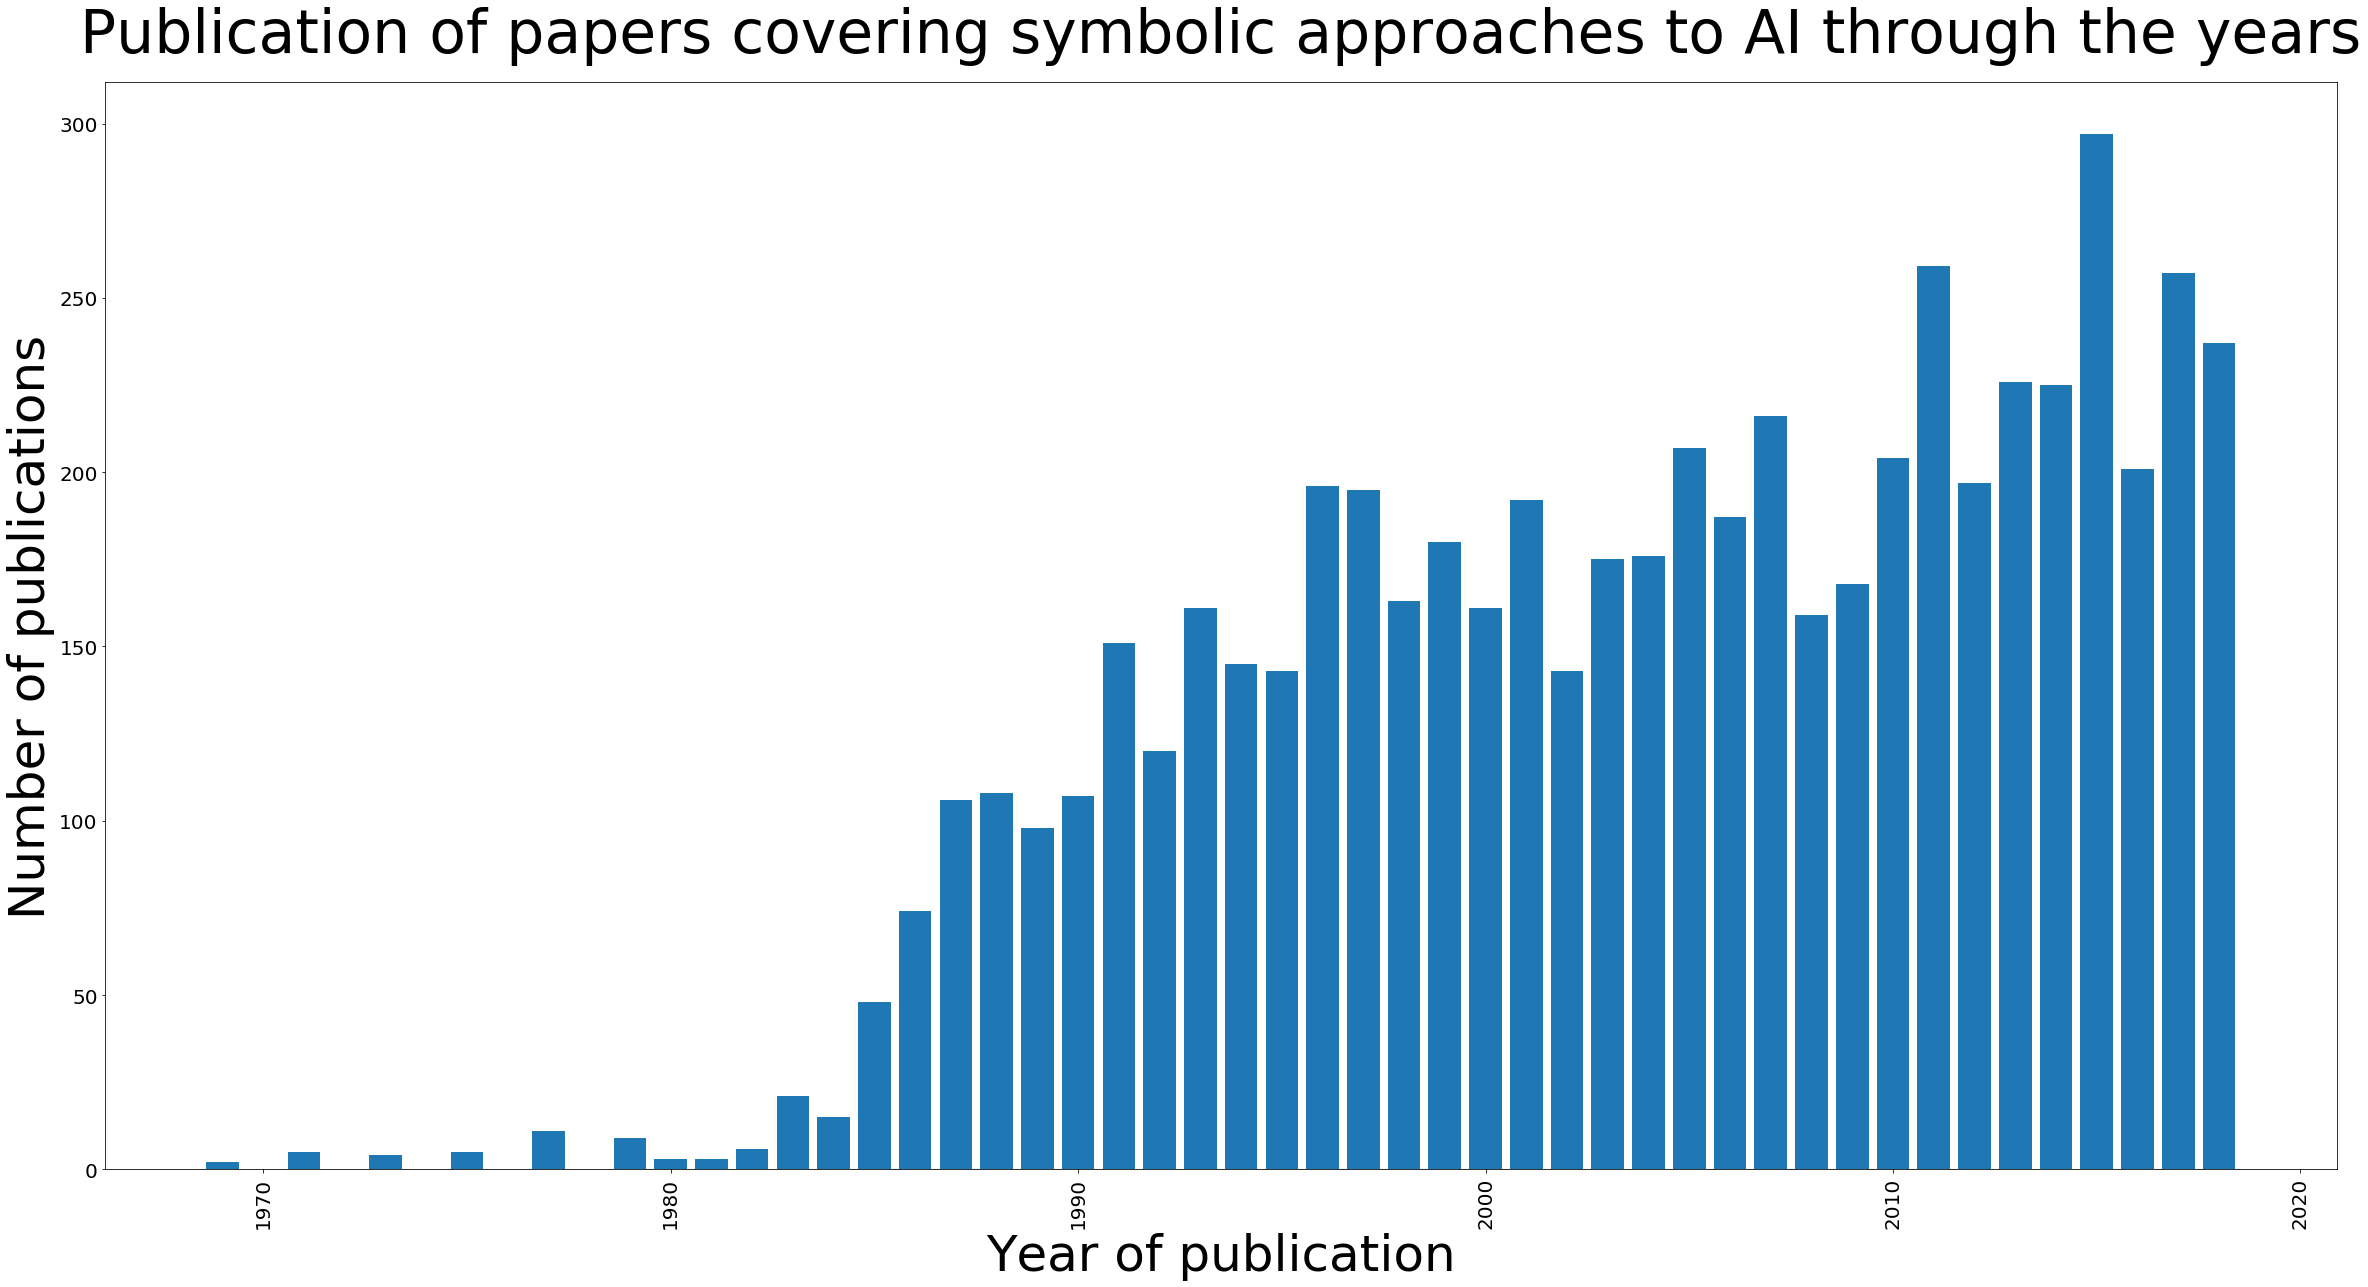

In [109]:
plt.figure(figsize=(40,20))
plt.bar(symbolic_by_year.year,symbolic_by_year.number_publications)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Year of publication',size=50)
plt.ylabel('Number of publications',size=50)
plt.title('Publication of papers covering symbolic approaches to AI through the years', size=60,pad=30)
plt.show()

In [110]:
words_connectionist = ['deep', 'learning', 'feature', 'bayesian']
connectionist_regex = listtoregex(words_connectionist)
connectionist_start = df_completed[df_completed['title'].str.startswith(connectionist_regex[0])]
connectionist_middle = df_completed[df_completed['title'].str.contains(connectionist_regex[1])]
connectionist_end = df_completed[df_completed['title'].str.endswith(connectionist_regex[2])]

connectionist = pd.concat([connectionist_start,connectionist_middle,connectionist_end],ignore_index=True)

#We plot the number of connectionist approach papers per year
connectionist_by_year = connectionist.groupby(['year']).count().reset_index()[['year','id']].rename(columns={"id": "number_publications"})
connectionist_by_year = connectionist_by_year.sort_values(by='year', ascending=False)
connectionist_by_year.reset_index(inplace=True, drop=True)
connectionist_by_year


,year,number_publications
0,2018,1712
1,2017,1344
2,2016,898
3,2015,724
4,2014,507
5,2013,548
6,2012,451
7,2011,440
8,2010,393
9,2009,371


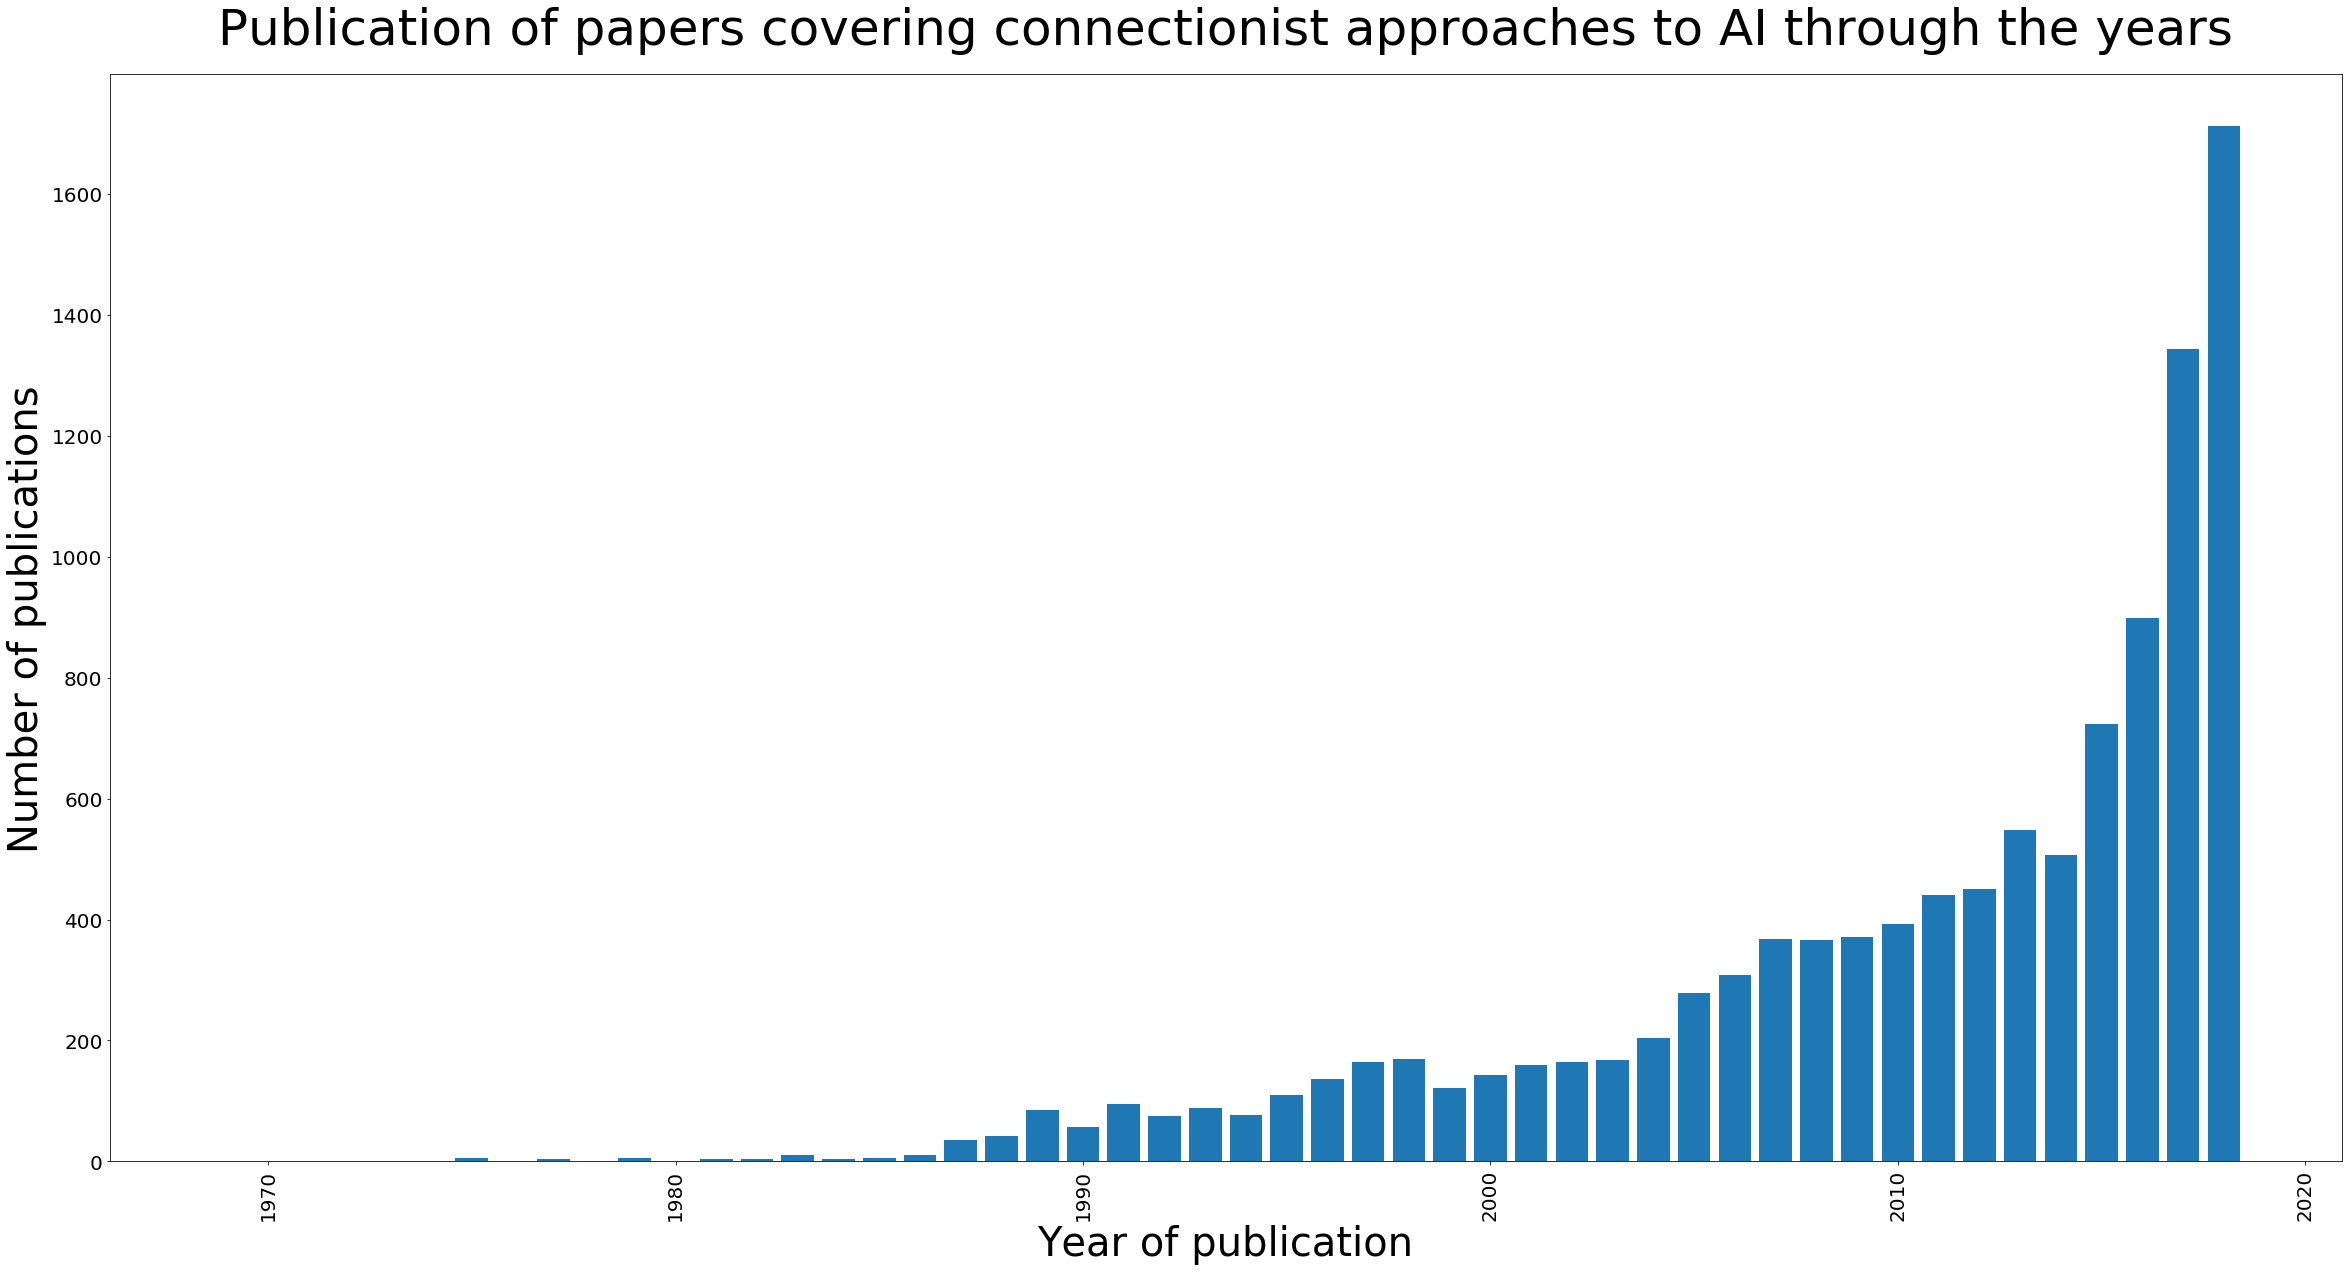

In [111]:
plt.figure(figsize=(40,20))
plt.bar(connectionist_by_year.year,connectionist_by_year.number_publications)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Year of publication',size=40)
plt.ylabel('Number of publications',size=40)
plt.title('Publication of papers covering connectionist approaches to AI through the years', size=50,pad=30)
plt.show()

1. Based on the plots alone, one could make the following observations. The symbolic approach to AI has seen a gradual increase in interest through the years. If we observe the graph more closely, we can see that interest in it has also seen some drops along the way but that overall, the trend it has followed is increasing as the number of papers has almost doubled between 1990 and 2015. More recently, it has seen a slight decrease. The connectionist approach has, on the other hand, seen an almost exponential increase in interest. The number of papers published saw an increase from about 50 in 1990 to about 650 in 2015. The number of papers published on 2015 was hence 13x bigger than the number of papers published in 1990. In recent years, the interest in it has increased even more as the number of papers published in 2018 was almost double that of the papers published in 2015. In fact, since 2014, the number of papers has been strictly increasing.


2. As data scientists, we know that the AI hype has been brought on by advances in technology which are making the connectionist approach feasible. We also know that "traditional" AI which relied on logic is not as popular and effective as the "machine learning" approach to AI. Interest has been particularly booming for deep learning and neural networks. This trend in data science is perfectly captured in the above two plots. One should be careful as the **increase in interest for the connectionist approach seems questionable**. The data we are analyzing might potentially be biased:
 * It might for example concentrate on conferences which take into account connectionist approaches more than symbolic approaches
 * It might also be simply wrong and contain some outliers that have not been detected
 * Another possibility is that the data concerning conferences which focus more on symbolic approaches is missing

* Let's do a conference level analysis of both approaches

In [112]:
symbolic_by_conf = symbolic.groupby(['conference']).count().reset_index()[['conference','id']].rename(columns={"id": "number_publications"})
symbolic_by_conf = symbolic_by_conf.sort_values(by='conference', ascending=False)
symbolic_by_conf.reset_index(inplace=True, drop=True)

#Get the number of publications per conference per year
symbolic_by_conf_by_year = symbolic.groupby(['conference','year']).count().reset_index()[['conference','year','id']].rename(columns={"id": "number_publications"})
symbolic_by_conf_by_year = symbolic_by_conf_by_year.sort_values(by='number_publications', ascending=False)
symbolic_by_conf_by_year.reset_index(inplace=True, drop=True)

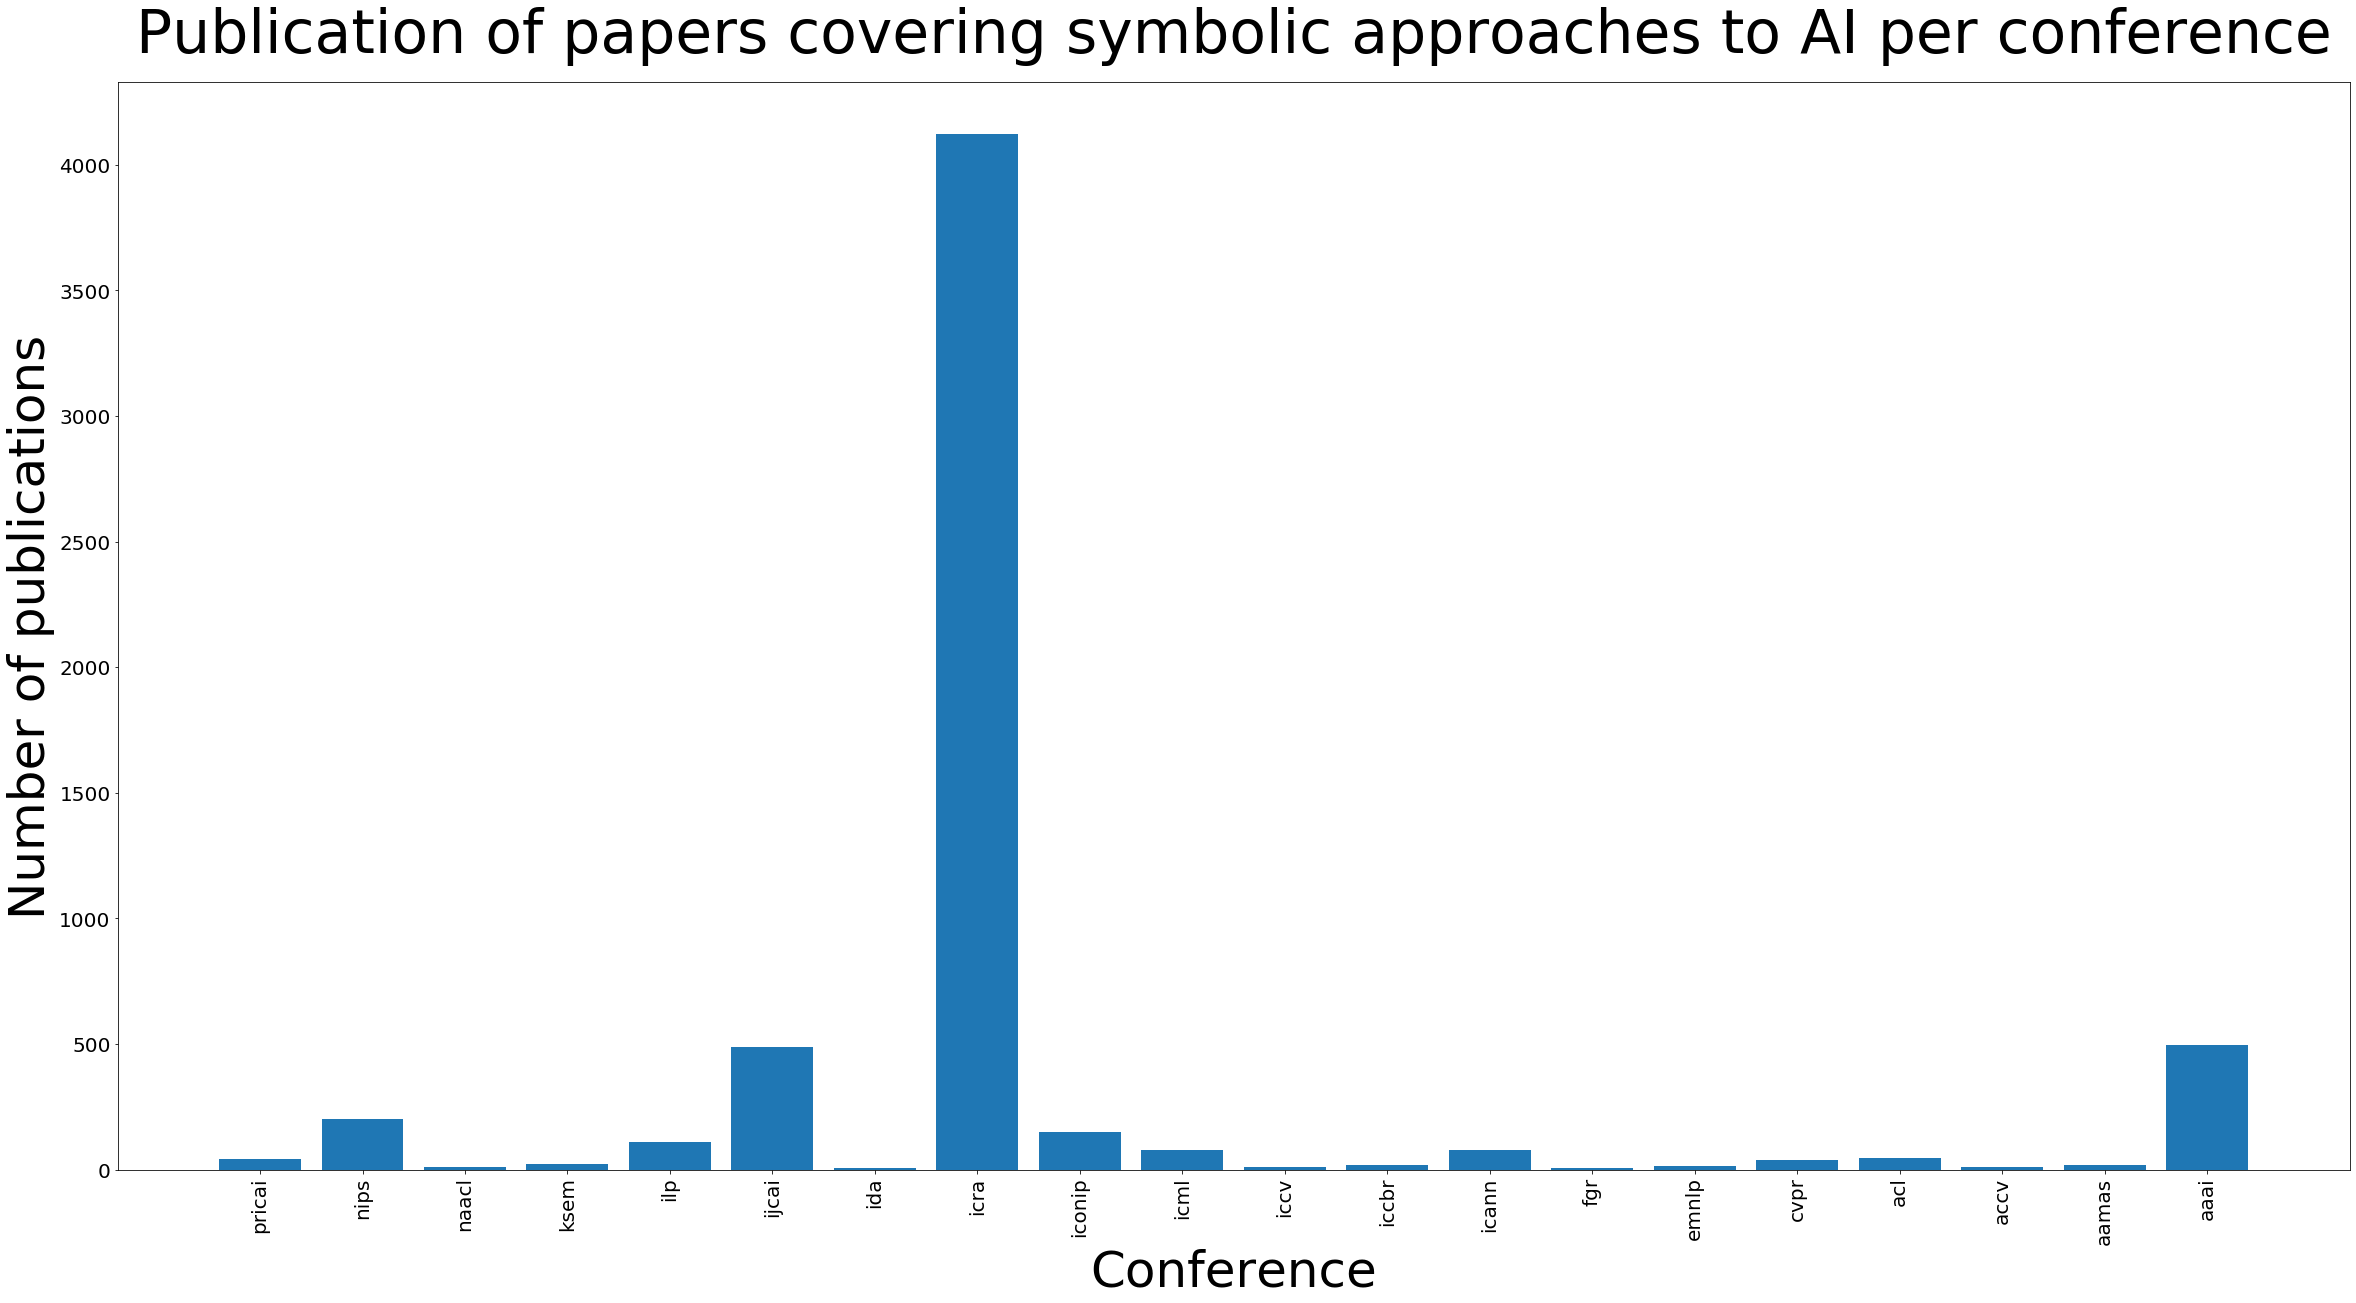

In [113]:
plt.figure(figsize=(40,20))
plt.bar(symbolic_by_conf.conference,symbolic_by_conf.number_publications)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Conference',size=50)
plt.ylabel('Number of publications',size=50)
plt.title('Publication of papers covering symbolic approaches to AI per conference', size=60,pad=30)
plt.show()

In [114]:
def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

random_color()

(255, 0, 0)

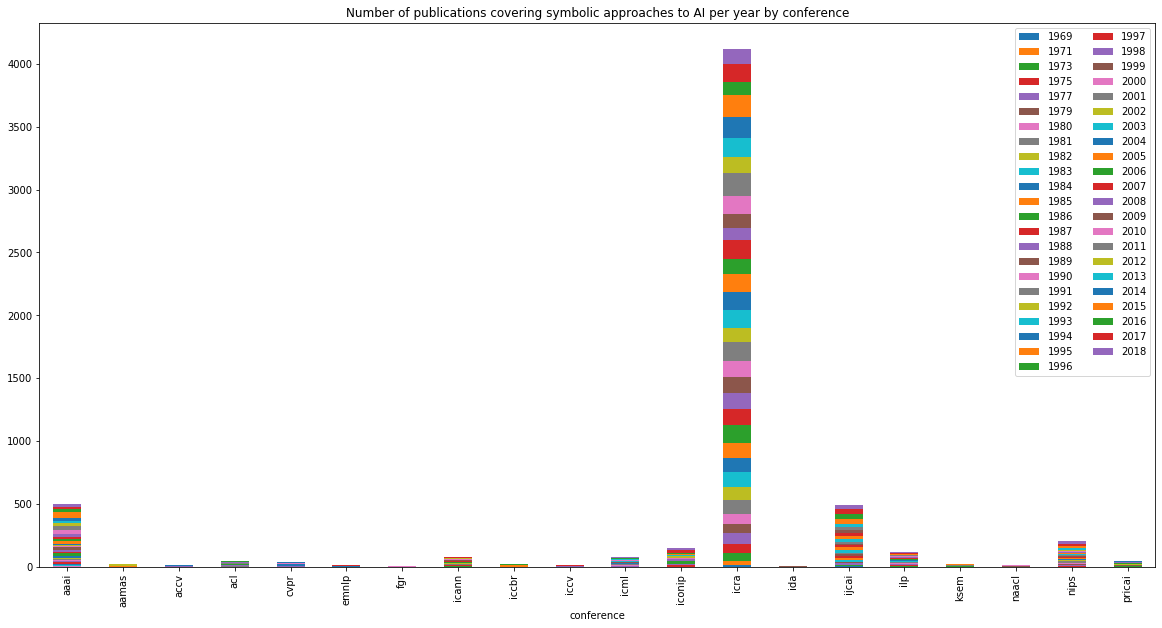

In [115]:
pivot_df = symbolic_by_conf_by_year.pivot(index='conference', columns='year', values='number_publications')
pivot_df.plot.bar(stacked=True, figsize=(20,10),\
                  title='Number of publications covering symbolic approaches to AI per year by conference')
plt.legend(loc='upper right', ncol=2)

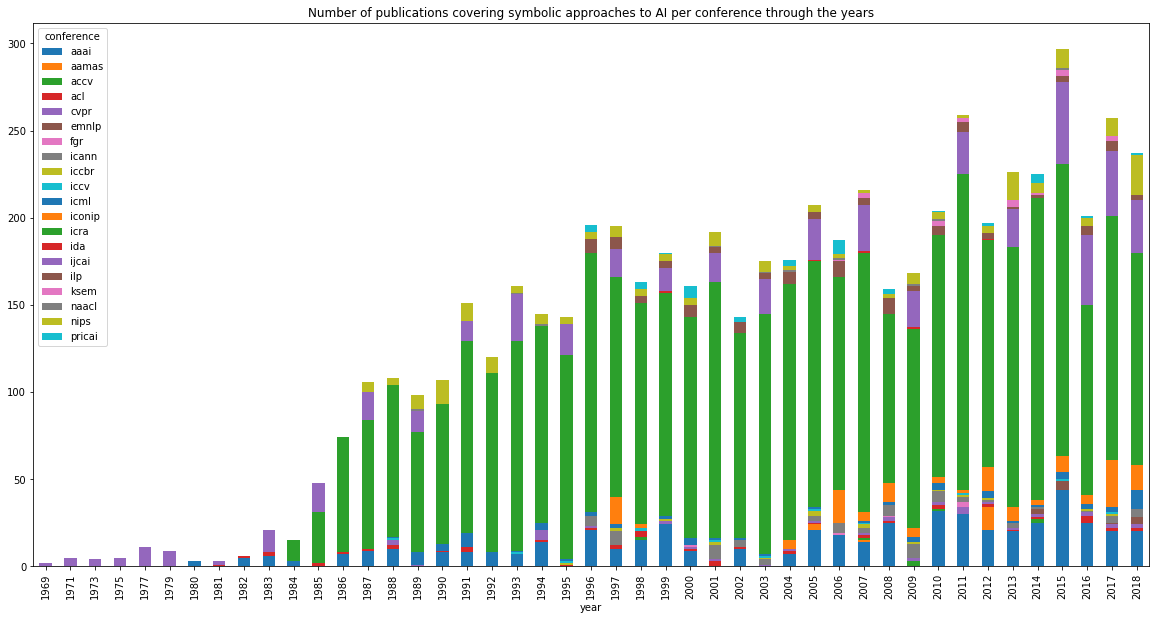

In [116]:
pivot_df = symbolic_by_conf_by_year.pivot(index='year', columns='conference', values='number_publications')
pivot_df.plot.bar(stacked=True,\
                  figsize=(20,10),\
                  title='Number of publications covering symbolic approaches to AI per conference through the years')

In [117]:
connectionist_by_conf = connectionist.groupby(['conference']).count().reset_index()[['conference','id']].rename(columns={"id": "number_publications"})
connectionist_by_conf = connectionist_by_conf.sort_values(by='conference', ascending=False)
connectionist_by_conf.reset_index(inplace=True, drop=True)

#Get the number of publications per conference per year
connectionist_by_conf_by_year = connectionist.groupby(['conference','year']).count().reset_index()[['conference','year','id']].rename(columns={"id": "number_publications"})
connectionist_by_conf_by_year = connectionist_by_conf_by_year.sort_values(by='number_publications', ascending=False)
connectionist_by_conf_by_year.reset_index(inplace=True, drop=True)


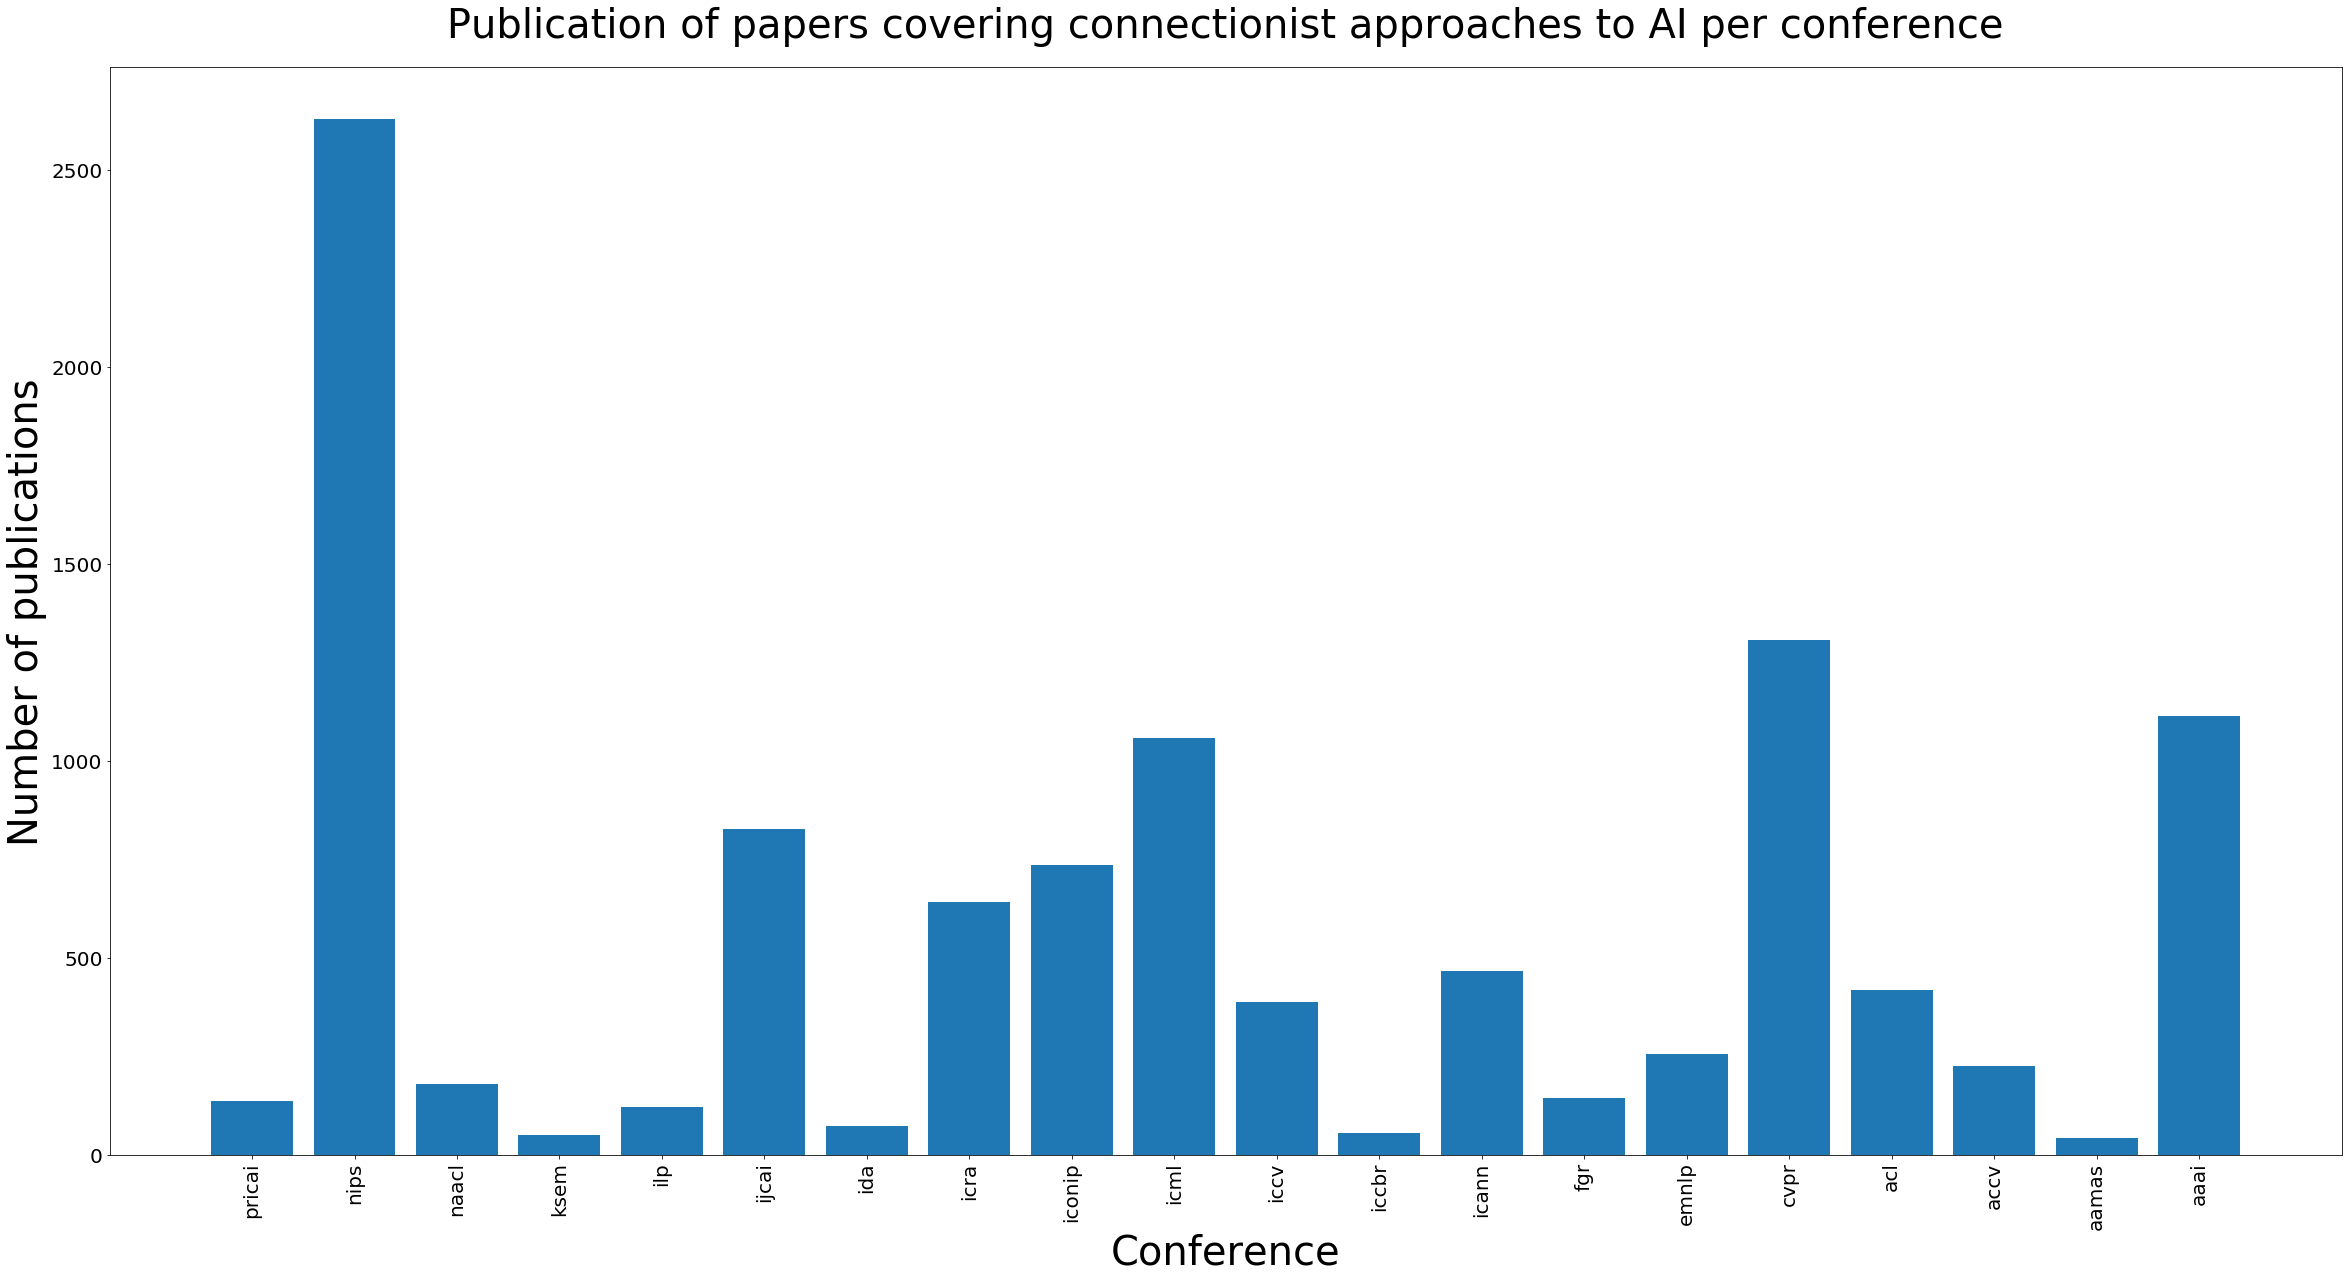

In [118]:
plt.figure(figsize=(40,20))
plt.bar(connectionist_by_conf.conference,connectionist_by_conf.number_publications)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Conference',size=40)
plt.ylabel('Number of publications',size=40)
plt.title('Publication of papers covering connectionist approaches to AI per conference', size=40,pad=30)
plt.show()

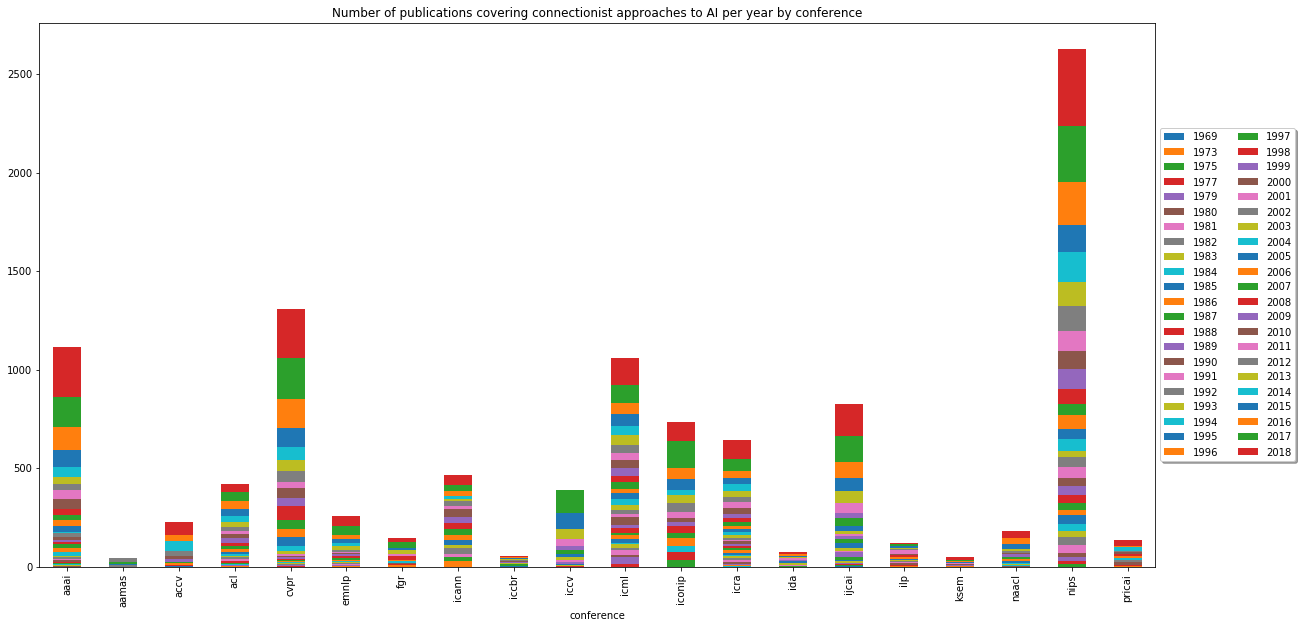

In [119]:
pivot_df = connectionist_by_conf_by_year.pivot(index='conference', columns='year', values='number_publications')
pivot_df.plot.bar(stacked=True, figsize=(20,10),\
                  title='Number of publications covering connectionist approaches to AI per year by conference')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2, fancybox=True, shadow=True)

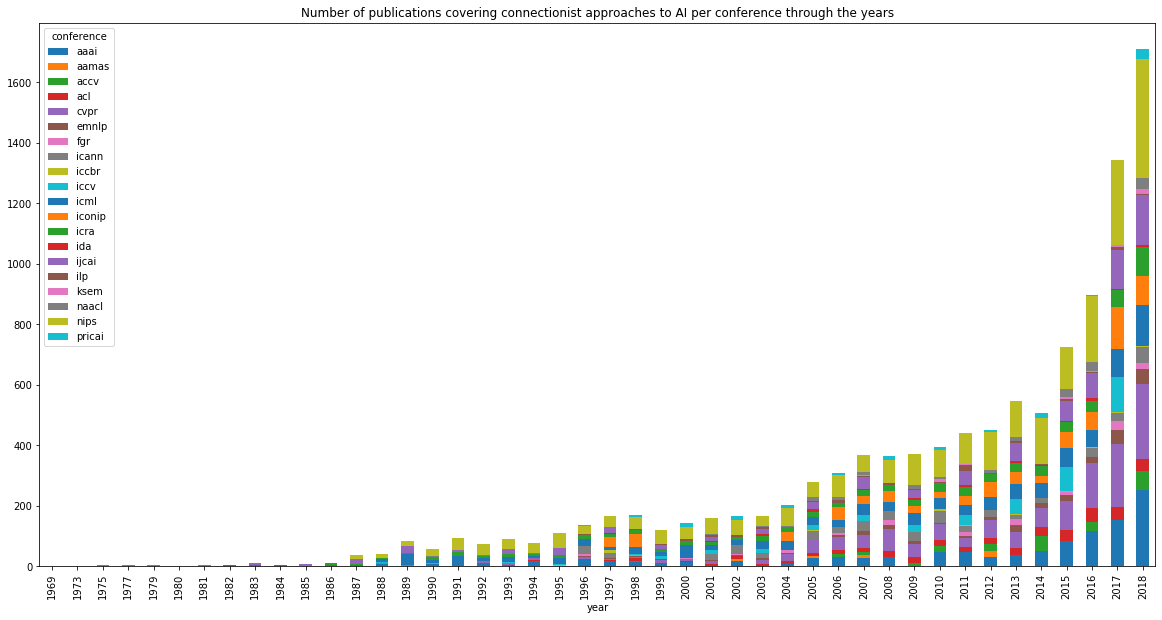

In [120]:
pivot_df = connectionist_by_conf_by_year.pivot(index='year', columns='conference', values='number_publications')
pivot_df.plot.bar(stacked=True,figsize=(20,10),title='Number of publications covering connectionist approaches to AI per conference through the years')

* We can see that there is one conference in particular which publishes papers on the symbolic papers. That conference is ICRA. Its interest in it has remained consistent through the years whereas the interest in it exhibited from other conferences has mostly gotten lower through the years. This explains the slow growth and slight recent decline in interest in the subject which we saw earlier as there seems to only be one conference which contributes to it.
* For the connectionist approach, interest has increased when it comes to all conferences through the years. This explains the almost exponential growth which we saw earlier as all conferences contribute to that growth.
* Let's plot the stacked bar chart combining the symbolic and connectionist approaches for better visualization.

In [121]:
symbolic['approach'] = 'symbolic'
connectionist['approach'] = 'connectionist'
symb_conn = pd.concat([symbolic,connectionist],axis=0)
symb_conn.head()

,authors,conference,id,title,year,approach
0,"'Keisuke Kinoshita', 'Michael Lindenbaum'",iccv,conf/iccv/KinoshitaL98,robotic control partial visual information,1998,symbolic
1,"'Nicolas Papadakis', 'Étienne Mémin'",iccv,conf/iccv/PapadakisM07,variational optimal control technique tracking...,2007,symbolic
2,"'Shree K. Nayar', 'Vlad Branzoi'",iccv,conf/iccv/NayarB03,adaptive dynamic range imaging optical control...,2003,symbolic
3,"'Charles Malleson', 'Jean Charles Bazin', 'Oli...",iccv,conf/iccv/MallesonBWBBHS15,facedirector continuous control facial perform...,2015,symbolic
4,"'Yuke Zhu', 'Daniel Gordon', 'Eric Kolve', 'Di...",iccv,conf/iccv/ZhuGKFFGMF17,visual semantic planning using deep successor ...,2017,symbolic


In [122]:
#Year level
symbconn_by_year = symb_conn.groupby(['approach','year']).count().reset_index()[['approach','year','id']].rename(columns={"id": "number_publications"})
symbconn_by_year = symbconn_by_year.sort_values(by='number_publications', ascending=False)
symbconn_by_year.reset_index(inplace=True, drop=True)

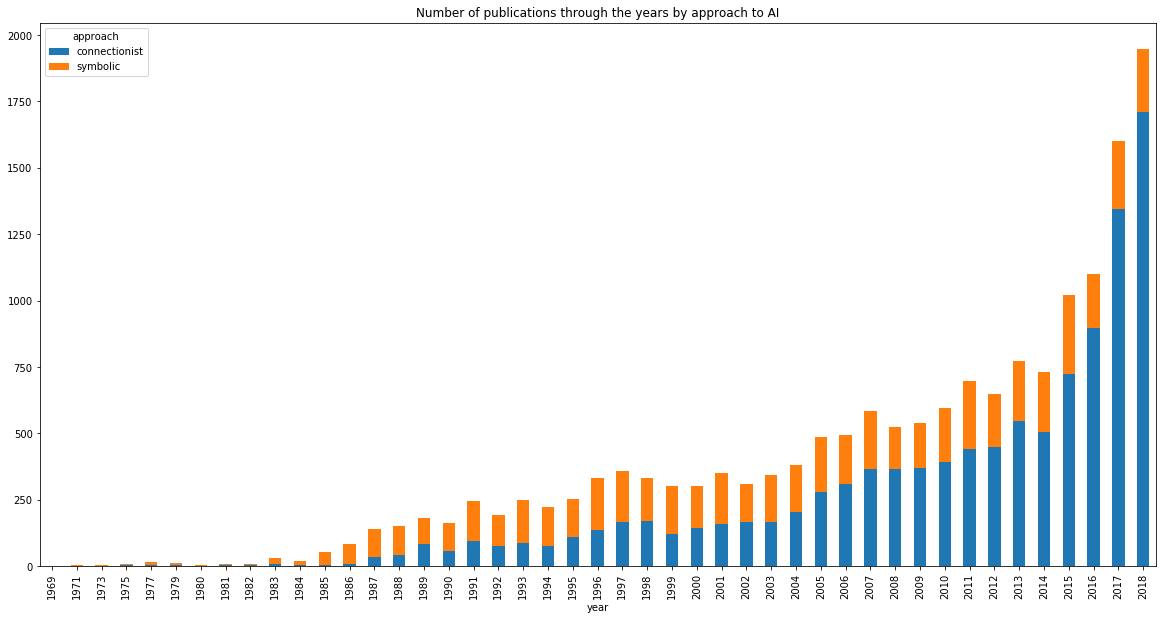

In [123]:
pivot_df = symbconn_by_year.pivot(index='year', columns='approach', values='number_publications')
pivot_df.plot.bar(stacked=True, figsize=(20,10),title='Number of publications through the years by approach to AI')

In [124]:
#Conference level
symbconn_by_conf = symb_conn.groupby(['approach','conference']).count().reset_index()[['approach','conference','id']].rename(columns={"id": "number_publications"})
symbconn_by_conf = symbconn_by_conf.sort_values(by='number_publications', ascending=False)
symbconn_by_conf.reset_index(inplace=True, drop=True)

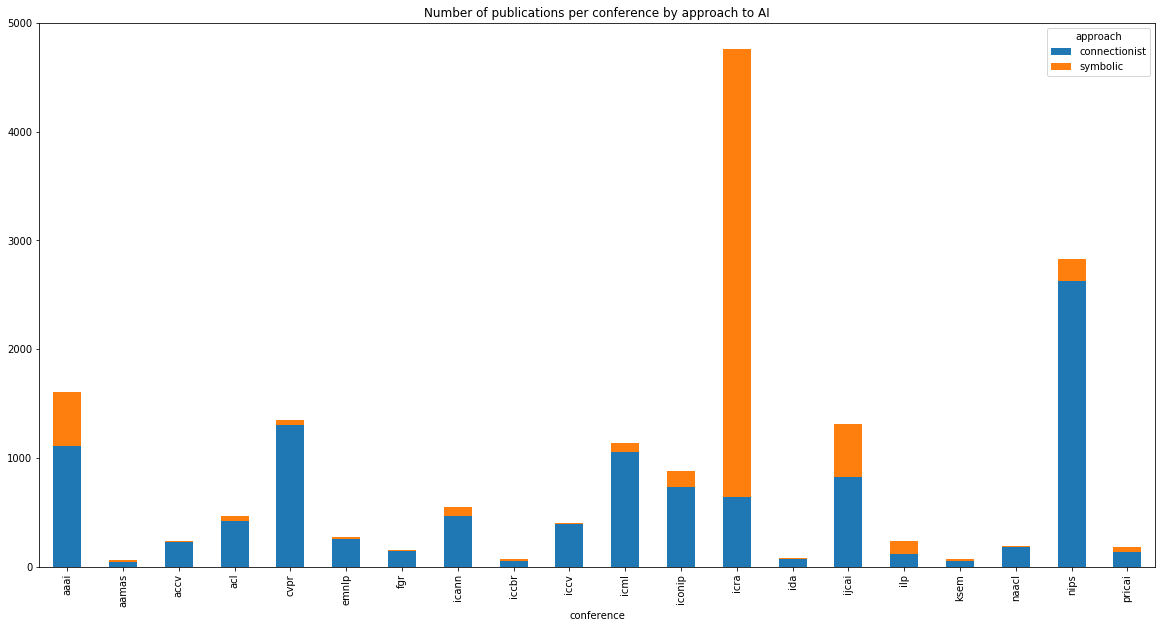

In [125]:
pivot_df = symbconn_by_conf.pivot(index='conference', columns='approach', values='number_publications')
pivot_df.plot.bar(stacked=True, figsize=(20,10),title='Number of publications per conference by approach to AI')


* At the year level, we can clearly see the exponential growth in interest for the connectionist approach that we saw earlier. We can also see relatively stable, slighty growing but recently declining interest in symbolic approaches to AI which we also saw in the earlier plots.
* At the conference level, we can clearly see that the contribution per conference for the connectionist approach is consistently high for each conference. On the other hand, we can see that there is a clear imbalance in the contribution of the conferences to the symbolic approach publications. It is the ICRA conference which again has the biggest contribution. When compared to other conferences' contributions, it almost seems like an outlier. Hence, it might be an outlier, or it might also be that it is the leading conference in symbolic approaches to AI.